# 1. Introduction


## About the Dataset

This dataset was created from data taken from the 1970 United States census and other sources and used in a paper investigating the willingness of people to pay more for clean air in the Boston housing market. 

Harrison, D. and Rubinfeld, D. (1978). Hedonic housing prices and the demand for clean air. Journal of Environmental Economics and Management, 5(1), pp.81-102.

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as pyplt
%matplotlib inline
import keras as ks
from keras.callbacks import EarlyStopping
import sklearn.preprocessing as pre
import sklearn.model_selection as mod
import sklearn.decomposition as dec
from sklearn.utils import shuffle
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.datasets import load_boston
boston = load_boston()

Using TensorFlow backend.


The scikit learn source includes a description file that can be printed to learn more about the dataset and it's features:

In [2]:
df = pd.DataFrame(boston.data)
df['Median_Value'] = boston.target
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [3]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,Median_Value
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


However, I found the above descriptions the datasets attributes to be unclear so I read the original source paper to get more detail. My updated decscriptions are included below are based on Table IV in the source paper.

|Orginal Attribute Name|New Name|Description|Assumed Relationship to Housing Values|
|:------------------------|:---------|:-----------|:------------------------------|
|CRIM|Crime_Rate|Crime rate by town|Negative|
|ZN|%_Large_Plots|Proportion of residential land zoned for large plots|Postive|
|INDUS|%_Indus|Proportion of land zoned for industrial use|Negative|
|CHAS|By_River|Boolean value for whether the land borders the Charles River|Positive|
|NOX|NOX|Nitrogen oxide concentrations in the air|Negative|
|RM|Rooms|Average number of rooms in houses|Positive|
|AGE|%_Pre_1940|Proporation of houses constructed before 1940. Older housing is of good quality in Boston|Positive|
|DIS|Dist_to_Jobs|Weighted distance to places of employment|Positive|
|RAD|Highway_Access|Index of accessabilty to highways|Positive|
|TAX|Tax|Full Value Property Tax Rate|Negative|
|PTRATIO|PTRatio|Pupil-Teacher ration in the area. Higher values mean more students per teacher|Negative|
|B|Blks_per_1000|Proportion of the population that are black. At the time regarded as undisirable by Whites|Negative|
|LSTAT|%_Lower_Status|Proportion of adults without a high school education or male laborers|Negative|

## 1.2 Adding more readable column names

In [4]:
#setting columns names
df.columns = ["Crime_Rate", "%_Large_Plots", "%_Indus", "By_River", "NOX", "Rooms", "%_Pre_1940", "Dist_to_Jobs", "Highway_Access", "Tax", "PTRatio", "Blks_per_1000", "%_Lower_Status", "Median_Val"]

In [5]:
#checking the new column names line up 
df.head()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [6]:
df.tail()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0
505,0.04741,0.0,11.93,0.0,0.573,6.030,80.8,2.5050,1.0,273.0,21.0,396.90,7.88,11.9


In [7]:
df.columns

Index(['Crime_Rate', '%_Large_Plots', '%_Indus', 'By_River', 'NOX', 'Rooms',
       '%_Pre_1940', 'Dist_to_Jobs', 'Highway_Access', 'Tax', 'PTRatio',
       'Blks_per_1000', '%_Lower_Status', 'Median_Val'],
      dtype='object')

# 2. Descriptive Analysis

#### Objective 1: Use descriptive statistics and plots to describe the Boston House Prices Dataset

In the section I will use descriptive statistics and plots to provide a summary of the dataset and describe it's main features. This is of course a compenent of any data analysis project and will also aid in the identifying the steps that need to be taken in the data pre-processing stage of implementing the machine learning model that is shown later in this project.

## 2.1 Basic Information 

Pandas "info()" method can tell us the counts of datapoints in each of the features and also show if there are any missing / null values in the dataset. As we can see below, there are no null values that will have to be dealt with.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
Crime_Rate        506 non-null float64
%_Large_Plots     506 non-null float64
%_Indus           506 non-null float64
By_River          506 non-null float64
NOX               506 non-null float64
Rooms             506 non-null float64
%_Pre_1940        506 non-null float64
Dist_to_Jobs      506 non-null float64
Highway_Access    506 non-null float64
Tax               506 non-null float64
PTRatio           506 non-null float64
Blks_per_1000     506 non-null float64
%_Lower_Status    506 non-null float64
Median_Val        506 non-null float64
dtypes: float64(14)
memory usage: 55.5 KB


## 2.2 Measures of central tendancy and measures of spread / dispersion

Next we will look at the measures of central tendancy and the spread / dispersion of the data.

1. Measures of Central Tendancy attempt to give one number that best summarises the data. These include the mean/average, median and mode. 
2. Measures of spead / dispersion show the variability within the data. These include the range (max - min), standard deviation, variance, skewness, kurtosis etc.

Pandas "describe()" function quickly gives an overview of some of these key statistics for each of the features in the dataset.

In [9]:
df.describe()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


Looking at the means, range, and quartile values in the above tables indicates that some of the features have very unevenly distributed values. Especially the crime rate and number of black people per 1000 people. It is also worth noting that different features are operating on very different scales.

The above table does not give the mode (most commonly occuring value) for each of the features, but the Pandas "mode()" function can be used to get this.

In [10]:
df.mode()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
0,0.01501,0.0,18.1,0.0,0.538,5.713,100.0,3.4952,24.0,666.0,20.2,396.9,6.36,50.0
1,14.33370,NaN,NaN,NaN,NaN,6.127,NaN,NaN,NaN,NaN,NaN,NaN,7.79,NaN
2,NaN,NaN,NaN,NaN,NaN,6.167,NaN,NaN,NaN,NaN,NaN,NaN,8.05,NaN
3,NaN,NaN,NaN,NaN,NaN,6.229,NaN,NaN,NaN,NaN,NaN,NaN,14.10,NaN
4,NaN,NaN,NaN,NaN,NaN,6.405,NaN,NaN,NaN,NaN,NaN,NaN,18.13,NaN
5,NaN,NaN,NaN,NaN,NaN,6.417,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


It is worth noting that the most common Median House price is 50,000 which also happens to be the maximum value. This will need to be looked at more closely. Other features where the mode is equal to the max value include:
1. The % of houses in the area built before 1940 - The mode is 100%, but this is believable in an old city like Boston.
2. Number of accessible highways - The mode and max are 24. 
3. Number of Blacks per 1000 - the mode and max are 396.9, but for such a specific number it may only have occured twice to be counted as the mode. 
4. Percentage of industrial land - The max and mode are both 18.1. Again this will need to be looked at more closely to see if it's an error. 

In [11]:
df.median()

Crime_Rate          0.25651
%_Large_Plots       0.00000
%_Indus             9.69000
By_River            0.00000
NOX                 0.53800
Rooms               6.20850
%_Pre_1940         77.50000
Dist_to_Jobs        3.20745
Highway_Access      5.00000
Tax               330.00000
PTRatio            19.05000
Blks_per_1000     391.44000
%_Lower_Status     11.36000
Median_Val         21.20000
dtype: float64

Comparing the above median values of the features to the max and mins again gives the impression of some highly skewed / unevenly distributed data.

## 2.3 Distribution of values

Next we will plot the distribution of the values and see if that highlights any issue or outliers. Beginning with the target variable - Median Value of House Prices.

As can be seen from the above KDE and Boxplot, there is a cluster of outliers in the upper range of values. It may be better to remove these later.

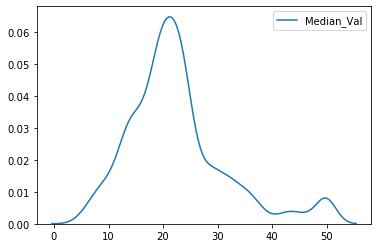

In [12]:
sns.kdeplot(df['Median_Val'])

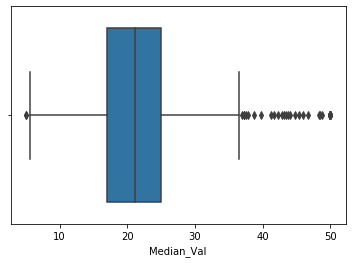

In [13]:
sns.boxplot(df['Median_Val'])

Looking at the all the features side by side, we can see that only Rooms, % of Lower Status people, Median Value are close to being normaly distributed. 

The "By_River" variable is a dummy variable with a boolean value. 

Crime rate, and the % of Large Plots have a large number of values close to zero which is understandable and doesn't set any alarm bells ringing about errors in the data.

The number of black people per 1000 tends towards the 40% mark, which again seems reasonable for a major US city and doesn't give any indication of errors in the data.

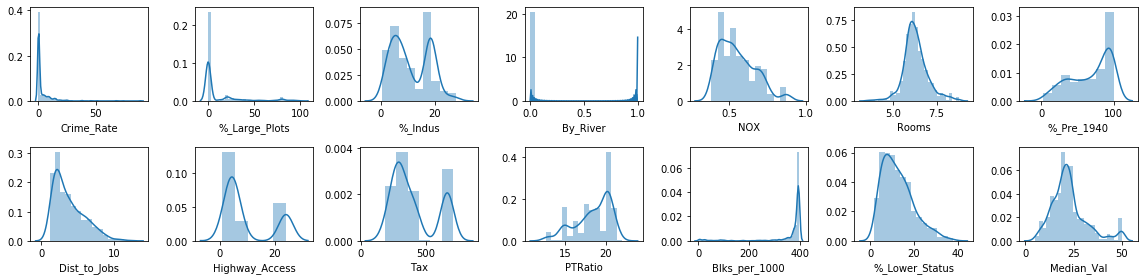

In [14]:
# distributions of the data
rows = 2
cols = 7

fig, ax = pyplt.subplots(nrows= rows, ncols= cols, figsize = (16,4))

col = df.columns
index = 0

for i in range(rows):
    for j in range(cols):
        sns.distplot(df[col[index]], ax = ax[i][j])
        index = index + 1

pyplt.tight_layout()

## 2.4 Relationships between the Variables

This next section will highlight any relationships between the data, beginning with creating a corrolation table.

In [15]:
corr_matrix = df.corr().round(2)
corr_matrix.style.background_gradient(cmap='coolwarm')

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
Crime_Rate,1,-0.2,0.41,-0.06,0.42,-0.22,0.35,-0.38,0.63,0.58,0.29,-0.39,0.46,-0.39
%_Large_Plots,-0.2,1,-0.53,-0.04,-0.52,0.31,-0.57,0.66,-0.31,-0.31,-0.39,0.18,-0.41,0.36
%_Indus,0.41,-0.53,1,0.06,0.76,-0.39,0.64,-0.71,0.6,0.72,0.38,-0.36,0.6,-0.48
By_River,-0.06,-0.04,0.06,1,0.09,0.09,0.09,-0.1,-0.01,-0.04,-0.12,0.05,-0.05,0.18
NOX,0.42,-0.52,0.76,0.09,1,-0.3,0.73,-0.77,0.61,0.67,0.19,-0.38,0.59,-0.43
Rooms,-0.22,0.31,-0.39,0.09,-0.3,1,-0.24,0.21,-0.21,-0.29,-0.36,0.13,-0.61,0.7
%_Pre_1940,0.35,-0.57,0.64,0.09,0.73,-0.24,1,-0.75,0.46,0.51,0.26,-0.27,0.6,-0.38
Dist_to_Jobs,-0.38,0.66,-0.71,-0.1,-0.77,0.21,-0.75,1,-0.49,-0.53,-0.23,0.29,-0.5,0.25
Highway_Access,0.63,-0.31,0.6,-0.01,0.61,-0.21,0.46,-0.49,1,0.91,0.46,-0.44,0.49,-0.38
Tax,0.58,-0.31,0.72,-0.04,0.67,-0.29,0.51,-0.53,0.91,1,0.46,-0.44,0.54,-0.47


As we can see from the above there are a number of variables that are strongly positively corrolated, for example:

1. Tax and access to highways (0.91) - understandable as highways are paid for out of taxes.
2. NOX and the % of Industrial Land (0.76) - not very suprising that industrial areas would have high levels of NOX. 
2. NOX and the % of Pre 1940 houses (0.73) - possibly older houses would be burning coal.
3. Tax and the % of Industrial Land (0.71) 

There are also some strongly negatively corrolated variables:

1. NOX and Distance to Jobs (-0.77) - makes sense as areas of employment are likely to be industrial and have more NOX. The further away you are, the better the air
2. % Pre 1940s houses and Distance to Jobs (-0.75) - makes sense as older areas are more likely to be located in the city centre near areas of employment. 
3. % Industrial and Distance to Jobs (-0.71) - same reasoning as point 1 above

In summary, there isn't anything unusual about the values in the corrolation table that requires further investigation. 

Looking more closely at the corrolation between the features and the target variable (Median House Prices), we can see that Rooms and % Lower Status are the most strongly corrolated. The rest of the variables are either moderately or weakly corrolated. This would indicate that the percentage of lower status people and the number of rooms are the best predictors of the housing prices. We will investigate this further later in this project.

In [16]:
median_val_corr = corr_matrix.iloc[-1]
median_val_corr.sort_values(ascending=True)

%_Lower_Status   -0.74
PTRatio          -0.51
%_Indus          -0.48
Tax              -0.47
NOX              -0.43
Crime_Rate       -0.39
%_Pre_1940       -0.38
Highway_Access   -0.38
By_River          0.18
Dist_to_Jobs      0.25
Blks_per_1000     0.33
%_Large_Plots     0.36
Rooms             0.70
Median_Val        1.00
Name: Median_Val, dtype: float64

Looking at below scatterplots of the different features vs the Median Value, Rooms and % of Lower Status People again stand out as having a relationship with it. 

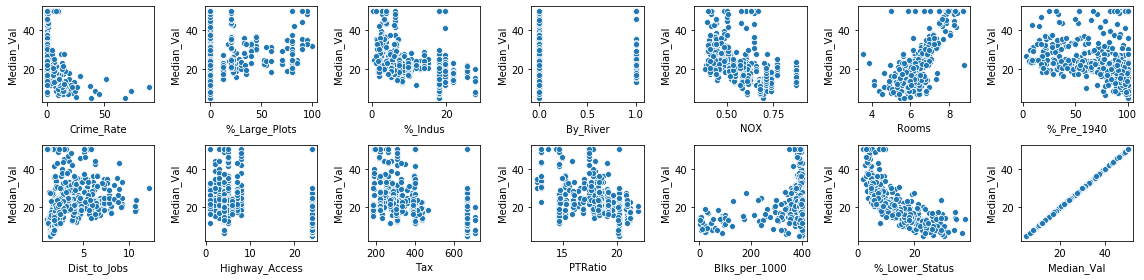

In [17]:
# scatter plots of the variables vs Median Value
rows = 2
cols = 7

fig, ax = pyplt.subplots(nrows= rows, ncols= cols, figsize = (16,4))

col = df.columns
index = 0

for i in range(rows):
    for j in range(cols):
        sns.scatterplot(df[col[index]], y="Median_Val", data=df, ax=ax[i][j])
        index = index + 1
        
        

pyplt.tight_layout()

Looking at the three most strongly corrolated values with the Median Value below, it's clear that the first two variables have a much more obvious relationship, while the Pupil Teacher ratio has much more noise.

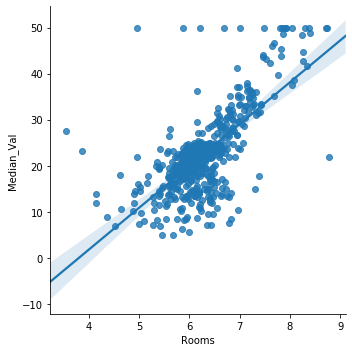

In [18]:
sns.lmplot(x="Rooms", y="Median_Val", data=df)

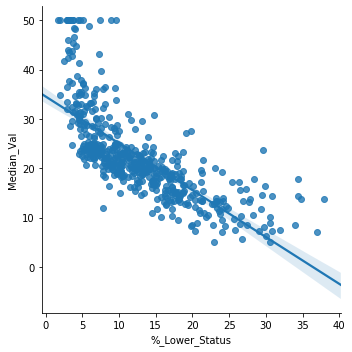

In [19]:
sns.lmplot(x="%_Lower_Status", y="Median_Val", data=df)

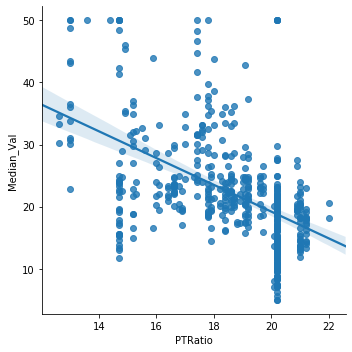

In [20]:
sns.lmplot(x="PTRatio", y="Median_Val", data=df)

## 2.5 Conclusions from the Descriptive Analytics

My main conclusions or items of note from this section are:

1. There are no null values in the data that will need to be dealt with.
2. There are some potential errors / outliers in the Median Values with 14 values being at the max value of $50,000
3. The only other two variables with a normal distribution are also the most strongly corrolated with the Median Value

# 3. Inferential Statistics

#### Objective 2: Analyse whether there is a significant difference between median house prices between houses that are along the Charles river and those that aren't.

The first attribute who's effect on housing prices that I was asked to investigate is whether the house is by the Charles River or not ("CHAS" or "By_River").

In the original paper this dataset was derived from, the authors assumed there would be a positive relationship between being next to the river and housing prices.

As I have shown above, there only seems to be a very week positive corrolation (0.18).

In order to investigate further I have performed a T-Test below.

## 3.1 Looking more closely at the  "By_River" variable

As we can see from the below histogram, there are significantly more areas in our dataset that are located away from the Charles river than next to the Charles River (35).  (471)

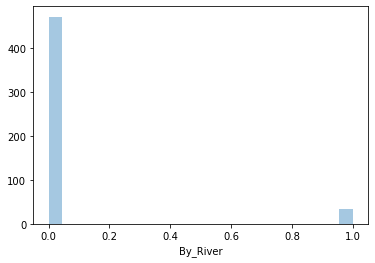

In [21]:
sns.distplot(df['By_River'], kde=False)

In [22]:
# getting the count of areas next to the Charles river
count_by_river = len(df[df['By_River'] == 1.0])
count_by_river

35

In [23]:
# getting the count of areas away from the Charles River
count_away_from_river = len(df[df['By_River'] == 0.0])
count_away_from_river

471

The exact count is:
* 35 next to the river 
* 471 away from the river

Looking at the distribution of the two categories we can see that the houses by the river would seems to have a higher percentage of more expensive houses. In addition, the cheapest house located away from the river.  

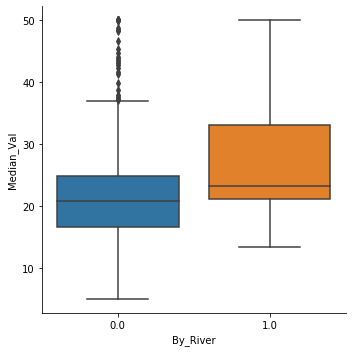

In [24]:
sns.catplot(x='By_River', y='Median_Val', kind='box', data=df)
# What do all the outliers mean

In [25]:
next_to_river = df[df['By_River'] == 1]
away_from_river = df[df['By_River'] == 0]

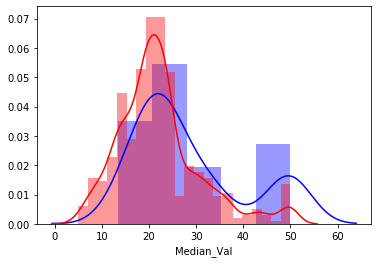

In [26]:
ax = sns.distplot(next_to_river['Median_Val'], color="blue")
ax = sns.distplot(away_from_river['Median_Val'], color="red")
pyplt.rcParams["figure.figsize"] = (20,20)

This is reflected in the descriptive statistics below with the "Next to River" values having a higher mean and mimimum value of than the areas that are located "Away from the River"

In [27]:
next_to_river["Median_Val"].describe()

count    35.000000
mean     28.440000
std      11.816643
min      13.400000
25%      21.100000
50%      23.300000
75%      33.150000
max      50.000000
Name: Median_Val, dtype: float64

In [28]:
away_from_river["Median_Val"].describe()

count    471.000000
mean      22.093843
std        8.831362
min        5.000000
25%       16.600000
50%       20.900000
75%       24.800000
max       50.000000
Name: Median_Val, dtype: float64

## 3.2 T-test

From the above plots and descriptive statistics it would seem that there does indeed to be some difference in the housing prices in areas along the Charles River vs those that aren't. A T-Test can be used to get futher confirmation of this (or indeed disprove this). 

### 3.2.1 Why use a T-Test?

A T-test is used to compare the means of two samples when the parameters of the population as a whole are not known. Using it will allow us to prove or reject the below Null Hypothosis and Alternative Hypothosis [14].

1. The Null Hypothesis is that there is no significant difference between houses along the Charles River and those that aren't.

2. The Alternative Hypothesis is that there is a significant difference between these two groups. 



### 3.2.2 T-Test Requirements

Before we can apply a T-Test, it is first necessary to ensure that our datasets meets the requirements:

|#|Requirement|Pass|Reasoning|
|:------------------------|:---------|:-----------|:-----------|
|1|Dependent variable should be measured on continuous scale|YES|Median Value is measured on continuous scale of 0-50|
|2|Independent variable should consist of two categorical independant groups|YES|Areas are either by or not by the river|
|3|Independence of observations|YES|None of the areas appear twice and no house appears in more than one area|
|4|There should be no significant outliers|NO|There are a number of outliers in the Median Values of houses not by the river|
|5|Dependent variable should be approximately normally distributed for each group|UNKNOWN|At first glance yes, but we will need to test to be sure|
|6|Needs to be homogeneity of variances|UNKNOWN|We will also need to test for this|


As you can see above, the first three requirements were met, but the 4th requirement was failed and the 5th and 6th requirements required further investigation before we can continue with out T-Test.

#### 3.2.2.1 Removing Outliers

As I mentioned earlier in this project, the "Median Val" variable has many outliers. This is clearly displayed in the Boxplot below. 

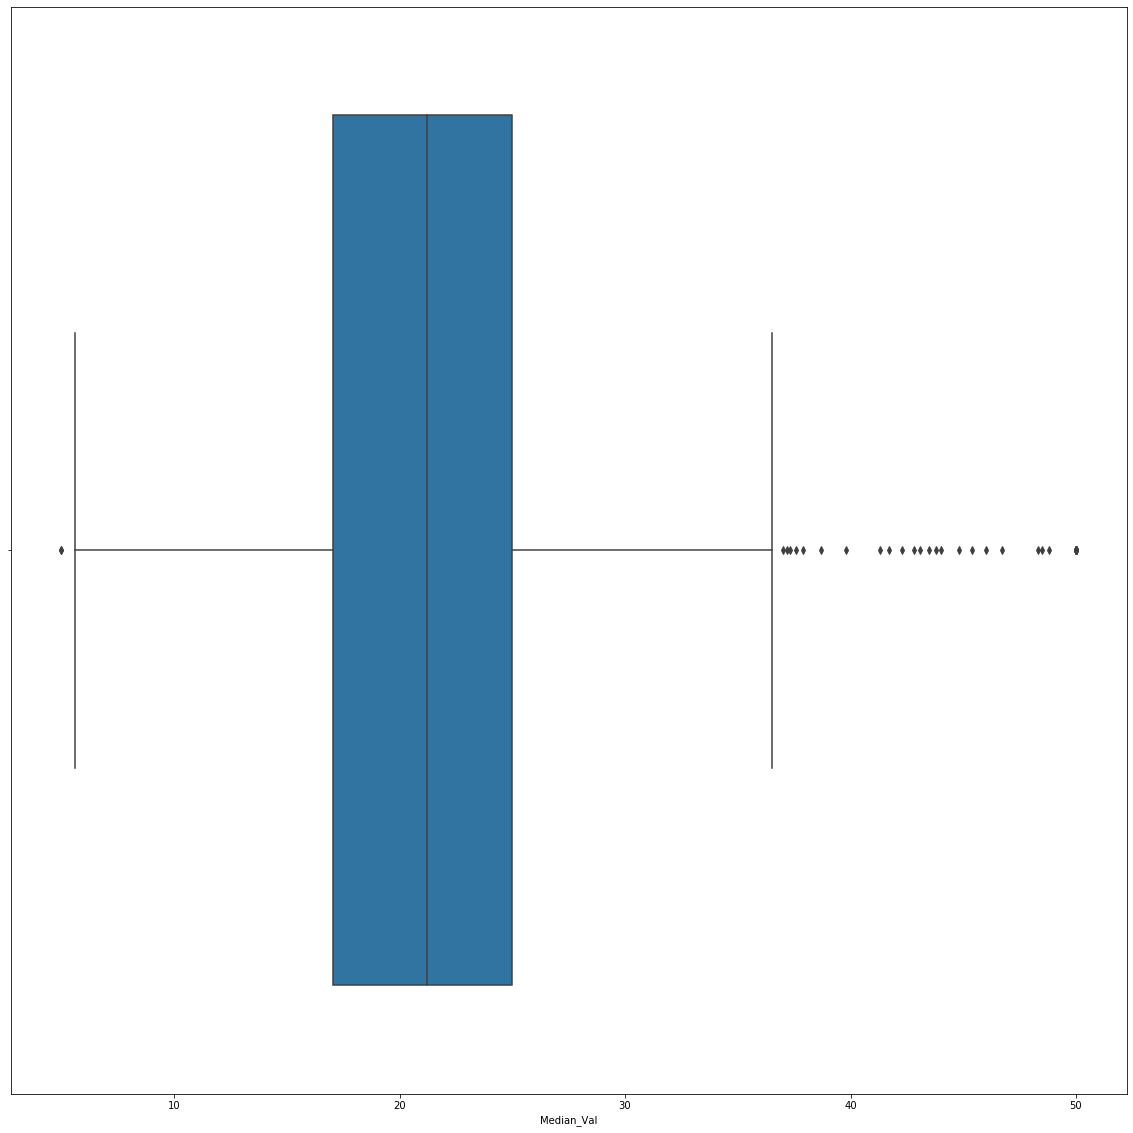

In [29]:
sns.boxplot(df['Median_Val'])

In [30]:
df["Median_Val"][df["Median_Val"] ==50].count()

16

There are also 16 areas where the median value of houses is $50,000, but nothing higher that this value. This could indicate  that there might be a cap on values in the dataset at this value or that this value was entered where accurate information was not available. We could just remove these values, but first I will investigate how many outliers there are in total.

In order to identify the outliers I have assigned a threshold for the Median Value, above or below which i have consider the data point to be an outlier. The most obvious way to do this is to follow the same method as the box-plot and remove an datapoints that are outside of the 75th and 25th percentiles. The Pandas library has a built in quantile method that can be used to calculate these thresholds.

In [31]:
Q1 = df['Median_Val'].quantile(0.25)
Q1

17.025

In [32]:
Q3 = df['Median_Val'].quantile(0.75)
Q3

25.0

In [33]:
IQR = Q3 - Q1
IQR

7.975000000000001

Having calculated the interquartile range, this was then used find the upper and lower "whisker" values for the box plot which will acts as the "outlier thresholds".

In [34]:
# calculate where the tip of the lower boxplot whisker is
lower_thresh = Q1 - 1.5 * IQR
lower_thresh

5.0624999999999964

In [35]:
# calculate where the tip of the upper boxplot whisker is
upper_thresh = Q3 + 1.5 * IQR
upper_thresh

36.962500000000006

In [36]:
# show all values that are below the lower outlier threshold
below = df.loc[df['Median_Val'] < lower_thresh]
below

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
398,38.3518,0.0,18.1,0.0,0.693,5.453,100.0,1.4896,24.0,666.0,20.2,396.90,30.59,5.0
405,67.9208,0.0,18.1,0.0,0.693,5.683,100.0,1.4254,24.0,666.0,20.2,384.97,22.98,5.0


There were two data points below the lower threshold.

In [37]:
# show all values that are above the upper outlier threshold
above = df.loc[df['Median_Val'] > upper_thresh]
above

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
97,0.12083,0.0,2.89,0.0,0.4450,8.069,76.0,3.4952,2.0,276.0,18.0,396.90,4.21,38.7
98,0.08187,0.0,2.89,0.0,0.4450,7.820,36.9,3.4952,2.0,276.0,18.0,393.53,3.57,43.8
157,1.22358,0.0,19.58,0.0,0.6050,6.943,97.4,1.8773,5.0,403.0,14.7,363.43,4.59,41.3
161,1.46336,0.0,19.58,0.0,0.6050,7.489,90.8,1.9709,5.0,403.0,14.7,374.43,1.73,50.0
162,1.83377,0.0,19.58,1.0,0.6050,7.802,98.2,2.0407,5.0,403.0,14.7,389.61,1.92,50.0
163,1.51902,0.0,19.58,1.0,0.6050,8.375,93.9,2.1620,5.0,403.0,14.7,388.45,3.32,50.0
166,2.01019,0.0,19.58,0.0,0.6050,7.929,96.2,2.0459,5.0,403.0,14.7,369.30,3.70,50.0
179,0.05780,0.0,2.46,0.0,0.4880,6.980,58.4,2.8290,3.0,193.0,17.8,396.90,5.04,37.2
180,0.06588,0.0,2.46,0.0,0.4880,7.765,83.3,2.7410,3.0,193.0,17.8,395.56,7.56,39.8
182,0.09103,0.0,2.46,0.0,0.4880,7.155,92.2,2.7006,3.0,193.0,17.8,394.12,4.82,37.9


In [38]:
above["Median_Val"].count()

38

There were 38 datapoints that were higher that the upper threshold. Using these thresholds I created a dataset of data that was within these two thresholds called "no_outliers".

In [39]:
no_outliers = df[((df['Median_Val'] > lower_thresh) & (df['Median_Val'] < upper_thresh))]
no_outliers

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


Comparing the two groups with the outliers removed shows that the median values of the two groups was now much closer together, but the range of values in the "Away from River" group was still much wider.

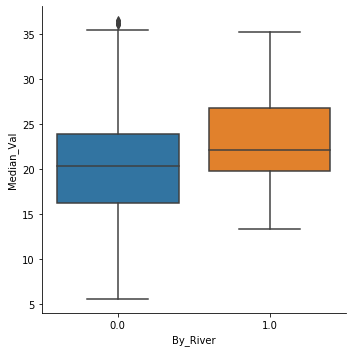

In [40]:
sns.catplot(x='By_River', y='Median_Val', kind='box', data=no_outliers)

#### 3.2.2.2 Determining if the Dependant Variable is Approxmately Normally Distributed in Each Group.

In order to test this I created two new groups from the "no_outliers" dataset:
1. Next to River
2. Away from River

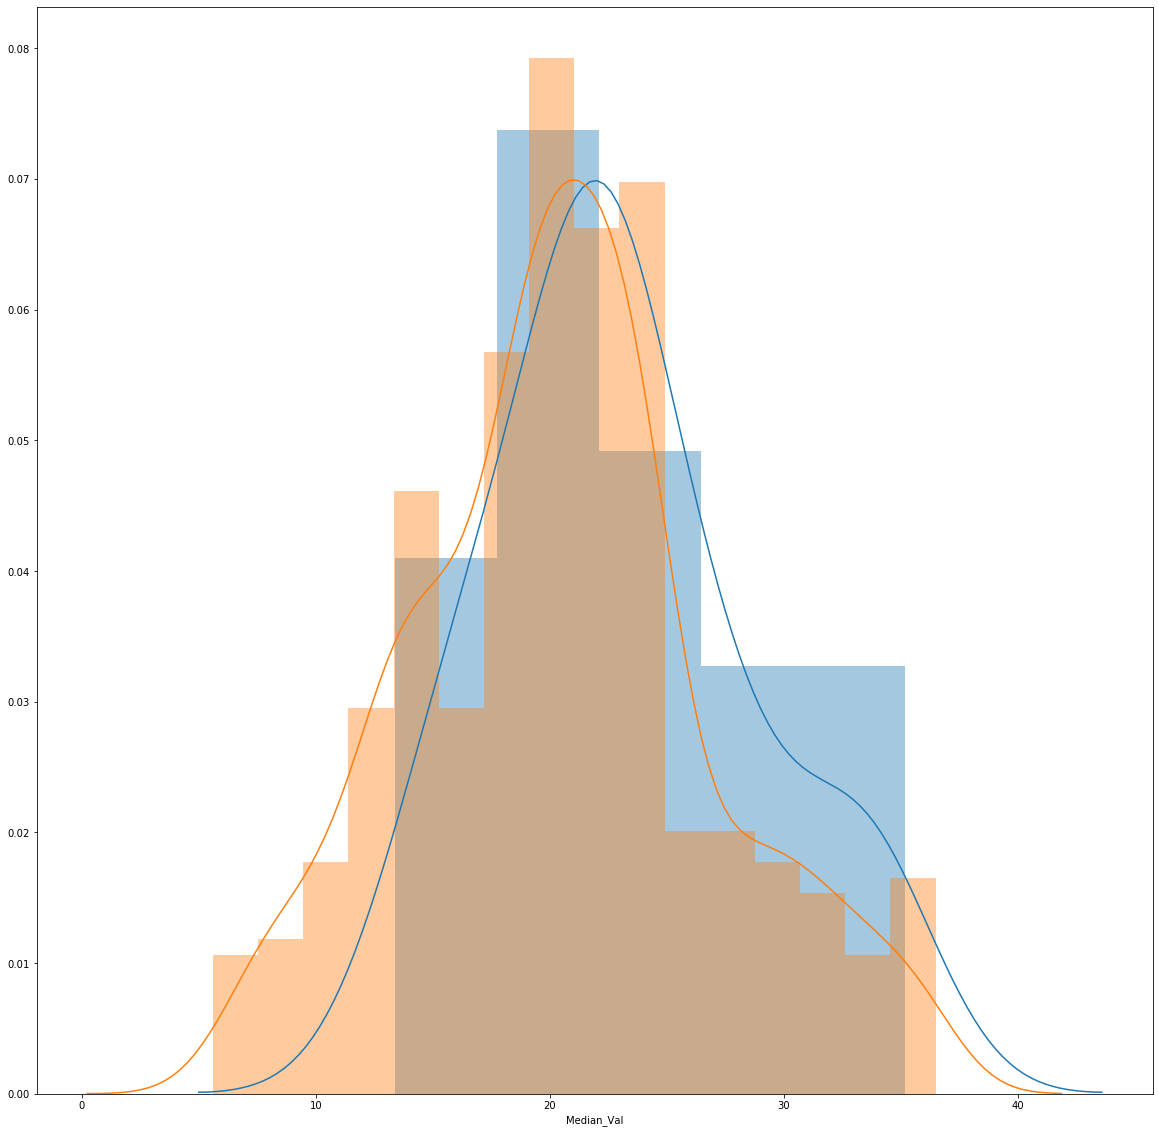

In [41]:
cleansed_next_to_river = no_outliers[no_outliers['By_River'] == 1]
cleansed_away_from_river = no_outliers[no_outliers['By_River'] == 0]

ax = sns.distplot(cleansed_next_to_river['Median_Val'])
ax = sns.distplot(cleansed_away_from_river['Median_Val'])
pyplt.rcParams["figure.figsize"] = (20,20)

From looking at the two "cleansed" group it can be observed that both are much closer to appearing to be normally distributed than the original dataset with the outliers included.

I performed a further test using Scipys "normaltest" method to confirm this.

In [42]:
from scipy import stats
next_to_river_Ntest = stats.normaltest(cleansed_next_to_river['Median_Val'])
away_from_river_Ntest = stats.normaltest(cleansed_away_from_river['Median_Val'])
print(next_to_river_Ntest)
print(away_from_river_Ntest)


NormaltestResult(statistic=1.289316190319236, pvalue=0.5248419574390437)
NormaltestResult(statistic=3.405851916816045, pvalue=0.1821497808954563)


For both groups the Pvalue is greater than the alpha threshold(0.05). I can therefore be said the no significant departure from normality was found [15].

#### 3.2.2.3 Homogenity of Variances

Homogeneity of variance is an assumption underlying t tests in which the population variances (i.e., the distribution, or “spread,” of scores around the mean) of two or more samples are considered equal. In correlations and regressions, the term “homogeneity of variance in arrays,” also called “homoskedasticity,” refers to the assumption that, within the population, the variance of Y for each value of X is constant.

In order to perform a valid t-test it is necessary to check if both samples have similar variances. Levenes test can be used to do this. It tests the null hypothosis that variances are equal. 

In [43]:
stats.levene(cleansed_next_to_river['Median_Val'], cleansed_away_from_river['Median_Val'])

LeveneResult(statistic=0.7964820987689898, pvalue=0.3726098479576784)

The P-value is greater than the threshold of 0.05 so it can be said that there is no signifcant difference in the variances of both groups.

In [44]:
# variance of median values of houses next to the river
print(np.var(cleansed_next_to_river['Median_Val']))

31.402091836734694


In [45]:
# variance of values of house in areas away from the river
print(np.var(cleansed_away_from_river['Median_Val']))

41.76279086132484


#### 3.2.2.4 Summary of T Test Requirement Statuses

|#|Requirement|Pass|Reasoning|
|:------------------------|:---------|:-----------|:-----------|
|1|Dependent variable should be measured on continuous scale|YES|Median Value is measured on continuous scale|
|2|Independent variable should consist of two categorical independant groups|YES|Areas are either by or not by the river|
|3|Independence of observations|YES|None of the areas appear twice and no house appears in more than one area|
|4|There should be no significant outliers|YES|There were originally, but they have been removed.|
|5|Dependent variable should be approximately normally distributed for each group|YES|Both groups are approximately normally distrubuted.|
|6|Needs to be homogeneity of variances|YES|There is homogenity of variances|


### 3.3 T Test Results

Since all the requirements were met, it was appropriate to proceed with the T Test.

In [46]:
stats.ttest_ind(cleansed_next_to_river['Median_Val'], cleansed_away_from_river['Median_Val'])

Ttest_indResult(statistic=2.100509858104912, pvalue=0.03622310352018016)

The purpose of the current section was to test if there is a significant difference in the Median Value of House Prices between the house prices in areas by or not by the Charles River in Boston.

In [47]:
import researchpy as rp

tt_descriptives, tt_results = rp.ttest(cleansed_next_to_river['Median_Val'], cleansed_away_from_river['Median_Val'])

tt_descriptives

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,Median_Val,28.0,23.192857,5.706587,1.078444,20.980074,25.405640
1,Median_Val,438.0,20.560959,6.469804,0.309139,19.953375,21.168543
2,combined,466.0,20.719099,6.451416,0.298856,20.131823,21.306374


In [48]:
tt_results

,Independent t-test,results
0,Difference (Median_Val - Median_Val) =,2.6319
1,Degrees of freedom =,464.0000
2,t =,2.1005
3,Two side test p value =,0.0362
4,Difference < 0 p value =,0.9819
5,Difference > 0 p value =,0.0181
6,Cohen's d =,0.4095
7,Hedge's g =,0.4088
8,Glass's delta =,0.4612
9,r =,0.0971


The results of the test showed a P-value of 0.0362. This is lower than the 0.05 threshold giving a strong indication that we can reject the null hypothesis that there is no difference between Median Value of houses in areas that are by or away from the Charles River in Boston. If the value was greater than 0.05 this would indicate that there was no difference between the two groups.

It can therefore be concluded that there is a significant difference between the housing prices for houses along the Charles River and those not along the Charles River.

# 4. Predicting House Prices using a Neural Network


#### Objective 3: Predict the median house price based on the other variables in the dataset using neural network

## 4.0 Overview

In this section, I have built a model for a neural network that has gone through several iterations in order to determine which configuration of the model was delivering the best predictions.

Before creating the model I did several preprocessing steps to prepare the training and test data. Following that I created a "baseline" model to measure subsequent iterations performance against.

I then outlined the different elements of the model that could be adjusted and tested to see if they could improve performance. 

Following that I created and tested several different versions of the model, changing one key element each time e.g. number of epochs, layers size etc with an attempt at further tuning using Principal Component Analysis and Feature Selection.

Finally, I selected the best performing model from the various iteration as my final model.

**NOTE:** *I have commented out the code for several of the model testing functions below. Some of these can take quiet some time to run, so I felt it was safest to comment them out in case someone was to use the "Rull All" option.*

## 4.1 Pre-Processing

Before proceeding with the creation of the model it is necessary to ensure the data is as error free as possible and in the right format for feeding into the model.

In this project I took the following pre-processing steps:

1. Dealt with any Null values
2. Dealt with Categorical Variables
3. Standardised the Data

It should be noted that record with an outlier in the Median Value variable have already been removed during the preperation for the T-Test above. 


### 4.1.1 Null Values

First I checked to see if the cleansed dataset contained any Null values. If there were Null values, the row containing the value will be need to be removed or the value would have needed to be replaced.

In [49]:
no_outliers.isnull().sum()

Crime_Rate        0
%_Large_Plots     0
%_Indus           0
By_River          0
NOX               0
Rooms             0
%_Pre_1940        0
Dist_to_Jobs      0
Highway_Access    0
Tax               0
PTRatio           0
Blks_per_1000     0
%_Lower_Status    0
Median_Val        0
dtype: int64

However, as can be seen from the table above, there were no null values.

### 4.1.2 Check for Categorical Variables

As we have already seen there is one categorical variable in the dataset showing whether the area is located next to or away from the Charles River.

Luckily this has already been coverted into a "dummy variable" of 0 for No and 1 for Yes. Therefore, it was not necessary to have to do any encoding or processing of this variable.

In [51]:
no_outliers["By_River"]

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
501    0.0
502    0.0
503    0.0
504    0.0
505    0.0
Name: By_River, Length: 466, dtype: float64

### 4.1.3 Standardise  the Data

Standardisation means transforming all values in a dataset so that the means of the values is 0 and the standard deviation is 1.

This helps to prevent a machine learning model from giving a different weight to values that are at a different scale to other values. For example, looking at the below shows that variables like the number of black people per 1000 is always going to be higher than the number of Rooms in a house or the Pupil Teacher Ratio.

In [70]:
no_outliers.head()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
337,0.03041,0.0,5.19,0.0,0.515,5.895,59.6,5.6150,5.0,224.0,20.2,394.81,10.56,18.5
447,9.92485,0.0,18.10,0.0,0.740,6.251,96.6,2.1980,24.0,666.0,20.2,388.52,16.44,12.6
374,18.49820,0.0,18.10,0.0,0.668,4.138,100.0,1.1370,24.0,666.0,20.2,396.90,37.97,13.8
28,0.77299,0.0,8.14,0.0,0.538,6.495,94.4,4.4547,4.0,307.0,21.0,387.94,12.80,18.4
51,0.04337,21.0,5.64,0.0,0.439,6.115,63.0,6.8147,4.0,243.0,16.8,393.97,9.43,20.5


Before the data was scaled it needed to be split into the independent and dependent variables for the model.

#### 4.1.3.1 Shuffling the Data

Before splitting the data it was also suffled. This is more important in classification tasks where the dataset is sorted by class, but it is also good to ensure all of the data from a particular area didn't end up in just the training dataset and not the test dataset. Following that, the data was split into the input and taget variables for the model.

In [71]:
no_outliers = shuffle(no_outliers)

In [72]:
# create the input from the first 13 variables
# output is the Median Value
x_input = no_outliers.iloc[:, 0:13]
y_output = no_outliers["Median_Val"]

#### 4.1.3.2 Splitting into Test and Training Sets

The data then needed to be split into the testing and training sets. For this project I have used a 80:20 train:test split. 

Sklearn's model selection tool for can be used to perform the split. 

In [73]:
#train test splitting
x_train, x_test, y_train, y_test = mod.train_test_split(x_input, y_output, test_size=0.2)

In [74]:
x_train.iloc[0] # snapshot of a single row of data

Crime_Rate          9.33889
%_Large_Plots       0.00000
%_Indus            18.10000
By_River            0.00000
NOX                 0.67900
Rooms               6.38000
%_Pre_1940         95.60000
Dist_to_Jobs        1.96820
Highway_Access     24.00000
Tax               666.00000
PTRatio            20.20000
Blks_per_1000      60.72000
%_Lower_Status     24.08000
Name: 429, dtype: float64

#### 4.1.3.3 Standarising the Data

Once the data was split into testing and training sets was standardised / scaled.


In [75]:
scaler = pre.StandardScaler()
x_train = pd.DataFrame(scaler.fit_transform(x_train), columns=x_input.columns)
x_test = pd.DataFrame(scaler.transform(x_test), columns=x_input.columns)

In [76]:
x_train.iloc[0]

Crime_Rate        0.652814
%_Large_Plots    -0.482946
%_Indus           1.011030
By_River         -0.256715
NOX               1.096114
Rooms             0.325589
%_Pre_1940        0.994618
Dist_to_Jobs     -0.897843
Highway_Access    1.686588
Tax               1.544954
PTRatio           0.754658
Blks_per_1000    -3.313856
%_Lower_Status    1.555287
Name: 0, dtype: float64

In [77]:
x_train.describe().round()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status
count,372.0,372.0,372.0,372.0,372.0,372.0,372.0,372.0,372.0,372.0,372.0,372.0,372.0
mean,0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
min,-0.0,-0.0,-1.0,-0.0,-1.0,-4.0,-2.0,-1.0,-1.0,-1.0,-3.0,-4.0,-2.0
25%,-0.0,-0.0,-1.0,-0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0
50%,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-1.0,-0.0,0.0,0.0,-0.0
75%,-0.0,0.0,1.0,-0.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,0.0,1.0
max,10.0,4.0,2.0,4.0,3.0,4.0,1.0,4.0,2.0,2.0,2.0,0.0,4.0


##  4.2 Baseline prediction test

After the data processing was complete, it was possible to proceed with the creation of a baseline model. For the baseline model I added:
1. An input layer with a number of units equal to the number of input features in the dataset.
2. An output layer with one unit as the model is only supposed to produce one output value.
3. 100 epochs - number chosen at random
4. A batch size of 5 - number chosen at random

In [86]:
# Defining the Baseline test model
m = ks.models.Sequential()
m.add(ks.layers.Dense(13, input_dim=13, activation="relu"))
m.add(ks.layers.Dense(1))
m.compile(loss="mean_squared_error", optimizer="adam")


In [87]:
m.fit(x_train, y_train, epochs=100, batch_size=5)

Epoch 1/100
372/372 [==============================] - 0s 336us/step - loss: 454.3124
Epoch 2/100
372/372 [==============================] - 0s 206us/step - loss: 409.7085
Epoch 3/100
372/372 [==============================] - 0s 198us/step - loss: 354.8288
Epoch 4/100
372/372 [==============================] - 0s 206us/step - loss: 291.5235
Epoch 5/100
372/372 [==============================] - 0s 189us/step - loss: 226.1235
Epoch 6/100
372/372 [==============================] - 0s 190us/step - loss: 170.5015
Epoch 7/100
372/372 [==============================] - 0s 193us/step - loss: 127.9444
Epoch 8/100
372/372 [==============================] - 0s 196us/step - loss: 98.4499
Epoch 9/100
372/372 [==============================] - 0s 196us/step - loss: 77.7486
Epoch 10/100
372/372 [==============================] - 0s 206us/step - loss: 62.6385
Epoch 11/100
372/372 [==============================] - 0s 193us/step - loss: 51.1740
Epoch 12/100
372/372 [==============================] - 

372/372 [==============================] - 0s 190us/step - loss: 6.1825
Epoch 97/100
372/372 [==============================] - 0s 176us/step - loss: 6.1909
Epoch 98/100
372/372 [==============================] - 0s 188us/step - loss: 6.1803
Epoch 99/100
372/372 [==============================] - 0s 162us/step - loss: 6.1325
Epoch 100/100
372/372 [==============================] - 0s 193us/step - loss: 6.0764


In [81]:
# show the predicted prices for the test input variables
MedianVal_prediction = m.predict(x_test).T
MedianVal_prediction

array([[29.331453, 24.888947, 20.378143, 24.879963, 29.24484 , 17.270744,
        11.873281, 12.312966, 23.150043, 23.596582, 19.12553 , 23.32289 ,
        18.383348, 22.653656, 28.550812, 20.830399, 18.615444, 21.12076 ,
        17.427464, 10.214145, 18.590292, 23.738914, 24.337717, 13.591911,
        26.490402, 23.747856, 19.692022, 20.549189, 18.453856, 16.889032,
        22.5598  , 20.633484, 29.764912, 20.409466, 20.964045, 27.587597,
        20.188139, 31.590542, 33.931366, 16.908987, 20.564228, 16.917263,
        12.59086 , 21.687517, 18.945854, 25.435434, 30.560919, 18.547264,
        19.113976, 15.593919, 23.024403, 21.183455, 21.117733, 18.599047,
        14.251437, 20.186949, 17.178308, 13.837709, 14.707252, 19.1161  ,
        16.954666, 23.778454, 16.697813, 19.415998, 12.782574, 23.66741 ,
        25.795172, 18.093292, 10.701683, 12.254206, 17.18847 , 15.466455,
        15.220406, 19.116192, 31.830122, 10.548938, 20.027636, 15.620406,
        12.054841, 22.595339, 18.39313

In [88]:
#show the real values
MedianVal_real = y_test.as_matrix().astype(np.float32)
MedianVal_real

d:\data_analytics\machine_learning_stats\machinelearning-and-statistics-project\venv\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


array([29.1, 24.7, 20.6, 23.1, 27.9, 18.2, 17.2, 17.2, 24.7, 21.6, 17. ,
       21.4, 20. , 20.8, 28.4, 19.4, 16.2, 19.7, 19.6, 12. , 14.4, 23.2,
       23.9, 11. , 30.1, 21.4, 20.1, 21.2, 13.1, 13.1, 20.7, 23.1, 28.2,
       22.8, 19.8, 31.2, 19.1, 31.1, 35.4, 16.4, 23.2, 16.7, 13.3, 21.7,
       18.6, 22. , 31.5, 22.9, 27.1, 14.5, 22.2, 20. , 19.4, 19.8, 14.1,
       20.5, 20. , 12.7, 19.1, 19.6, 13.8, 25. , 16.1, 17.7, 14.9, 24.4,
       23.3, 18.5, 10.4,  8.3, 15.3, 15.4, 19.7, 16.8, 32.7,  7.5, 17.4,
       10.2, 10.2, 26.4, 21.7, 21.7, 10.5, 21.2, 13.6, 21.7, 19.6, 18.4,
        8.3, 15.4, 23.9, 13.4, 22.7, 13.3], dtype=float32)

In [89]:
# Show prediction vs real side by side with difference between the two
predicted_V_real_df = pd.DataFrame({'Prediction': MedianVal_prediction.ravel(), 'Real_value': MedianVal_real.ravel()})
predicted_V_real_df['%Difference'] = 100*(abs(predicted_V_real_df['Prediction'] - predicted_V_real_df['Real_value'])/predicted_V_real_df['Prediction'])
predicted_V_real_df

,Prediction,Real_value,%Difference
0,29.331453,29.100000,0.789095
1,24.888947,24.700001,0.759155
2,20.378143,20.600000,1.088701
3,24.879963,23.100000,7.154201
4,29.244841,27.900000,4.598558
...,...,...,...
89,14.531072,15.400000,5.979793
90,26.979942,23.900000,11.415675
91,15.075698,13.400000,11.115229
92,20.007402,22.700001,13.458011


In [90]:
# average of the percentage difference
predicted_V_real_df['%Difference'].mean()

10.658818

In [91]:
# Evaluate the accuracy 
m.evaluate(x_test, y_test)

94/94 [==============================] - 0s 127us/step


7.388746302178565

The initial baseline test I performed showed an average of a 10.7% diffence between the real and predicted test values and an MSE value of 7.3. As can be seen in the following iteration, I found it very difficult to improve this value significantly. 

## 4.3 Factors Considered When Creating Subsequent Models

Before progressing further with project and creating new models, I looked at the main elements that make up a model, what role they perform, and the potential effects of changing them.

### 4.3.1 Model Selection

I used the Sequential Model for all models in ths project. This is "default" model for Keras. It functions by adding sequential layers of neurons. Inputs are fed into the first layers with outputs being passed on to subsequent layers. 

In the Baseline Test I have just added an input later that takes in 13 variables, and an output layers that gives out a single values (Y).

There is also the option to create custom "functional models" in Keras, but this was not necessary for the purposes of this project.

### 4.3.2 Density

This is the layer type. In this type all nodes/neurons in the next layer are connected to all nodes in the previous layer. This is the best layer type for this projects use case. However, other layer types exist, such as Convolutional Layers (used for image prediction) and Recurrent Layers (used for time series data). I saw no reason to change this for the different models in this project.

### 4.3.3 Number of Layers

For the baseline I have added 1 input later and 1 output layer. This is the absolute minimum number a model can have. There is also an single "hidden layer" automatically created from the outputs of the input layer.

In the case of linear and generalized linear models, having no hidden layers is enough and increasing this number doesn't necessarily improve the performance of the model. However, if there are mutliple inputs (such as in our data) having up to 2 hidden layers can help to improve accuracy, but there is no set rules for what will deliver the best results. [1][2]. 

I have added additional layers in later iterations of the model.

### 4.3.4 Number of Units per Layer

The number of input units should match the number of variables being inputted while the number of output units should match the number of outputs required. In this projects dataset there are 13 input variables with 1 output required. This is what was entered into the Baseline test.

The number of units in a hidden layer depends on a number of factors [3]:

* the numbers of input and output units 
* the number of training cases 
* the amount of noise in the targets 
* the complexity of the function or classification to be learned 
* the architecture 
* the type of hidden unit activation function 
* the training algorithm 
* regularization 
 
Having too few or too many hidden units can result in underfitting and overfitting respectively, reducing accuracy. 

There are some rules of thumb such for layer sizes such as:
* somewhere between the size of the input and output layer
* (inputs + outputs) x 2/3
* never more than twice the number of the input layer

However, these fail to take account of size of the training dataset and other considerations [3]. 

I have experimented with different layer sizes in the models below.



### 4.3.5 Activation Functions

Choosing an appropriate activation function is one of the most important considerations when designing a model. An activation function is the non-linear transformation that is performed on the input data to create the output. In the absense of an activation function the model is just a linear regression model[4].

Different activation functions have different use cases. For example, Binary Step Functions is used in classification where there are only two choices. This was obviously not suitable for this project's dataset, but there were several others that were worth considering. 

##### Linear 
* Assumes input is proportional to output 
* Only suitable for simple tasks as each layer in the model only does a linear transformation of the output of the previous layer and passes it on.
* This is also the default function in Keras if no other function is specified.

##### Sigmoid 
* Non-linear
* Tries to push Y values to extremes making it useful for classification

##### Tanh 
* Essentially a scaled version of the Sigmoid function

##### ReLU
* The most widely used activation function.
* Full name is Rectified Linear Unit
* It's non-linear allowing for back propigation of erros. 
* Allows for mutliple layers activated by the ReLU function. 
* ReLu should only be used in hidden layers and not the output layer.

As a rule of thumb, ReLu should be the first port of call when creating a model. If it's results are not optimal, then other functions can be considered [7]. This is why ReLU was used in the Baseline Model. The output was left as the default linear function.




### 4.3.6 Loss Function

This is the method used to find the error between the actual values and predicted value. Different metrics are used for different use cases. 

For regression problems the best option is "mean-squared error", which is what was used in the various models in this project [6].

### 4.3.7 Optimizer

Optimizers try to minimise the loss function and make predictions as correct as possible. They do this by updating the model in response to the output of the loss function[10]. 

Adam is generally recommended as the best optimizer to use [8] along with SGD using Nestorov momentum[9]. I have used Adam in the baseline model and given that Adam incorporates many of the good features of SGD I did not think there would be much value in using other optimizers.

### 4.3.8 Epochs

An epoch is single pass of the entire training dataset through a machine learning model.

One pass is not enough as the model is learning each time the model is passed through. If there are too many epochs the model will go from underfitting to overfitting. That being said, there is no fixed rule on how many epochs is best for a given dataset [11]. 

In the Baseline Model I set the model to perform 100 epochs. I tried larger numbers of epochs in later iterations. 

### 4.3.9 Batch Size

The batch size is the number of samples processed before the model is updated. For example, in the Baseline Model the batch size is 5. There are 372 samples (rows) in the training dataset so the date will be divided into 74 batches each with 5 rows. Therefore, each epoch will involved 74 updates to the model. 

Generally, batch sizes are set to values that are to the power of 2 e.g. 32, 64, 128 etc. A good default batch size is 32 with smaller batches tending to give better results [12]. 

I have tried several different batch sized in the models below.


## 4.4 Model Tuning

In this section I tested changes to the model based on some of the possible improvements discussed above:

1. Decreasing batch sizes beginning at 32
2. Increasing number of epochs starting at 100
3. Varied Layer Sizes
4. Increased numbers of layers

I did not be change:
1. Activation functions
2. Loss function
3. Optimizer

I attempted to test this in an empirical fashion, changing one parameter at a time and testing to see if it resulted in any improvements vs the Baseline.

### 4.4.1 Batch Sizes

In this section I tested various batch sizes while keeping all other model parameters the same as the Baseline Model.

###### Test 1-  Increasing Batch Size to 32


In [92]:
# Test 1
# m = ks.models.Sequential()
# m.add(ks.layers.Dense(13, input_dim=13, activation="relu"))
# m.add(ks.layers.Dense(1))

# m.compile(loss="mean_squared_error", optimizer="adam")

# m.fit(x_train, y_train, epochs=100, batch_size=32)

# batch_test1_prediction = m.predict(x_test).T

# MedianVal_real = y_test.as_matrix().astype(np.float32)

# result_batch1 = m.evaluate(x_test, y_test)

In [93]:
# result_batch1

**Result:** Rejected - MSE increased to 26.539871296984085

###### Test 2 - Batch Size to 16

In [94]:
# Test 2
# m = ks.models.Sequential()
# m.add(ks.layers.Dense(13, input_dim=13, activation="relu"))
# m.add(ks.layers.Dense(1))

# m.compile(loss="mean_squared_error", optimizer="adam")

# m.fit(x_train, y_train, epochs=100, batch_size=16)

# batch_test1_prediction = m.predict(x_test).T

# MedianVal_real = y_test.as_matrix().astype(np.float32)

# result_batch2 = m.evaluate(x_test, y_test)

In [95]:
# result_batch2

**Result:** Rejected - MSE increased to 12.633492307460054

###### Test 3 - Batch Size to 4

In [96]:
# Test 3
# m = ks.models.Sequential()
# m.add(ks.layers.Dense(13, input_dim=13, activation="relu"))
# m.add(ks.layers.Dense(1))

# m.compile(loss="mean_squared_error", optimizer="adam")

# m.fit(x_train, y_train, epochs=100, batch_size=4)

# batch_test1_prediction = m.predict(x_test).T

# MedianVal_real = y_test.as_matrix().astype(np.float32)

# result_batch3 = m.evaluate(x_test, y_test)

In [97]:
# result_batch3

**Result:** Possible candidate. MSE of 7.892184135761667 is closer to the baseline

###### Test 4 - Batch Size to 2

In [98]:
# Test 4
# m = ks.models.Sequential()
# m.add(ks.layers.Dense(13, input_dim=13, activation="relu"))
# m.add(ks.layers.Dense(1))

# m.compile(loss="mean_squared_error", optimizer="adam")

# m.fit(x_train, y_train, epochs=100, batch_size=2)

# batch_test1_prediction = m.predict(x_test).T

# MedianVal_real = y_test.as_matrix().astype(np.float32)

# result_batch4 = m.evaluate(x_test, y_test)

In [99]:
# result_batch4

**Result:** Possible candidate. MSE of 8.877476955981965 is slightly worse than the baseline.

#### 4.4.1.1 Commentary

I tested batch sizes multiple times and the results for 2 vs 4 batches was inconclusive. Sometimes 2 performed better and sometimes 4 performed better.

In order to get a more conclusive answer I test each five times and got the average of the tests.

In [100]:
# function to test batch sizes with 10 test and average of results

# def batchsize_test(tests, b_size):
#     counter = 0
#     resultslist = []
#     while counter < tests:
#         m = ks.models.Sequential()
#         m.add(ks.layers.Dense(13, input_dim=13, activation="relu"))
#         m.add(ks.layers.Dense(1))

#         m.compile(loss="mean_squared_error", optimizer="adam")

#         m.fit(x_train, y_train, epochs=100, batch_size=b_size)

#         batch_test1_prediction = m.predict(x_test).T

#         MedianVal_real = y_test.as_matrix().astype(np.float32)

#         result_batch3 = m.evaluate(x_test, y_test)
#         counter += 1
#         resultslist.append(result_batch3)
#     avg_result = sum(resultslist) / tests
#     return avg_result

#print(batchsize_test(5, 2))

In [101]:
#print(batchsize_test(5, 4))

###### Result of tests:

A batch size of 2 seemed to perform marginally better. Given that this project  dealt with a relatively small dataset memory wasn't an issue so  there was no reason not to use the smaller batch size. 

### 4.4.2 Number of Epochs

In this section I tested different epoch sizes.

###### Test 1 - 500 Epochs

In [73]:
# Test 1
# m = ks.models.Sequential()
# m.add(ks.layers.Dense(13, input_dim=13, activation="relu"))
# m.add(ks.layers.Dense(1))

# m.compile(loss="mean_squared_error", optimizer="adam")

# history = m.fit(x_train, y_train, epochs=500, batch_size=2)

# epoch_test1_prediction = m.predict(x_test).T

# MedianVal_real = y_test.as_matrix().astype(np.float32)

# result_epochv1 = m.evaluate(x_test, y_test)

In [74]:
# print(history.history.keys())

In [75]:
# pyplt.plot(history.history['loss'])
# pyplt.title('model loss')
# pyplt.ylabel('loss')
# pyplt.xlabel('epoch')
# pyplt.legend(['train', 'test'], loc='upper left')
# pyplt.show()

In [76]:
# result_epochv1

**Result:** The MSE for this model was 8.384088232162151

From looking at the above results there definitely seemed to be deminishing returns or even signs of overfitting after the 300 epoch mark. I therefore decided to introduce early stopping in the remaining models.

###### Test 2 - 500 Epochs with Early Stopping

In [77]:
# Test 2
# 
# m = ks.models.Sequential()
# m.add(ks.layers.Dense(13, input_dim=13, activation="relu"))
# m.add(ks.layers.Dense(1))

# m.compile(loss="mean_squared_error", optimizer="adam")

# #add early stopping
# es = EarlyStopping(monitor='loss', patience=10, verbose=1)

# history = m.fit(x_train, y_train, epochs=500, batch_size=2, callbacks=[es])

# ES_prediction = m.predict(x_test).T

# MedianVal_real = y_test.as_matrix().astype(np.float32)

# result_ES = m.evaluate(x_test, y_test)

In [78]:
# result_ES

**Result:** MSE was 8.051695742505663

#### 4.4.2.1 Commentary

Early stopping kicked in at before the 230 epoch mark in most tests. This was even when the test was set to only stop when the loss value had not descreased for the previous 10 epochs.

I decided that 250-300 epochs was enough for any further tests.

### 4.4.3 Number of Units per Layer

In this section I adjusted the number of units in the single hidden layer. I used some of the heuristics discussed early as guidelines for selecting the layer sizes.

###### Test 1 - (inputs + outputs) x 2/3

One heuristic is that the number of units in the  hidden layer should be calculated using the above formula. I tested this configuration first.

In [79]:
14*(2/3)


9.333333333333332

In [80]:
# Test 1
# m = ks.models.Sequential()
# m.add(ks.layers.Dense(9, input_dim=13, activation="relu"))
# m.add(ks.layers.Dense(1))

# m.compile(loss="mean_squared_error", optimizer="adam")

# #add early stopping
# es = EarlyStopping(monitor='loss', patience=10, verbose=1)

# history = m.fit(x_train, y_train, epochs=250, batch_size=2, callbacks=[es])

# layersize9_prediction = m.predict(x_test).T

# MedianVal_real = y_test.as_matrix().astype(np.float32)

# result_layerN9 = m.evaluate(x_test, y_test)

In [81]:
# result_layerN9

**Result:** The MSE was 8.323373987319622

###### Test 2 - Twice the number of Inputs

The next heuristics I tested was that the number of units in the hidden layer should not be over twice the number of inputs.

In [82]:
# Test 2
# m = ks.models.Sequential()
# m.add(ks.layers.Dense(26, input_dim=13, activation="relu"))
# m.add(ks.layers.Dense(1))

# m.compile(loss="mean_squared_error", optimizer="adam")

# #add early stopping
# es = EarlyStopping(monitor='loss', patience=10, verbose=1)

# history = m.fit(x_train, y_train, epochs=250, batch_size=2, callbacks=[es])

# layersize26_prediction = m.predict(x_test).T

# MedianVal_real = y_test.as_matrix().astype(np.float32)

# result_layerN26 = m.evaluate(x_test, y_test)

In [83]:
# result_layerN26

**Result:** This gave MSE results comparable to the Baseline model: 7.729459732136828

###### Test 3 - Quadrupel the Input

In [84]:
# m = ks.models.Sequential()
# m.add(ks.layers.Dense(52, input_dim=13, activation="relu"))
# m.add(ks.layers.Dense(1))

# m.compile(loss="mean_squared_error", optimizer="adam")

# #add early stopping
# es = EarlyStopping(monitor='loss', patience=10, verbose=1)

# history = m.fit(x_train, y_train, epochs=250, batch_size=2, callbacks=[es])

# layersize52_prediction = m.predict(x_test).T

# MedianVal_real = y_test.as_matrix().astype(np.float32)

# result_layerN52 = m.evaluate(x_test, y_test)

In [85]:
# result_layerN52

**Result:** This configuration gave the best MSE score so far at 5.981633308085989

#### 4.4.3.1 Commentary

Results for diffent layer sizes again appeared to be inconclusive. I therefore decided to test the different model configurations several times and get the average of the results.

In [86]:
# function to test different batch sizes
# def unitsize_test(tests, batchsize, unit_size):
#     counter = 0
#     resultslist = []
#     while counter < tests:
#         m = ks.models.Sequential()
#         m.add(ks.layers.Dense(unit_size, input_dim=13, activation="relu"))
#         m.add(ks.layers.Dense(1))

#         m.compile(loss="mean_squared_error", optimizer="adam")
        
#         es = EarlyStopping(monitor='loss', patience=10, verbose=1)
        
#         m.fit(x_train, y_train, epochs=300, batch_size=batchsize, callbacks=[es])

#         #unit_prediction = m.predict(x_test).T

#         #MedianVal_real = y_test.as_matrix().astype(np.float32)

#         result_units = m.evaluate(x_test, y_test)
#         counter += 1
#         resultslist.append(result_units)
#     avg_result = sum(resultslist) / tests
#     return avg_result

In [87]:
# hidden layer size = 26
# batch size = 2
# epoch = 300 - with early stopping
#print(unitsize_test(5, 2, 26))

**Result:** was 8.461502002147919

In [88]:
# hidden layer size = 26
# batch size = 4
# epoch = 300 - with early stopping
#print(unitsize_test(5, 4, 26))

**Result:** was 7.670181302821382

In [89]:
# hidden layer size = 52
# batch size = 2
# epoch = 300 - with early stopping
#print(unitsize_test(5, 2, 52))

**Result:** was 8.024365358149751

In [90]:
# hidden layer size = 52
# batch size = 4
# epoch = 300 - with early stopping
#print(unitsize_test(5, 4, 52))

**Result:** was 7.862417864292226

In [91]:
# hidden layer size = 64
# batch size = 2
# epoch = 300 - with early stopping
#print(unitsize_test(5, 2, 64))

**Result:** was 8.067290689590129

In [92]:
# hidden layer size = 64
# batch size = 4
# epoch = 300 - with early stopping
#print(unitsize_test(5, 4, 64))

**Result:** was 7.880062107329673

The best result seemed to be a hidden layer of 26 units and a batch size of 4 per epoch. Batch sizes of 4 seemed to consistently perform better. I therefore decided to change to a batch size of 4 in the subsequent tests.

### 4.4.4 Number of Layers

Next I tested adding additional layers of neurons to the model. Again, I tested each model configuration 5 times and got the average of the MSE results.

In [102]:
# function to test different amounts of layers
def layer_count_test(tests, batchsize, unit_size1, unit_size2):
    counter = 0
    resultslist = []
    while counter < tests:
        m = ks.models.Sequential()
        m.add(ks.layers.Dense(unit_size1, input_dim=13, activation="relu"))
        m.add(ks.layers.Dense(unit_size2, activation="relu"))
        m.add(ks.layers.Dense(1))

        m.compile(loss="mean_squared_error", optimizer="adam")
        
        es = EarlyStopping(monitor='loss', patience=10, verbose=1)
        
        m.fit(x_train, y_train, epochs=300, batch_size=batchsize, callbacks=[es])

        result_units = m.evaluate(x_test, y_test)
        
        counter += 1
        
        resultslist.append(result_units)
        #print("Version: " + tests, batchsize, unit_size1, unit_size2 + " iteration: " + counter)
        
    avg_result = sum(resultslist) / tests
    return avg_result

In [94]:
layers_test_results = [
    layer_count_test(5, 4, 13, 13),
    layer_count_test(5, 4, 26, 26),
    layer_count_test(5, 4, 26, 13),
    layer_count_test(5, 4, 52, 26),
    layer_count_test(5, 4, 64, 13),
]

Epoch 1/300
372/372 [==============================] - 0s 544us/step - loss: 435.9396
Epoch 2/300
372/372 [==============================] - 0s 352us/step - loss: 309.2825
Epoch 3/300
372/372 [==============================] - 0s 338us/step - loss: 125.4703
Epoch 4/300
372/372 [==============================] - 0s 330us/step - loss: 53.3348
Epoch 5/300
372/372 [==============================] - 0s 322us/step - loss: 26.8798
Epoch 6/300
372/372 [==============================] - 0s 336us/step - loss: 18.8394
Epoch 7/300
372/372 [==============================] - 0s 347us/step - loss: 15.9075
Epoch 8/300
372/372 [==============================] - 0s 276us/step - loss: 14.3371
Epoch 9/300
372/372 [==============================] - 0s 292us/step - loss: 13.2921
Epoch 10/300
372/372 [==============================] - 0s 294us/step - loss: 12.5319
Epoch 11/300
372/372 [==============================] - 0s 280us/step - loss: 11.9512
Epoch 12/300
372/372 [==============================] - 0s 2

Epoch 97/300
372/372 [==============================] - 0s 251us/step - loss: 5.1492
Epoch 98/300
372/372 [==============================] - 0s 268us/step - loss: 5.0875
Epoch 99/300
372/372 [==============================] - 0s 239us/step - loss: 5.0916
Epoch 100/300
372/372 [==============================] - 0s 257us/step - loss: 5.1528
Epoch 101/300
372/372 [==============================] - 0s 228us/step - loss: 5.1843
Epoch 102/300
372/372 [==============================] - 0s 214us/step - loss: 5.1773
Epoch 103/300
372/372 [==============================] - 0s 209us/step - loss: 5.2878
Epoch 104/300
372/372 [==============================] - 0s 244us/step - loss: 5.3106
Epoch 105/300
372/372 [==============================] - 0s 223us/step - loss: 5.1160
Epoch 106/300
372/372 [==============================] - 0s 230us/step - loss: 5.1260
Epoch 107/300
372/372 [==============================] - 0s 198us/step - loss: 5.0709
Epoch 108/300
372/372 [==============================] - 

372/372 [==============================] - 0s 425us/step - loss: 470.4184
Epoch 2/300
372/372 [==============================] - 0s 284us/step - loss: 402.7215
Epoch 3/300
372/372 [==============================] - 0s 322us/step - loss: 276.4376
Epoch 4/300
372/372 [==============================] - 0s 308us/step - loss: 131.1660
Epoch 5/300
372/372 [==============================] - 0s 283us/step - loss: 68.0942
Epoch 6/300
372/372 [==============================] - 0s 220us/step - loss: 44.7720
Epoch 7/300
372/372 [==============================] - 0s 215us/step - loss: 30.8933
Epoch 8/300
372/372 [==============================] - 0s 231us/step - loss: 22.8044
Epoch 9/300
372/372 [==============================] - 0s 225us/step - loss: 18.3591
Epoch 10/300
372/372 [==============================] - 0s 295us/step - loss: 15.8976
Epoch 11/300
372/372 [==============================] - 0s 279us/step - loss: 14.2984
Epoch 12/300
372/372 [==============================] - 0s 303us/step -

372/372 [==============================] - 0s 260us/step - loss: 3.8988
Epoch 193/300
372/372 [==============================] - 0s 214us/step - loss: 3.9501
Epoch 194/300
372/372 [==============================] - 0s 210us/step - loss: 3.8319
Epoch 195/300
372/372 [==============================] - 0s 239us/step - loss: 3.8381
Epoch 196/300
372/372 [==============================] - 0s 242us/step - loss: 3.7696
Epoch 197/300
372/372 [==============================] - 0s 244us/step - loss: 3.8969
Epoch 198/300
372/372 [==============================] - 0s 239us/step - loss: 3.8001
Epoch 199/300
372/372 [==============================] - 0s 244us/step - loss: 3.7616
Epoch 200/300
372/372 [==============================] - 0s 287us/step - loss: 3.8434
Epoch 201/300
372/372 [==============================] - 0s 267us/step - loss: 3.9083
Epoch 202/300
372/372 [==============================] - 0s 223us/step - loss: 3.7852
Epoch 203/300
372/372 [==============================] - 0s 225us/st

372/372 [==============================] - 0s 271us/step - loss: 3.7838
Epoch 144/300
372/372 [==============================] - 0s 298us/step - loss: 3.9164
Epoch 145/300
372/372 [==============================] - 0s 373us/step - loss: 3.8169
Epoch 146/300
372/372 [==============================] - 0s 343us/step - loss: 3.7969
Epoch 147/300
372/372 [==============================] - 0s 351us/step - loss: 3.7733
Epoch 148/300
372/372 [==============================] - 0s 273us/step - loss: 3.7872
Epoch 149/300
372/372 [==============================] - 0s 195us/step - loss: 3.7412
Epoch 150/300
372/372 [==============================] - 0s 232us/step - loss: 3.7329
Epoch 151/300
372/372 [==============================] - 0s 287us/step - loss: 3.7166
Epoch 152/300
372/372 [==============================] - 0s 244us/step - loss: 3.6701
Epoch 153/300
372/372 [==============================] - 0s 233us/step - loss: 3.6435
Epoch 154/300
372/372 [==============================] - 0s 216us/st

372/372 [==============================] - 0s 295us/step - loss: 4.3965
Epoch 136/300
372/372 [==============================] - 0s 316us/step - loss: 4.4346
Epoch 137/300
372/372 [==============================] - 0s 236us/step - loss: 4.4508
Epoch 138/300
372/372 [==============================] - 0s 228us/step - loss: 4.3742
Epoch 139/300
372/372 [==============================] - 0s 273us/step - loss: 4.3971
Epoch 140/300
372/372 [==============================] - 0s 306us/step - loss: 4.3548
Epoch 141/300
372/372 [==============================] - 0s 284us/step - loss: 4.4600
Epoch 142/300
372/372 [==============================] - 0s 235us/step - loss: 4.4425
Epoch 143/300
372/372 [==============================] - 0s 207us/step - loss: 4.3444
Epoch 144/300
372/372 [==============================] - 0s 243us/step - loss: 4.2923
Epoch 145/300
372/372 [==============================] - 0s 248us/step - loss: 4.3509
Epoch 146/300
372/372 [==============================] - 0s 239us/st

372/372 [==============================] - 0s 214us/step - loss: 4.9313
Epoch 68/300
372/372 [==============================] - 0s 201us/step - loss: 5.1466
Epoch 69/300
372/372 [==============================] - 0s 214us/step - loss: 5.0056
Epoch 70/300
372/372 [==============================] - 0s 233us/step - loss: 4.8610
Epoch 71/300
372/372 [==============================] - 0s 220us/step - loss: 4.9806
Epoch 72/300
372/372 [==============================] - 0s 214us/step - loss: 4.9953
Epoch 73/300
372/372 [==============================] - 0s 228us/step - loss: 5.0599
Epoch 74/300
372/372 [==============================] - 0s 217us/step - loss: 4.8923
Epoch 75/300
372/372 [==============================] - 0s 252us/step - loss: 4.9701
Epoch 76/300
372/372 [==============================] - 0s 228us/step - loss: 4.9809
Epoch 77/300
372/372 [==============================] - 0s 228us/step - loss: 4.8921
Epoch 78/300
372/372 [==============================] - 0s 213us/step - loss: 

372/372 [==============================] - 0s 255us/step - loss: 4.8406
Epoch 58/300
372/372 [==============================] - 0s 260us/step - loss: 4.8888
Epoch 59/300
372/372 [==============================] - 0s 248us/step - loss: 4.8361
Epoch 60/300
372/372 [==============================] - 0s 248us/step - loss: 4.7368
Epoch 61/300
372/372 [==============================] - 0s 256us/step - loss: 4.6676
Epoch 62/300
372/372 [==============================] - 0s 244us/step - loss: 4.7041
Epoch 63/300
372/372 [==============================] - 0s 260us/step - loss: 4.5584
Epoch 64/300
372/372 [==============================] - 0s 247us/step - loss: 4.5236
Epoch 65/300
372/372 [==============================] - 0s 255us/step - loss: 4.5638
Epoch 66/300
372/372 [==============================] - 0s 256us/step - loss: 4.6108
Epoch 67/300
372/372 [==============================] - 0s 268us/step - loss: 4.5111
Epoch 68/300
372/372 [==============================] - 0s 241us/step - loss: 

372/372 [==============================] - 0s 276us/step - loss: 1.9431
Epoch 248/300
372/372 [==============================] - 0s 266us/step - loss: 1.9360
Epoch 249/300
372/372 [==============================] - 0s 216us/step - loss: 1.8783
Epoch 250/300
372/372 [==============================] - 0s 240us/step - loss: 1.8727
Epoch 251/300
372/372 [==============================] - 0s 273us/step - loss: 1.8124
Epoch 252/300
372/372 [==============================] - 0s 338us/step - loss: 1.8989
Epoch 253/300
372/372 [==============================] - 0s 332us/step - loss: 1.8288
Epoch 254/300
372/372 [==============================] - 0s 300us/step - loss: 1.8577
Epoch 255/300
372/372 [==============================] - 0s 233us/step - loss: 1.8761
Epoch 256/300
372/372 [==============================] - 0s 235us/step - loss: 1.9366
Epoch 257/300
372/372 [==============================] - 0s 233us/step - loss: 1.8133
Epoch 258/300
372/372 [==============================] - 0s 249us/st

372/372 [==============================] - 0s 292us/step - loss: 2.7278
Epoch 139/300
372/372 [==============================] - 0s 300us/step - loss: 2.6855
Epoch 140/300
372/372 [==============================] - 0s 298us/step - loss: 2.6562
Epoch 141/300
372/372 [==============================] - 0s 250us/step - loss: 2.6380
Epoch 142/300
372/372 [==============================] - 0s 220us/step - loss: 2.6074
Epoch 143/300
372/372 [==============================] - 0s 308us/step - loss: 2.7188
Epoch 144/300
372/372 [==============================] - 0s 306us/step - loss: 2.6459
Epoch 145/300
372/372 [==============================] - 0s 300us/step - loss: 2.7152
Epoch 146/300
372/372 [==============================] - 0s 271us/step - loss: 2.6376
Epoch 147/300
372/372 [==============================] - 0s 239us/step - loss: 2.6994
Epoch 148/300
372/372 [==============================] - 0s 230us/step - loss: 2.4897
Epoch 149/300
372/372 [==============================] - 0s 236us/st

372/372 [==============================] - 0s 330us/step - loss: 2.7507
Epoch 121/300
372/372 [==============================] - 0s 349us/step - loss: 2.7022
Epoch 122/300
372/372 [==============================] - 0s 334us/step - loss: 2.6924
Epoch 123/300
372/372 [==============================] - 0s 336us/step - loss: 2.6205
Epoch 124/300
372/372 [==============================] - 0s 340us/step - loss: 2.6554
Epoch 125/300
372/372 [==============================] - 0s 346us/step - loss: 2.6983
Epoch 126/300
372/372 [==============================] - 0s 324us/step - loss: 2.7011
Epoch 127/300
372/372 [==============================] - 0s 349us/step - loss: 2.8419
Epoch 128/300
372/372 [==============================] - 0s 322us/step - loss: 2.6207
Epoch 129/300
372/372 [==============================] - 0s 311us/step - loss: 2.5939
Epoch 130/300
372/372 [==============================] - 0s 327us/step - loss: 2.6140
Epoch 131/300
372/372 [==============================] - 0s 319us/st

372/372 [==============================] - 0s 267us/step - loss: 6.9645
Epoch 21/300
372/372 [==============================] - 0s 233us/step - loss: 6.7064
Epoch 22/300
372/372 [==============================] - 0s 252us/step - loss: 6.6275
Epoch 23/300
372/372 [==============================] - 0s 466us/step - loss: 6.4842
Epoch 24/300
372/372 [==============================] - 0s 391us/step - loss: 6.4175
Epoch 25/300
372/372 [==============================] - 0s 241us/step - loss: 6.1641
Epoch 26/300
372/372 [==============================] - 0s 244us/step - loss: 6.2520
Epoch 27/300
372/372 [==============================] - 0s 220us/step - loss: 5.9543
Epoch 28/300
372/372 [==============================] - 0s 241us/step - loss: 5.9162
Epoch 29/300
372/372 [==============================] - 0s 236us/step - loss: 5.9611
Epoch 30/300
372/372 [==============================] - 0s 311us/step - loss: 5.8017
Epoch 31/300
372/372 [==============================] - 0s 335us/step - loss: 

372/372 [==============================] - 0s 252us/step - loss: 17.4605
Epoch 6/300
372/372 [==============================] - 0s 247us/step - loss: 14.5921
Epoch 7/300
372/372 [==============================] - 0s 292us/step - loss: 12.7156
Epoch 8/300
372/372 [==============================] - 0s 240us/step - loss: 11.6911
Epoch 9/300
372/372 [==============================] - 0s 241us/step - loss: 10.6053
Epoch 10/300
372/372 [==============================] - 0s 285us/step - loss: 9.9990
Epoch 11/300
372/372 [==============================] - 0s 290us/step - loss: 9.4560
Epoch 12/300
372/372 [==============================] - 0s 287us/step - loss: 8.9081
Epoch 13/300
372/372 [==============================] - 0s 239us/step - loss: 8.6233
Epoch 14/300
372/372 [==============================] - 0s 235us/step - loss: 8.3213
Epoch 15/300
372/372 [==============================] - 0s 268us/step - loss: 8.0183
Epoch 16/300
372/372 [==============================] - 0s 268us/step - loss:

372/372 [==============================] - 0s 228us/step - loss: 9.2158
Epoch 17/300
372/372 [==============================] - 0s 216us/step - loss: 8.7452
Epoch 18/300
372/372 [==============================] - 0s 253us/step - loss: 8.5027
Epoch 19/300
372/372 [==============================] - 0s 243us/step - loss: 8.2481
Epoch 20/300
372/372 [==============================] - 0s 246us/step - loss: 8.0465
Epoch 21/300
372/372 [==============================] - 0s 238us/step - loss: 7.8809
Epoch 22/300
372/372 [==============================] - 0s 240us/step - loss: 7.7266
Epoch 23/300
372/372 [==============================] - 0s 233us/step - loss: 7.5321
Epoch 24/300
372/372 [==============================] - 0s 279us/step - loss: 7.3384
Epoch 25/300
372/372 [==============================] - 0s 320us/step - loss: 7.1102
Epoch 26/300
372/372 [==============================] - 0s 271us/step - loss: 6.9766
Epoch 27/300
372/372 [==============================] - 0s 263us/step - loss: 

372/372 [==============================] - 0s 405us/step - loss: 2.5114
Epoch 208/300
372/372 [==============================] - 0s 290us/step - loss: 2.4782
Epoch 209/300
372/372 [==============================] - 0s 192us/step - loss: 2.4433
Epoch 210/300
372/372 [==============================] - 0s 221us/step - loss: 2.5227
Epoch 211/300
372/372 [==============================] - 0s 235us/step - loss: 2.5077
Epoch 212/300
372/372 [==============================] - 0s 225us/step - loss: 2.4630
Epoch 213/300
372/372 [==============================] - 0s 243us/step - loss: 2.5031
Epoch 214/300
372/372 [==============================] - 0s 375us/step - loss: 2.4830
Epoch 215/300
372/372 [==============================] - 0s 445us/step - loss: 2.5441
Epoch 216/300
372/372 [==============================] - 0s 276us/step - loss: 2.3954
Epoch 217/300
372/372 [==============================] - 0s 209us/step - loss: 2.4682
Epoch 218/300
372/372 [==============================] - 0s 263us/st

372/372 [==============================] - 0s 253us/step - loss: 2.9948
Epoch 164/300
372/372 [==============================] - 0s 324us/step - loss: 2.8773
Epoch 165/300
372/372 [==============================] - 0s 278us/step - loss: 2.9707
Epoch 166/300
372/372 [==============================] - 0s 218us/step - loss: 2.8724
Epoch 167/300
372/372 [==============================] - 0s 249us/step - loss: 2.7958
Epoch 168/300
372/372 [==============================] - 0s 292us/step - loss: 2.9405
Epoch 169/300
372/372 [==============================] - 0s 308us/step - loss: 2.7440
Epoch 170/300
372/372 [==============================] - 0s 218us/step - loss: 2.7953
Epoch 171/300
372/372 [==============================] - 0s 223us/step - loss: 2.8693
Epoch 172/300
372/372 [==============================] - 0s 249us/step - loss: 2.8752
Epoch 173/300
372/372 [==============================] - 0s 236us/step - loss: 2.8301
Epoch 174/300
372/372 [==============================] - 0s 254us/st

372/372 [==============================] - 0s 247us/step - loss: 6.7264
Epoch 21/300
372/372 [==============================] - 0s 231us/step - loss: 6.5766
Epoch 22/300
372/372 [==============================] - 0s 240us/step - loss: 6.5006
Epoch 23/300
372/372 [==============================] - 0s 249us/step - loss: 6.3265
Epoch 24/300
372/372 [==============================] - 0s 260us/step - loss: 6.1698
Epoch 25/300
372/372 [==============================] - 0s 247us/step - loss: 6.1142
Epoch 26/300
372/372 [==============================] - 0s 231us/step - loss: 5.9623
Epoch 27/300
372/372 [==============================] - 0s 292us/step - loss: 6.0282
Epoch 28/300
372/372 [==============================] - 0s 295us/step - loss: 5.9912
Epoch 29/300
372/372 [==============================] - 0s 276us/step - loss: 5.6719
Epoch 30/300
372/372 [==============================] - 0s 252us/step - loss: 5.7449
Epoch 31/300
372/372 [==============================] - 0s 204us/step - loss: 

372/372 [==============================] - 0s 233us/step - loss: 6.5389
Epoch 28/300
372/372 [==============================] - 0s 246us/step - loss: 6.5250
Epoch 29/300
372/372 [==============================] - 0s 224us/step - loss: 6.4583
Epoch 30/300
372/372 [==============================] - 0s 231us/step - loss: 6.3298
Epoch 31/300
372/372 [==============================] - 0s 239us/step - loss: 6.2100
Epoch 32/300
372/372 [==============================] - 0s 221us/step - loss: 6.2820
Epoch 33/300
372/372 [==============================] - 0s 220us/step - loss: 6.3359
Epoch 34/300
372/372 [==============================] - 0s 223us/step - loss: 6.0877
Epoch 35/300
372/372 [==============================] - 0s 232us/step - loss: 6.0895
Epoch 36/300
372/372 [==============================] - 0s 224us/step - loss: 5.9492
Epoch 37/300
372/372 [==============================] - 0s 230us/step - loss: 5.9436
Epoch 38/300
372/372 [==============================] - 0s 239us/step - loss: 

Epoch 123/300
372/372 [==============================] - 0s 239us/step - loss: 3.5717
Epoch 124/300
372/372 [==============================] - 0s 224us/step - loss: 3.5758
Epoch 125/300
372/372 [==============================] - 0s 216us/step - loss: 3.5214
Epoch 126/300
372/372 [==============================] - 0s 226us/step - loss: 3.4242
Epoch 127/300
372/372 [==============================] - 0s 232us/step - loss: 3.4504
Epoch 128/300
372/372 [==============================] - 0s 237us/step - loss: 3.5704
Epoch 129/300
372/372 [==============================] - 0s 239us/step - loss: 3.4055
Epoch 130/300
372/372 [==============================] - 0s 227us/step - loss: 3.4158
Epoch 131/300
372/372 [==============================] - 0s 235us/step - loss: 3.3867
Epoch 132/300
372/372 [==============================] - 0s 238us/step - loss: 3.5049
Epoch 133/300
372/372 [==============================] - 0s 228us/step - loss: 3.4172
Epoch 134/300
372/372 [==============================]

Epoch 13/300
372/372 [==============================] - 0s 220us/step - loss: 7.1675
Epoch 14/300
372/372 [==============================] - 0s 219us/step - loss: 6.9444
Epoch 15/300
372/372 [==============================] - 0s 233us/step - loss: 6.8062
Epoch 16/300
372/372 [==============================] - 0s 248us/step - loss: 6.7453
Epoch 17/300
372/372 [==============================] - 0s 241us/step - loss: 6.3006
Epoch 18/300
372/372 [==============================] - 0s 215us/step - loss: 6.4953
Epoch 19/300
372/372 [==============================] - 0s 309us/step - loss: 6.2258
Epoch 20/300
372/372 [==============================] - 0s 270us/step - loss: 6.0878
Epoch 21/300
372/372 [==============================] - 0s 273us/step - loss: 6.0274
Epoch 22/300
372/372 [==============================] - 0s 245us/step - loss: 5.8916
Epoch 23/300
372/372 [==============================] - 0s 233us/step - loss: 5.8873
Epoch 24/300
372/372 [==============================] - 0s 262us/

372/372 [==============================] - 0s 244us/step - loss: 1.3336
Epoch 205/300
372/372 [==============================] - 0s 314us/step - loss: 1.3670
Epoch 206/300
372/372 [==============================] - 0s 262us/step - loss: 1.3737
Epoch 207/300
372/372 [==============================] - 0s 225us/step - loss: 1.2664
Epoch 208/300
372/372 [==============================] - 0s 253us/step - loss: 1.4118
Epoch 209/300
372/372 [==============================] - 0s 285us/step - loss: 1.3778
Epoch 210/300
372/372 [==============================] - 0s 256us/step - loss: 1.2156
Epoch 211/300
372/372 [==============================] - 0s 275us/step - loss: 1.2489
Epoch 212/300
372/372 [==============================] - 0s 276us/step - loss: 1.2957
Epoch 213/300
372/372 [==============================] - 0s 293us/step - loss: 1.2586
Epoch 214/300
372/372 [==============================] - 0s 252us/step - loss: 1.2653
Epoch 215/300
372/372 [==============================] - 0s 271us/st

372/372 [==============================] - 0s 214us/step - loss: 2.1287
Epoch 157/300
372/372 [==============================] - 0s 242us/step - loss: 2.1491
Epoch 158/300
372/372 [==============================] - 0s 215us/step - loss: 2.1620
Epoch 159/300
372/372 [==============================] - 0s 233us/step - loss: 2.1421
Epoch 160/300
372/372 [==============================] - 0s 240us/step - loss: 2.0045
Epoch 161/300
372/372 [==============================] - 0s 249us/step - loss: 2.0534
Epoch 162/300
372/372 [==============================] - 0s 253us/step - loss: 2.0885
Epoch 163/300
372/372 [==============================] - 0s 244us/step - loss: 1.9796
Epoch 164/300
372/372 [==============================] - 0s 249us/step - loss: 2.0594
Epoch 165/300
372/372 [==============================] - 0s 221us/step - loss: 2.0954
Epoch 166/300
372/372 [==============================] - 0s 260us/step - loss: 2.0653
Epoch 167/300
372/372 [==============================] - 0s 238us/st

Epoch 107/300
372/372 [==============================] - 0s 292us/step - loss: 2.5576
Epoch 108/300
372/372 [==============================] - 0s 295us/step - loss: 2.6068
Epoch 109/300
372/372 [==============================] - 0s 268us/step - loss: 2.6541
Epoch 110/300
372/372 [==============================] - 0s 286us/step - loss: 2.5901
Epoch 111/300
372/372 [==============================] - 0s 279us/step - loss: 2.4389
Epoch 112/300
372/372 [==============================] - 0s 226us/step - loss: 2.5710
Epoch 113/300
372/372 [==============================] - 0s 263us/step - loss: 2.3947
Epoch 114/300
372/372 [==============================] - 0s 257us/step - loss: 2.4732
Epoch 115/300
372/372 [==============================] - 0s 260us/step - loss: 2.5492
Epoch 116/300
372/372 [==============================] - 0s 225us/step - loss: 2.4620
Epoch 117/300
372/372 [==============================] - 0s 279us/step - loss: 2.3837
Epoch 118/300
372/372 [==============================]

372/372 [==============================] - 0s 225us/step - loss: 1.7874
Epoch 142/300
372/372 [==============================] - 0s 249us/step - loss: 1.7106
Epoch 143/300
372/372 [==============================] - 0s 242us/step - loss: 1.8174
Epoch 144/300
372/372 [==============================] - 0s 236us/step - loss: 1.7776
Epoch 145/300
372/372 [==============================] - 0s 250us/step - loss: 1.7802
Epoch 146/300
372/372 [==============================] - 0s 248us/step - loss: 1.7987
Epoch 147/300
372/372 [==============================] - 0s 359us/step - loss: 1.7219
Epoch 148/300
372/372 [==============================] - 0s 243us/step - loss: 1.6704
Epoch 149/300
372/372 [==============================] - 0s 286us/step - loss: 1.6846
Epoch 150/300
372/372 [==============================] - 0s 290us/step - loss: 1.6203
Epoch 151/300
372/372 [==============================] - 0s 252us/step - loss: 1.5664
Epoch 152/300
372/372 [==============================] - 0s 238us/st

372/372 [==============================] - 0s 236us/step - loss: 1.9661
Epoch 171/300
372/372 [==============================] - 0s 239us/step - loss: 1.9615
Epoch 172/300
372/372 [==============================] - 0s 245us/step - loss: 1.9722
Epoch 173/300
372/372 [==============================] - 0s 241us/step - loss: 1.8409
Epoch 174/300
372/372 [==============================] - 0s 249us/step - loss: 1.8966
Epoch 175/300
372/372 [==============================] - 0s 232us/step - loss: 1.8482
Epoch 176/300
372/372 [==============================] - 0s 266us/step - loss: 1.8962
Epoch 177/300
372/372 [==============================] - 0s 235us/step - loss: 1.8658
Epoch 178/300
372/372 [==============================] - 0s 228us/step - loss: 1.8375
Epoch 179/300
372/372 [==============================] - 0s 244us/step - loss: 1.8405
Epoch 180/300
372/372 [==============================] - 0s 243us/step - loss: 1.8853
Epoch 181/300
372/372 [==============================] - 0s 239us/st

Epoch 46/300
372/372 [==============================] - 0s 257us/step - loss: 4.5715
Epoch 47/300
372/372 [==============================] - 0s 236us/step - loss: 4.7965
Epoch 48/300
372/372 [==============================] - 0s 238us/step - loss: 4.5242
Epoch 49/300
372/372 [==============================] - 0s 238us/step - loss: 4.5400
Epoch 50/300
372/372 [==============================] - 0s 238us/step - loss: 4.7498
Epoch 51/300
372/372 [==============================] - 0s 250us/step - loss: 4.5149
Epoch 52/300
372/372 [==============================] - 0s 240us/step - loss: 4.2917
Epoch 53/300
372/372 [==============================] - 0s 225us/step - loss: 4.2451
Epoch 54/300
372/372 [==============================] - 0s 233us/step - loss: 4.2976
Epoch 55/300
372/372 [==============================] - 0s 216us/step - loss: 4.2758
Epoch 56/300
372/372 [==============================] - 0s 244us/step - loss: 4.4949
Epoch 57/300
372/372 [==============================] - 0s 296us/

372/372 [==============================] - 0s 239us/step - loss: 1.8175
Epoch 237/300
372/372 [==============================] - 0s 244us/step - loss: 1.7328
Epoch 238/300
372/372 [==============================] - 0s 225us/step - loss: 1.7643
Epoch 239/300
372/372 [==============================] - 0s 247us/step - loss: 1.7101
Epoch 240/300
372/372 [==============================] - 0s 247us/step - loss: 1.7938
Epoch 241/300
372/372 [==============================] - 0s 231us/step - loss: 1.7388
Epoch 242/300
372/372 [==============================] - 0s 236us/step - loss: 1.8824
Epoch 243/300
372/372 [==============================] - 0s 240us/step - loss: 1.8166
Epoch 244/300
372/372 [==============================] - 0s 233us/step - loss: 1.9100
Epoch 245/300
372/372 [==============================] - 0s 233us/step - loss: 1.6757
Epoch 246/300
372/372 [==============================] - 0s 220us/step - loss: 1.7046
Epoch 247/300
372/372 [==============================] - 0s 263us/st

Epoch 16/300
372/372 [==============================] - 0s 244us/step - loss: 7.6199
Epoch 17/300
372/372 [==============================] - 0s 255us/step - loss: 7.3738
Epoch 18/300
372/372 [==============================] - 0s 284us/step - loss: 7.1093
Epoch 19/300
372/372 [==============================] - 0s 256us/step - loss: 6.9293
Epoch 20/300
372/372 [==============================] - 0s 306us/step - loss: 6.7626
Epoch 21/300
372/372 [==============================] - 0s 306us/step - loss: 6.6327
Epoch 22/300
372/372 [==============================] - 0s 281us/step - loss: 6.4192
Epoch 23/300
372/372 [==============================] - 0s 273us/step - loss: 6.2558
Epoch 24/300
372/372 [==============================] - 0s 208us/step - loss: 6.2361
Epoch 25/300
372/372 [==============================] - 0s 232us/step - loss: 6.1425
Epoch 26/300
372/372 [==============================] - 0s 244us/step - loss: 6.0129
Epoch 27/300
372/372 [==============================] - 0s 287us/

372/372 [==============================] - 0s 230us/step - loss: 1.9641
Epoch 208/300
372/372 [==============================] - 0s 232us/step - loss: 1.9100
Epoch 209/300
372/372 [==============================] - 0s 239us/step - loss: 2.0202
Epoch 210/300
372/372 [==============================] - 0s 244us/step - loss: 2.0613
Epoch 211/300
372/372 [==============================] - 0s 232us/step - loss: 1.8542
Epoch 212/300
372/372 [==============================] - 0s 238us/step - loss: 1.8816
Epoch 213/300
372/372 [==============================] - 0s 241us/step - loss: 1.9385
Epoch 214/300
372/372 [==============================] - 0s 232us/step - loss: 1.8656
Epoch 215/300
372/372 [==============================] - 0s 259us/step - loss: 1.8517
Epoch 216/300
372/372 [==============================] - 0s 228us/step - loss: 1.7966
Epoch 217/300
372/372 [==============================] - 0s 236us/step - loss: 1.8155
Epoch 218/300
372/372 [==============================] - 0s 265us/st

372/372 [==============================] - 0s 251us/step - loss: 3.2501
Epoch 103/300
372/372 [==============================] - 0s 263us/step - loss: 3.3327
Epoch 104/300
372/372 [==============================] - 0s 253us/step - loss: 3.3481
Epoch 105/300
372/372 [==============================] - 0s 243us/step - loss: 3.3829
Epoch 106/300
372/372 [==============================] - 0s 248us/step - loss: 3.2611
Epoch 107/300
372/372 [==============================] - 0s 249us/step - loss: 3.3898
Epoch 108/300
372/372 [==============================] - 0s 249us/step - loss: 3.3534
Epoch 109/300
372/372 [==============================] - 0s 257us/step - loss: 3.4369
Epoch 110/300
372/372 [==============================] - 0s 262us/step - loss: 3.2405
Epoch 111/300
372/372 [==============================] - 0s 235us/step - loss: 3.3607
Epoch 112/300
372/372 [==============================] - 0s 263us/step - loss: 3.3296
Epoch 113/300
372/372 [==============================] - 0s 259us/st

372/372 [==============================] - 0s 219us/step - loss: 4.1503
Epoch 55/300
372/372 [==============================] - 0s 231us/step - loss: 4.1315
Epoch 56/300
372/372 [==============================] - 0s 249us/step - loss: 4.1835
Epoch 57/300
372/372 [==============================] - 0s 240us/step - loss: 4.0000
Epoch 58/300
372/372 [==============================] - 0s 219us/step - loss: 4.0250
Epoch 59/300
372/372 [==============================] - 0s 262us/step - loss: 4.0796
Epoch 60/300
372/372 [==============================] - 0s 271us/step - loss: 4.1809
Epoch 61/300
372/372 [==============================] - 0s 263us/step - loss: 3.9991
Epoch 62/300
372/372 [==============================] - 0s 260us/step - loss: 3.9238
Epoch 63/300
372/372 [==============================] - 0s 240us/step - loss: 3.8391
Epoch 64/300
372/372 [==============================] - 0s 257us/step - loss: 3.8585
Epoch 65/300
372/372 [==============================] - 0s 244us/step - loss: 

In [95]:
labels = ["13 -> 13", "26 -> 26", "26 -> 13", "52 -> 26", "64 -> 13"]

In [96]:
layerresults_df = pd.DataFrame({'Tests': labels, 'Results': layers_test_results})

In [97]:
layerresults_df

,Tests,Results
0,13 -> 13,7.155485
1,26 -> 26,7.930675
2,26 -> 13,7.613028
3,52 -> 26,8.173526
4,64 -> 13,7.872510


**Result:** The best results were achieved using two layers of 13 units giving an MSE of 7.155485.

##### Test with 3 Layers 

In [98]:
# def three_layer_count_test(tests, batchsize, unit_size1, unit_size2, unit_size3):
#     counter = 0
#     resultslist = []
#     while counter < tests:
#         m = ks.models.Sequential()
#         m.add(ks.layers.Dense(unit_size1, input_dim=13, activation="relu"))
#         m.add(ks.layers.Dense(unit_size2, activation="relu"))
#         m.add(ks.layers.Dense(unit_size3, activation="relu"))
#         m.add(ks.layers.Dense(1))

#         m.compile(loss="mean_squared_error", optimizer="adam")
        
#         es = EarlyStopping(monitor='loss', patience=10, verbose=1)
        
#         m.fit(x_train, y_train, epochs=300, batch_size=batchsize, callbacks=[es])

#         result_units = m.evaluate(x_test, y_test)
        
#         counter += 1
        
#         resultslist.append(result_units)
   
        
#     avg_result = sum(resultslist) / tests
#     return avg_result

In [99]:
# three_layers_test_results = [
#     three_layer_count_test(5, 4, 13, 13, 13),
#     three_layer_count_test(5, 4, 26, 13, 13),
#     three_layer_count_test(5, 4, 26, 13, 9),
#     three_layer_count_test(5, 4, 52, 26, 13),
#     three_layer_count_test(5, 4, 64, 26, 13)
# ]

In [100]:
#labels = ["13 -> 13 -> 13", "26 -> 13 - > 13", "26 -> 13 -> 9", "52 -> 26 -> 13", "64 -> 26 -> 13"]

In [101]:
#three_layerresults_df = pd.DataFrame({'Tests': labels, 'Results': three_layers_test_results})
#three_layerresults_df

**Result:** Adding further layers did not lead to improvements in the performance of the model.

## 4.5 Further Tuning

In an attempt to further tune the model and achieve better results I tried two approaches for improving the data being fed into the model.

1. Whitening / Dimenstionality Reduction
2. Feature Selection


### 4.5.1 Whitening / Dimensionality Reduction

PCA attempts to summarise datasets and remove dedundancy by "merging" corrolated features or variables. If two features are telling us the same thing or not really adding to the ability of a model to predict a value [13].

Before applying PCA it is a good idea to standardise the data.

In [103]:
w_inputs = no_outliers.iloc[:, 0:13]
w_inputs.head()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status
321,0.18159,0.0,7.38,0.0,0.493,6.376,54.3,4.5404,5.0,287.0,19.6,396.90,6.87
403,24.80170,0.0,18.10,0.0,0.693,5.349,96.0,1.7028,24.0,666.0,20.2,396.90,19.77
212,0.21719,0.0,10.59,1.0,0.489,5.807,53.8,3.6526,4.0,277.0,18.6,390.94,16.03
34,1.61282,0.0,8.14,0.0,0.538,6.096,96.9,3.7598,4.0,307.0,21.0,248.31,20.34
313,0.26938,0.0,9.90,0.0,0.544,6.266,82.8,3.2628,4.0,304.0,18.4,393.39,7.90


In [104]:
w_outputs = no_outliers[['Median_Val']]
w_outputs.head()

,Median_Val
321,23.1
403,8.3
212,22.4
34,13.5
313,21.6


In [105]:
wx_train, wx_test, wy_train, wy_test = mod.train_test_split(w_inputs, w_outputs, test_size=0.2)

In [106]:
# Normalise the training data first before PCA
w_scaler = pre.StandardScaler()
wx_train_scaled = pd.DataFrame(w_scaler.fit_transform(wx_train), columns=w_inputs.columns)
wx_test_scaled = pd.DataFrame(w_scaler.transform(wx_test), columns=w_inputs.columns)

In [107]:
wx_train_scaled.head()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status
0,0.017802,-0.484428,0.988467,3.988620,1.860236,0.385218,0.799382,-0.621592,1.697302,1.556287,0.775368,0.390394,0.008672
1,-0.231269,-0.484428,1.205476,-0.250713,2.731258,-0.099153,1.022886,-1.049697,-0.509159,-0.024396,-1.966902,0.201934,0.126316
2,-0.412542,-0.484428,-1.304797,-0.250713,-0.571726,-0.044151,0.011797,-0.247869,-0.741418,-1.286539,-0.421259,0.347396,-0.008337
3,-0.017938,-0.484428,1.205476,3.988620,2.731258,-0.045925,0.501377,-0.988174,-0.509159,-0.024396,-1.966902,-2.692971,0.256716
4,-0.415380,3.033098,-1.131776,-0.250713,-1.399628,-0.535619,-1.751401,2.618676,-0.973677,-0.553294,-1.119291,0.429428,-0.561120


In [108]:
wx_test_scaled.head()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status
0,-0.344834,0.394953,-1.083389,-0.250713,0.799487,1.178308,1.118674,-0.860205,-0.509159,-0.859815,-2.814513,0.396391,-0.894207
1,-0.396005,0.482892,-0.806262,-0.250713,-1.063293,-1.037732,0.284968,2.008077,-0.276900,-0.463141,0.226914,0.198783,-0.100467
2,-0.400999,0.394953,-0.644971,-0.250713,-0.778701,0.110209,-1.850736,0.306708,-0.741418,-1.106233,-0.022383,0.446912,-0.938147
3,-0.381881,-0.484428,-0.756408,-0.250713,-0.407870,-0.163026,-0.247184,-0.068270,-0.160771,-0.601376,-0.620697,0.242086,-0.330085
4,0.707758,-0.484428,0.988467,-0.250713,1.601517,0.129725,0.998052,-0.769827,1.697302,1.556287,0.775368,0.361729,0.457986


Once the data was scaled it was appropriate to apply PCA. Looking back the descriptive statistics section above there was high corrolation between Tax and Access to Highways, and NOX and the % of land devoted to industrial use. 

I used this as guide using PCA to reduce the number of variables by 2 and test to see if it improved performance. 

In [109]:
# perform PCA on standardised training set
pca = dec.PCA(n_components=11, whiten=True)
pca.fit(wx_train_scaled)


w_train_whitened = pd.DataFrame(pca.transform(wx_train_scaled))
w_test_whitened = pd.DataFrame(pca.transform(wx_test_scaled))



In [110]:
w_train_whitened.head()

,0,1,2,3,4,5,6,7,8,9,10
0,1.023024,-0.748880,2.900675,-0.301744,3.036207,-1.282863,-1.557297,0.387051,-0.455178,1.190496,1.011587
1,0.627796,-1.570034,0.990241,0.988249,-2.451960,-1.144318,-0.400481,0.470231,0.666009,1.163908,1.448096
2,-0.537525,-0.834707,-0.457395,-0.049511,-0.356821,0.653141,1.260745,-0.382888,-1.285804,0.159599,-1.074430
3,0.809225,-1.661212,3.883230,2.713701,0.423561,2.152781,-0.922070,0.838141,1.305509,1.119780,1.262900
4,-1.619649,1.479905,-0.707105,2.210383,0.313525,-0.759703,-0.987771,-0.625354,0.719184,0.306189,0.669592


In [111]:
# test with scaled and whitened data
def whitened_tester(unit1, unit2):
    counter = 0
    results = []
    while counter < 5:
        m = ks.models.Sequential()
        m.add(ks.layers.Dense(unit1, input_dim=11, activation="relu"))
        m.add(ks.layers.Dense(unit2, activation="relu"))
        m.add(ks.layers.Dense(1))

        m.compile(loss="mean_squared_error", optimizer="adam")

        es = EarlyStopping(monitor='loss', patience=10, verbose=1)

        m.fit(w_train_whitened, wy_train, epochs=300, batch_size=4, callbacks=[es])

        result_units = m.evaluate(w_test_whitened, wy_test)

        counter += 1

        results.append(result_units)
   
        
    avg_result = sum(results) / 5
    return avg_result

Note that I reduced the numbers units per layer to correspond with the reduced number of input features.

In [112]:
# whitened_tests = [
#     whitened_tester(11, 11),
#     whitened_tester(22, 11),
#     whitened_tester(44, 11),
#     whitened_tester(44, 22),
#     whitened_tester(55, 11)    
# ]


Epoch 1/300
372/372 [==============================] - 0s 494us/step - loss: 480.4585
Epoch 2/300
372/372 [==============================] - 0s 322us/step - loss: 448.7765
Epoch 3/300
372/372 [==============================] - 0s 282us/step - loss: 386.7667
Epoch 4/300
372/372 [==============================] - 0s 260us/step - loss: 272.4354
Epoch 5/300
372/372 [==============================] - 0s 292us/step - loss: 130.6215
Epoch 6/300
372/372 [==============================] - 0s 255us/step - loss: 41.3973
Epoch 7/300
372/372 [==============================] - 0s 265us/step - loss: 18.1332
Epoch 8/300
372/372 [==============================] - 0s 263us/step - loss: 13.2080
Epoch 9/300
372/372 [==============================] - 0s 268us/step - loss: 11.2155
Epoch 10/300
372/372 [==============================] - 0s 249us/step - loss: 10.1221
Epoch 11/300
372/372 [==============================] - 0s 252us/step - loss: 9.4663
Epoch 12/300
372/372 [==============================] - 0s 

372/372 [==============================] - 0s 236us/step - loss: 4.5742
Epoch 98/300
372/372 [==============================] - 0s 252us/step - loss: 4.5259
Epoch 99/300
372/372 [==============================] - 0s 240us/step - loss: 4.4951
Epoch 100/300
372/372 [==============================] - 0s 222us/step - loss: 4.5368
Epoch 101/300
372/372 [==============================] - 0s 243us/step - loss: 4.4817
Epoch 102/300
372/372 [==============================] - 0s 227us/step - loss: 4.5151
Epoch 103/300
372/372 [==============================] - 0s 249us/step - loss: 4.4911
Epoch 104/300
372/372 [==============================] - 0s 232us/step - loss: 4.4174
Epoch 105/300
372/372 [==============================] - 0s 241us/step - loss: 4.4329
Epoch 106/300
372/372 [==============================] - 0s 227us/step - loss: 4.4323
Epoch 107/300
372/372 [==============================] - 0s 232us/step - loss: 4.3762
Epoch 108/300
372/372 [==============================] - 0s 239us/step

372/372 [==============================] - 0s 220us/step - loss: 3.6801
Epoch 193/300
372/372 [==============================] - 0s 228us/step - loss: 3.6929
Epoch 194/300
372/372 [==============================] - 0s 268us/step - loss: 3.6420
Epoch 195/300
372/372 [==============================] - 0s 219us/step - loss: 3.6407
Epoch 196/300
372/372 [==============================] - 0s 220us/step - loss: 3.6307
Epoch 197/300
372/372 [==============================] - 0s 232us/step - loss: 3.6358
Epoch 198/300
372/372 [==============================] - 0s 247us/step - loss: 3.6179
Epoch 199/300
372/372 [==============================] - 0s 241us/step - loss: 3.5920 0s - loss: 3.272
Epoch 200/300
372/372 [==============================] - 0s 241us/step - loss: 3.5847
Epoch 201/300
372/372 [==============================] - 0s 244us/step - loss: 3.5881
Epoch 202/300
372/372 [==============================] - 0s 234us/step - loss: 3.6307
Epoch 203/300
372/372 [============================

372/372 [==============================] - 0s 231us/step - loss: 3.2770
Epoch 288/300
372/372 [==============================] - 0s 220us/step - loss: 3.2265
Epoch 289/300
372/372 [==============================] - 0s 230us/step - loss: 3.2623
Epoch 290/300
372/372 [==============================] - 0s 228us/step - loss: 3.2545
Epoch 291/300
372/372 [==============================] - 0s 240us/step - loss: 3.2743
Epoch 292/300
372/372 [==============================] - 0s 237us/step - loss: 3.2258
Epoch 293/300
372/372 [==============================] - 0s 231us/step - loss: 3.2214
Epoch 294/300
372/372 [==============================] - 0s 241us/step - loss: 3.2389
Epoch 295/300
372/372 [==============================] - 0s 247us/step - loss: 3.2215
Epoch 296/300
372/372 [==============================] - 0s 268us/step - loss: 3.2376
Epoch 297/300
372/372 [==============================] - 0s 266us/step - loss: 3.2420
Epoch 298/300
372/372 [==============================] - 0s 263us/st

372/372 [==============================] - 0s 214us/step - loss: 4.5415
Epoch 83/300
372/372 [==============================] - 0s 264us/step - loss: 4.4275
Epoch 84/300
372/372 [==============================] - 0s 252us/step - loss: 4.4299
Epoch 85/300
372/372 [==============================] - 0s 250us/step - loss: 4.3727
Epoch 86/300
372/372 [==============================] - 0s 239us/step - loss: 4.4107
Epoch 87/300
372/372 [==============================] - 0s 241us/step - loss: 4.3660
Epoch 88/300
372/372 [==============================] - 0s 236us/step - loss: 4.3526
Epoch 89/300
372/372 [==============================] - 0s 229us/step - loss: 4.3510
Epoch 90/300
372/372 [==============================] - 0s 241us/step - loss: 4.4579
Epoch 91/300
372/372 [==============================] - 0s 229us/step - loss: 4.2214
Epoch 92/300
372/372 [==============================] - 0s 233us/step - loss: 4.2123
Epoch 93/300
372/372 [==============================] - 0s 276us/step - loss: 

372/372 [==============================] - 0s 265us/step - loss: 3.4563
Epoch 00177: early stopping
94/94 [==============================] - 0s 127us/step
Epoch 1/300
372/372 [==============================] - 0s 440us/step - loss: 458.3085
Epoch 2/300
372/372 [==============================] - 0s 288us/step - loss: 389.1446
Epoch 3/300
372/372 [==============================] - 0s 303us/step - loss: 274.9852
Epoch 4/300
372/372 [==============================] - 0s 314us/step - loss: 153.2290
Epoch 5/300
372/372 [==============================] - 0s 335us/step - loss: 75.6096
Epoch 6/300
372/372 [==============================] - 0s 291us/step - loss: 39.5334
Epoch 7/300
372/372 [==============================] - 0s 279us/step - loss: 23.2512
Epoch 8/300
372/372 [==============================] - 0s 233us/step - loss: 16.4672
Epoch 9/300
372/372 [==============================] - 0s 191us/step - loss: 13.4335
Epoch 10/300
372/372 [==============================] - 0s 246us/step - loss

372/372 [==============================] - 0s 236us/step - loss: 4.5795
Epoch 96/300
372/372 [==============================] - 0s 247us/step - loss: 4.5524
Epoch 97/300
372/372 [==============================] - 0s 241us/step - loss: 4.5599
Epoch 98/300
372/372 [==============================] - 0s 242us/step - loss: 4.5542
Epoch 99/300
372/372 [==============================] - 0s 273us/step - loss: 4.5317
Epoch 100/300
372/372 [==============================] - 0s 283us/step - loss: 4.4551
Epoch 101/300
372/372 [==============================] - 0s 273us/step - loss: 4.4473
Epoch 102/300
372/372 [==============================] - 0s 226us/step - loss: 4.5198
Epoch 103/300
372/372 [==============================] - 0s 204us/step - loss: 4.4494
Epoch 104/300
372/372 [==============================] - 0s 227us/step - loss: 4.4252
Epoch 105/300
372/372 [==============================] - 0s 228us/step - loss: 4.4131
Epoch 106/300
372/372 [==============================] - 0s 258us/step -

372/372 [==============================] - 0s 220us/step - loss: 3.3211
Epoch 191/300
372/372 [==============================] - 0s 225us/step - loss: 3.2867
Epoch 192/300
372/372 [==============================] - 0s 225us/step - loss: 3.3153
Epoch 193/300
372/372 [==============================] - 0s 228us/step - loss: 3.3152
Epoch 194/300
372/372 [==============================] - 0s 233us/step - loss: 3.2781
Epoch 195/300
372/372 [==============================] - 0s 220us/step - loss: 3.2373
Epoch 196/300
372/372 [==============================] - 0s 229us/step - loss: 3.2241
Epoch 197/300
372/372 [==============================] - 0s 225us/step - loss: 3.2878
Epoch 198/300
372/372 [==============================] - 0s 233us/step - loss: 3.2261
Epoch 199/300
372/372 [==============================] - 0s 230us/step - loss: 3.3045
Epoch 200/300
372/372 [==============================] - 0s 232us/step - loss: 3.2177
Epoch 201/300
372/372 [==============================] - 0s 242us/st

372/372 [==============================] - 0s 217us/step - loss: 4.9825
Epoch 56/300
372/372 [==============================] - 0s 228us/step - loss: 4.9269
Epoch 57/300
372/372 [==============================] - 0s 223us/step - loss: 4.8820
Epoch 58/300
372/372 [==============================] - 0s 238us/step - loss: 4.8900
Epoch 59/300
372/372 [==============================] - 0s 218us/step - loss: 4.8767
Epoch 60/300
372/372 [==============================] - 0s 227us/step - loss: 4.8845
Epoch 61/300
372/372 [==============================] - 0s 238us/step - loss: 4.7526
Epoch 62/300
372/372 [==============================] - 0s 235us/step - loss: 4.7539
Epoch 63/300
372/372 [==============================] - 0s 254us/step - loss: 4.7063
Epoch 64/300
372/372 [==============================] - 0s 239us/step - loss: 4.6852
Epoch 65/300
372/372 [==============================] - 0s 239us/step - loss: 4.6621
Epoch 66/300
372/372 [==============================] - 0s 219us/step - loss: 

372/372 [==============================] - 0s 232us/step - loss: 3.6005
Epoch 151/300
372/372 [==============================] - 0s 215us/step - loss: 3.5961
Epoch 152/300
372/372 [==============================] - 0s 205us/step - loss: 3.6047
Epoch 153/300
372/372 [==============================] - 0s 217us/step - loss: 3.5802
Epoch 154/300
372/372 [==============================] - 0s 222us/step - loss: 3.5487
Epoch 155/300
372/372 [==============================] - 0s 228us/step - loss: 3.5750
Epoch 156/300
372/372 [==============================] - 0s 228us/step - loss: 3.5409
Epoch 157/300
372/372 [==============================] - 0s 220us/step - loss: 3.5763
Epoch 158/300
372/372 [==============================] - 0s 228us/step - loss: 3.5807
Epoch 159/300
372/372 [==============================] - 0s 220us/step - loss: 3.4914
Epoch 160/300
372/372 [==============================] - 0s 213us/step - loss: 3.5774
Epoch 161/300
372/372 [==============================] - 0s 220us/st

372/372 [==============================] - 0s 215us/step - loss: 6.9085
Epoch 30/300
372/372 [==============================] - 0s 241us/step - loss: 6.7930
Epoch 31/300
372/372 [==============================] - 0s 230us/step - loss: 6.7279
Epoch 32/300
372/372 [==============================] - 0s 240us/step - loss: 6.6523
Epoch 33/300
372/372 [==============================] - 0s 239us/step - loss: 6.6462
Epoch 34/300
372/372 [==============================] - 0s 226us/step - loss: 6.5522
Epoch 35/300
372/372 [==============================] - 0s 241us/step - loss: 6.4534
Epoch 36/300
372/372 [==============================] - 0s 233us/step - loss: 6.3333
Epoch 37/300
372/372 [==============================] - 0s 257us/step - loss: 6.3956
Epoch 38/300
372/372 [==============================] - 0s 223us/step - loss: 6.2905
Epoch 39/300
372/372 [==============================] - 0s 240us/step - loss: 6.2489
Epoch 40/300
372/372 [==============================] - 0s 233us/step - loss: 

372/372 [==============================] - 0s 239us/step - loss: 4.6582
Epoch 126/300
372/372 [==============================] - 0s 229us/step - loss: 4.6807
Epoch 127/300
372/372 [==============================] - 0s 221us/step - loss: 4.5883
Epoch 128/300
372/372 [==============================] - 0s 255us/step - loss: 4.7043
Epoch 129/300
372/372 [==============================] - 0s 251us/step - loss: 4.6319
Epoch 130/300
372/372 [==============================] - 0s 251us/step - loss: 4.6487
Epoch 131/300
372/372 [==============================] - 0s 229us/step - loss: 4.6046
Epoch 132/300
372/372 [==============================] - 0s 255us/step - loss: 4.5743
Epoch 133/300
372/372 [==============================] - 0s 241us/step - loss: 4.5836
Epoch 134/300
372/372 [==============================] - 0s 238us/step - loss: 4.5846
Epoch 135/300
372/372 [==============================] - 0s 244us/step - loss: 4.6153
Epoch 136/300
372/372 [==============================] - 0s 236us/st

372/372 [==============================] - 0s 226us/step - loss: 4.0754
Epoch 221/300
372/372 [==============================] - 0s 214us/step - loss: 4.0505
Epoch 222/300
372/372 [==============================] - 0s 220us/step - loss: 4.1075
Epoch 223/300
372/372 [==============================] - 0s 230us/step - loss: 4.0254
Epoch 224/300
372/372 [==============================] - 0s 224us/step - loss: 4.0317
Epoch 225/300
372/372 [==============================] - 0s 231us/step - loss: 4.0945 0s - loss: 3.861
Epoch 226/300
372/372 [==============================] - 0s 239us/step - loss: 4.0588
Epoch 227/300
372/372 [==============================] - 0s 233us/step - loss: 4.0960
Epoch 228/300
372/372 [==============================] - 0s 220us/step - loss: 4.0643
Epoch 229/300
372/372 [==============================] - 0s 228us/step - loss: 4.1296
Epoch 230/300
372/372 [==============================] - 0s 220us/step - loss: 4.0571
Epoch 231/300
372/372 [============================

372/372 [==============================] - 0s 252us/step - loss: 8.1556
Epoch 15/300
372/372 [==============================] - 0s 229us/step - loss: 7.8377
Epoch 16/300
372/372 [==============================] - 0s 239us/step - loss: 7.5601
Epoch 17/300
372/372 [==============================] - 0s 233us/step - loss: 7.3757
Epoch 18/300
372/372 [==============================] - 0s 236us/step - loss: 7.1422
Epoch 19/300
372/372 [==============================] - 0s 244us/step - loss: 6.9354
Epoch 20/300
372/372 [==============================] - 0s 246us/step - loss: 6.7819
Epoch 21/300
372/372 [==============================] - 0s 244us/step - loss: 6.5851
Epoch 22/300
372/372 [==============================] - 0s 238us/step - loss: 6.4002
Epoch 23/300
372/372 [==============================] - 0s 240us/step - loss: 6.2635
Epoch 24/300
372/372 [==============================] - 0s 257us/step - loss: 6.2267
Epoch 25/300
372/372 [==============================] - 0s 263us/step - loss: 

372/372 [==============================] - 0s 265us/step - loss: 3.2187
Epoch 111/300
372/372 [==============================] - 0s 255us/step - loss: 3.2394
Epoch 112/300
372/372 [==============================] - 0s 230us/step - loss: 3.1542
Epoch 113/300
372/372 [==============================] - 0s 227us/step - loss: 3.2180
Epoch 114/300
372/372 [==============================] - 0s 257us/step - loss: 3.1524
Epoch 115/300
372/372 [==============================] - 0s 258us/step - loss: 3.1639
Epoch 116/300
372/372 [==============================] - 0s 260us/step - loss: 3.1447
Epoch 117/300
372/372 [==============================] - 0s 268us/step - loss: 3.1324
Epoch 118/300
372/372 [==============================] - 0s 248us/step - loss: 3.1833
Epoch 119/300
372/372 [==============================] - 0s 252us/step - loss: 3.1071
Epoch 120/300
372/372 [==============================] - 0s 260us/step - loss: 3.1113
Epoch 121/300
372/372 [==============================] - 0s 239us/st

372/372 [==============================] - 0s 236us/step - loss: 2.5770
Epoch 206/300
372/372 [==============================] - 0s 230us/step - loss: 2.4825
Epoch 207/300
372/372 [==============================] - 0s 239us/step - loss: 2.4140
Epoch 208/300
372/372 [==============================] - 0s 229us/step - loss: 2.4757
Epoch 209/300
372/372 [==============================] - 0s 244us/step - loss: 2.4141 0s - loss: 2.317
Epoch 210/300
372/372 [==============================] - 0s 263us/step - loss: 2.4098
Epoch 211/300
372/372 [==============================] - 0s 241us/step - loss: 2.4700
Epoch 212/300
372/372 [==============================] - 0s 276us/step - loss: 2.3974
Epoch 213/300
372/372 [==============================] - 0s 255us/step - loss: 2.4208
Epoch 214/300
372/372 [==============================] - 0s 241us/step - loss: 2.4110
Epoch 215/300
372/372 [==============================] - 0s 239us/step - loss: 2.3650
Epoch 216/300
372/372 [============================

372/372 [==============================] - 0s 282us/step - loss: 4.4525
Epoch 57/300
372/372 [==============================] - 0s 260us/step - loss: 4.4413
Epoch 58/300
372/372 [==============================] - 0s 245us/step - loss: 4.3554
Epoch 59/300
372/372 [==============================] - 0s 232us/step - loss: 4.3396
Epoch 60/300
372/372 [==============================] - 0s 226us/step - loss: 4.3390
Epoch 61/300
372/372 [==============================] - 0s 282us/step - loss: 4.2824
Epoch 62/300
372/372 [==============================] - 0s 291us/step - loss: 4.2279
Epoch 63/300
372/372 [==============================] - 0s 289us/step - loss: 4.2157
Epoch 64/300
372/372 [==============================] - 0s 246us/step - loss: 4.1801
Epoch 65/300
372/372 [==============================] - 0s 228us/step - loss: 4.1592
Epoch 66/300
372/372 [==============================] - 0s 234us/step - loss: 4.1747
Epoch 67/300
372/372 [==============================] - 0s 243us/step - loss: 

Epoch 152/300
372/372 [==============================] - 0s 248us/step - loss: 3.0387
Epoch 153/300
372/372 [==============================] - 0s 242us/step - loss: 3.0920
Epoch 154/300
372/372 [==============================] - 0s 266us/step - loss: 2.9577
Epoch 155/300
372/372 [==============================] - 0s 271us/step - loss: 2.9870
Epoch 156/300
372/372 [==============================] - 0s 255us/step - loss: 2.9013
Epoch 157/300
372/372 [==============================] - 0s 206us/step - loss: 3.1017
Epoch 158/300
372/372 [==============================] - 0s 206us/step - loss: 3.1232
Epoch 159/300
372/372 [==============================] - 0s 214us/step - loss: 3.0328
Epoch 160/300
372/372 [==============================] - 0s 214us/step - loss: 3.0134
Epoch 161/300
372/372 [==============================] - 0s 225us/step - loss: 2.9953
Epoch 162/300
372/372 [==============================] - 0s 229us/step - loss: 2.9677
Epoch 163/300
372/372 [==============================]

372/372 [==============================] - 0s 249us/step - loss: 2.3834
Epoch 248/300
372/372 [==============================] - 0s 249us/step - loss: 2.3738
Epoch 249/300
372/372 [==============================] - 0s 233us/step - loss: 2.4395
Epoch 250/300
372/372 [==============================] - 0s 243us/step - loss: 2.3855
Epoch 251/300
372/372 [==============================] - 0s 236us/step - loss: 2.3668
Epoch 252/300
372/372 [==============================] - 0s 244us/step - loss: 2.4059
Epoch 253/300
372/372 [==============================] - 0s 245us/step - loss: 2.3252
Epoch 254/300
372/372 [==============================] - 0s 268us/step - loss: 2.5103
Epoch 255/300
372/372 [==============================] - 0s 239us/step - loss: 2.3348
Epoch 256/300
372/372 [==============================] - 0s 273us/step - loss: 2.4853
Epoch 257/300
372/372 [==============================] - 0s 239us/step - loss: 2.4271
Epoch 258/300
372/372 [==============================] - 0s 260us/st

372/372 [==============================] - 0s 259us/step - loss: 4.3398
Epoch 80/300
372/372 [==============================] - 0s 261us/step - loss: 4.4235
Epoch 81/300
372/372 [==============================] - 0s 233us/step - loss: 4.3559
Epoch 82/300
372/372 [==============================] - 0s 238us/step - loss: 4.3289
Epoch 83/300
372/372 [==============================] - 0s 255us/step - loss: 4.3354
Epoch 84/300
372/372 [==============================] - 0s 242us/step - loss: 4.2467
Epoch 85/300
372/372 [==============================] - 0s 230us/step - loss: 4.2328
Epoch 86/300
372/372 [==============================] - 0s 260us/step - loss: 4.2386
Epoch 87/300
372/372 [==============================] - 0s 260us/step - loss: 4.2622
Epoch 88/300
372/372 [==============================] - 0s 220us/step - loss: 4.2642
Epoch 89/300
372/372 [==============================] - 0s 256us/step - loss: 4.1484
Epoch 90/300
372/372 [==============================] - 0s 253us/step - loss: 

372/372 [==============================] - 0s 247us/step - loss: 3.2136
Epoch 175/300
372/372 [==============================] - 0s 242us/step - loss: 3.1714
Epoch 176/300
372/372 [==============================] - 0s 239us/step - loss: 3.1620
Epoch 177/300
372/372 [==============================] - 0s 241us/step - loss: 3.1493
Epoch 178/300
372/372 [==============================] - 0s 239us/step - loss: 3.2039
Epoch 179/300
372/372 [==============================] - 0s 249us/step - loss: 3.1765
Epoch 180/300
372/372 [==============================] - 0s 249us/step - loss: 3.1286
Epoch 181/300
372/372 [==============================] - 0s 255us/step - loss: 3.1256
Epoch 182/300
372/372 [==============================] - 0s 249us/step - loss: 3.1519
Epoch 183/300
372/372 [==============================] - 0s 242us/step - loss: 3.0784
Epoch 184/300
372/372 [==============================] - 0s 248us/step - loss: 3.1387
Epoch 185/300
372/372 [==============================] - 0s 242us/st

372/372 [==============================] - 0s 217us/step - loss: 9.0100
Epoch 12/300
372/372 [==============================] - 0s 229us/step - loss: 8.6267
Epoch 13/300
372/372 [==============================] - 0s 220us/step - loss: 8.2743
Epoch 14/300
372/372 [==============================] - 0s 237us/step - loss: 8.0791
Epoch 15/300
372/372 [==============================] - 0s 231us/step - loss: 7.7007
Epoch 16/300
372/372 [==============================] - 0s 257us/step - loss: 7.4743
Epoch 17/300
372/372 [==============================] - 0s 255us/step - loss: 7.2540
Epoch 18/300
372/372 [==============================] - 0s 249us/step - loss: 7.0375
Epoch 19/300
372/372 [==============================] - 0s 247us/step - loss: 6.9083
Epoch 20/300
372/372 [==============================] - 0s 235us/step - loss: 6.7418
Epoch 21/300
372/372 [==============================] - 0s 260us/step - loss: 6.6394
Epoch 22/300
372/372 [==============================] - 0s 263us/step - loss: 

372/372 [==============================] - 0s 219us/step - loss: 4.2147
Epoch 108/300
372/372 [==============================] - 0s 263us/step - loss: 4.1760
Epoch 109/300
372/372 [==============================] - 0s 220us/step - loss: 4.0955
Epoch 110/300
372/372 [==============================] - 0s 265us/step - loss: 4.1321
Epoch 111/300
372/372 [==============================] - 0s 239us/step - loss: 4.1263
Epoch 112/300
372/372 [==============================] - 0s 238us/step - loss: 4.0576
Epoch 113/300
372/372 [==============================] - 0s 244us/step - loss: 4.0518
Epoch 114/300
372/372 [==============================] - 0s 263us/step - loss: 4.0516
Epoch 115/300
372/372 [==============================] - 0s 239us/step - loss: 4.1100
Epoch 116/300
372/372 [==============================] - 0s 238us/step - loss: 4.0056
Epoch 117/300
372/372 [==============================] - 0s 217us/step - loss: 3.9749
Epoch 118/300
372/372 [==============================] - 0s 231us/st

372/372 [==============================] - 0s 217us/step - loss: 3.2805
Epoch 203/300
372/372 [==============================] - 0s 212us/step - loss: 3.2575
Epoch 204/300
372/372 [==============================] - 0s 233us/step - loss: 3.2126
Epoch 205/300
372/372 [==============================] - 0s 234us/step - loss: 3.1731
Epoch 206/300
372/372 [==============================] - 0s 228us/step - loss: 3.1643
Epoch 207/300
372/372 [==============================] - 0s 232us/step - loss: 3.1320
Epoch 208/300
372/372 [==============================] - 0s 268us/step - loss: 3.1767
Epoch 00208: early stopping
94/94 [==============================] - 0s 117us/step
Epoch 1/300
372/372 [==============================] - 0s 459us/step - loss: 399.1188
Epoch 2/300
372/372 [==============================] - 0s 275us/step - loss: 268.2609
Epoch 3/300
372/372 [==============================] - 0s 241us/step - loss: 106.4299
Epoch 4/300
372/372 [==============================] - 0s 249us/step - 

372/372 [==============================] - 0s 233us/step - loss: 3.8717
Epoch 90/300
372/372 [==============================] - 0s 251us/step - loss: 3.7987
Epoch 91/300
372/372 [==============================] - 0s 239us/step - loss: 3.7500
Epoch 92/300
372/372 [==============================] - 0s 215us/step - loss: 3.7708
Epoch 93/300
372/372 [==============================] - 0s 220us/step - loss: 3.8077
Epoch 94/300
372/372 [==============================] - 0s 287us/step - loss: 3.6643
Epoch 95/300
372/372 [==============================] - 0s 247us/step - loss: 3.6619
Epoch 96/300
372/372 [==============================] - 0s 227us/step - loss: 3.7118
Epoch 97/300
372/372 [==============================] - 0s 233us/step - loss: 3.7771
Epoch 98/300
372/372 [==============================] - 0s 244us/step - loss: 3.7001
Epoch 99/300
372/372 [==============================] - 0s 257us/step - loss: 3.6463
Epoch 100/300
372/372 [==============================] - 0s 241us/step - loss:

372/372 [==============================] - 0s 235us/step - loss: 3.4202
Epoch 72/300
372/372 [==============================] - 0s 222us/step - loss: 3.3986
Epoch 73/300
372/372 [==============================] - 0s 247us/step - loss: 3.4154
Epoch 74/300
372/372 [==============================] - 0s 231us/step - loss: 3.3717
Epoch 75/300
372/372 [==============================] - 0s 241us/step - loss: 3.4108
Epoch 76/300
372/372 [==============================] - 0s 231us/step - loss: 3.3815
Epoch 77/300
372/372 [==============================] - 0s 236us/step - loss: 3.3750
Epoch 78/300
372/372 [==============================] - 0s 231us/step - loss: 3.3002
Epoch 79/300
372/372 [==============================] - 0s 257us/step - loss: 3.2817
Epoch 80/300
372/372 [==============================] - 0s 247us/step - loss: 3.3381
Epoch 81/300
372/372 [==============================] - 0s 243us/step - loss: 3.3544
Epoch 82/300
372/372 [==============================] - 0s 263us/step - loss: 

372/372 [==============================] - 0s 247us/step - loss: 3.8876
Epoch 48/300
372/372 [==============================] - 0s 231us/step - loss: 3.8725
Epoch 49/300
372/372 [==============================] - 0s 244us/step - loss: 3.8374
Epoch 50/300
372/372 [==============================] - 0s 241us/step - loss: 3.6896
Epoch 51/300
372/372 [==============================] - 0s 219us/step - loss: 3.6654
Epoch 52/300
372/372 [==============================] - 0s 255us/step - loss: 3.6825
Epoch 53/300
372/372 [==============================] - 0s 236us/step - loss: 3.6216
Epoch 54/300
372/372 [==============================] - 0s 241us/step - loss: 3.6136
Epoch 55/300
372/372 [==============================] - 0s 238us/step - loss: 3.5482
Epoch 56/300
372/372 [==============================] - 0s 236us/step - loss: 3.5656
Epoch 57/300
372/372 [==============================] - 0s 239us/step - loss: 3.5343
Epoch 58/300
372/372 [==============================] - 0s 228us/step - loss: 

372/372 [==============================] - 0s 241us/step - loss: 2.3302
Epoch 143/300
372/372 [==============================] - 0s 244us/step - loss: 2.2361
Epoch 144/300
372/372 [==============================] - 0s 220us/step - loss: 2.2399
Epoch 145/300
372/372 [==============================] - 0s 225us/step - loss: 2.3910
Epoch 146/300
372/372 [==============================] - 0s 243us/step - loss: 2.3163
Epoch 147/300
372/372 [==============================] - 0s 248us/step - loss: 2.2986
Epoch 148/300
372/372 [==============================] - 0s 249us/step - loss: 2.2109
Epoch 149/300
372/372 [==============================] - 0s 229us/step - loss: 2.2627
Epoch 150/300
372/372 [==============================] - 0s 223us/step - loss: 2.2450
Epoch 151/300
372/372 [==============================] - 0s 235us/step - loss: 2.1738
Epoch 152/300
372/372 [==============================] - 0s 227us/step - loss: 2.2865
Epoch 153/300
372/372 [==============================] - 0s 249us/st

372/372 [==============================] - 0s 233us/step - loss: 1.5433
Epoch 238/300
372/372 [==============================] - 0s 238us/step - loss: 1.5393
Epoch 239/300
372/372 [==============================] - 0s 244us/step - loss: 1.5985
Epoch 240/300
372/372 [==============================] - 0s 223us/step - loss: 1.4991
Epoch 241/300
372/372 [==============================] - 0s 246us/step - loss: 1.5756
Epoch 242/300
372/372 [==============================] - 0s 258us/step - loss: 1.4364
Epoch 243/300
372/372 [==============================] - 0s 241us/step - loss: 1.4368
Epoch 244/300
372/372 [==============================] - 0s 249us/step - loss: 1.5084
Epoch 245/300
372/372 [==============================] - 0s 244us/step - loss: 1.5279
Epoch 246/300
372/372 [==============================] - 0s 233us/step - loss: 1.4632
Epoch 247/300
372/372 [==============================] - 0s 228us/step - loss: 1.5564
Epoch 248/300
372/372 [==============================] - 0s 223us/st

372/372 [==============================] - 0s 310us/step - loss: 4.8425
Epoch 33/300
372/372 [==============================] - 0s 330us/step - loss: 4.7297
Epoch 34/300
372/372 [==============================] - 0s 330us/step - loss: 4.6660
Epoch 35/300
372/372 [==============================] - 0s 313us/step - loss: 4.6261
Epoch 36/300
372/372 [==============================] - 0s 326us/step - loss: 4.4581
Epoch 37/300
372/372 [==============================] - 0s 293us/step - loss: 4.3935
Epoch 38/300
372/372 [==============================] - 0s 342us/step - loss: 4.3367
Epoch 39/300
372/372 [==============================] - 0s 332us/step - loss: 4.2838
Epoch 40/300
372/372 [==============================] - 0s 351us/step - loss: 4.2066
Epoch 41/300
372/372 [==============================] - 0s 364us/step - loss: 4.1098
Epoch 42/300
372/372 [==============================] - 0s 362us/step - loss: 4.1283
Epoch 43/300
372/372 [==============================] - 0s 336us/step - loss: 

372/372 [==============================] - 0s 595us/step - loss: 419.1883
Epoch 2/300
372/372 [==============================] - 0s 351us/step - loss: 264.1051
Epoch 3/300
372/372 [==============================] - 0s 365us/step - loss: 84.0917
Epoch 4/300
372/372 [==============================] - 0s 363us/step - loss: 22.1209
Epoch 5/300
372/372 [==============================] - 0s 364us/step - loss: 12.8145
Epoch 6/300
372/372 [==============================] - 0s 329us/step - loss: 10.4253
Epoch 7/300
372/372 [==============================] - 0s 316us/step - loss: 9.4093
Epoch 8/300
372/372 [==============================] - 0s 341us/step - loss: 8.7282
Epoch 9/300
372/372 [==============================] - 0s 329us/step - loss: 8.2251
Epoch 10/300
372/372 [==============================] - 0s 350us/step - loss: 7.7498
Epoch 11/300
372/372 [==============================] - 0s 306us/step - loss: 7.4312
Epoch 12/300
372/372 [==============================] - 0s 347us/step - loss: 

372/372 [==============================] - 0s 327us/step - loss: 2.5790
Epoch 98/300
372/372 [==============================] - 0s 295us/step - loss: 2.5285
Epoch 99/300
372/372 [==============================] - 0s 263us/step - loss: 2.5496
Epoch 100/300
372/372 [==============================] - 0s 257us/step - loss: 2.4827
Epoch 101/300
372/372 [==============================] - 0s 320us/step - loss: 2.4463
Epoch 102/300
372/372 [==============================] - 0s 383us/step - loss: 2.4753
Epoch 103/300
372/372 [==============================] - 0s 312us/step - loss: 2.3879
Epoch 104/300
372/372 [==============================] - 0s 351us/step - loss: 2.5239
Epoch 105/300
372/372 [==============================] - 0s 367us/step - loss: 2.3996
Epoch 106/300
372/372 [==============================] - 0s 318us/step - loss: 2.3787
Epoch 107/300
372/372 [==============================] - 0s 355us/step - loss: 2.3363
Epoch 108/300
372/372 [==============================] - 0s 384us/step

372/372 [==============================] - 0s 319us/step - loss: 4.7359
Epoch 34/300
372/372 [==============================] - 0s 257us/step - loss: 4.7686
Epoch 35/300
372/372 [==============================] - 0s 288us/step - loss: 4.6492
Epoch 36/300
372/372 [==============================] - 0s 478us/step - loss: 4.6854
Epoch 37/300
372/372 [==============================] - 0s 330us/step - loss: 4.6698
Epoch 38/300
372/372 [==============================] - 0s 255us/step - loss: 4.5586
Epoch 39/300
372/372 [==============================] - 0s 223us/step - loss: 4.4375
Epoch 40/300
372/372 [==============================] - 0s 225us/step - loss: 4.4512
Epoch 41/300
372/372 [==============================] - 0s 212us/step - loss: 4.3735
Epoch 42/300
372/372 [==============================] - 0s 216us/step - loss: 4.3349
Epoch 43/300
372/372 [==============================] - 0s 234us/step - loss: 4.4034
Epoch 44/300
372/372 [==============================] - 0s 241us/step - loss: 

372/372 [==============================] - 0s 214us/step - loss: 2.7647
Epoch 130/300
372/372 [==============================] - 0s 231us/step - loss: 2.8005
Epoch 131/300
372/372 [==============================] - 0s 236us/step - loss: 2.7306
Epoch 132/300
372/372 [==============================] - 0s 228us/step - loss: 2.6855
Epoch 133/300
372/372 [==============================] - 0s 225us/step - loss: 2.6926
Epoch 134/300
372/372 [==============================] - 0s 241us/step - loss: 2.6818
Epoch 135/300
372/372 [==============================] - 0s 258us/step - loss: 2.6419
Epoch 136/300
372/372 [==============================] - 0s 231us/step - loss: 2.6409
Epoch 137/300
372/372 [==============================] - 0s 236us/step - loss: 2.7190
Epoch 138/300
372/372 [==============================] - 0s 263us/step - loss: 2.7023
Epoch 139/300
372/372 [==============================] - 0s 250us/step - loss: 2.6784
Epoch 140/300
372/372 [==============================] - 0s 238us/st

372/372 [==============================] - 0s 322us/step - loss: 2.0487
Epoch 225/300
372/372 [==============================] - 0s 389us/step - loss: 1.9888
Epoch 226/300
372/372 [==============================] - 0s 322us/step - loss: 1.9652
Epoch 227/300
372/372 [==============================] - 0s 413us/step - loss: 1.9188
Epoch 228/300
372/372 [==============================] - 0s 342us/step - loss: 2.0575
Epoch 229/300
372/372 [==============================] - 0s 400us/step - loss: 2.0972
Epoch 230/300
372/372 [==============================] - 0s 416us/step - loss: 2.0988
Epoch 231/300
372/372 [==============================] - 0s 391us/step - loss: 2.0293
Epoch 232/300
372/372 [==============================] - 0s 311us/step - loss: 2.0200
Epoch 233/300
372/372 [==============================] - 0s 330us/step - loss: 1.9909
Epoch 234/300
372/372 [==============================] - 0s 357us/step - loss: 1.9613
Epoch 235/300
372/372 [==============================] - 0s 351us/st

372/372 [==============================] - 0s 361us/step - loss: 3.5379
Epoch 56/300
372/372 [==============================] - 0s 432us/step - loss: 3.4216
Epoch 57/300
372/372 [==============================] - 0s 355us/step - loss: 3.4597
Epoch 58/300
372/372 [==============================] - 0s 329us/step - loss: 3.4933
Epoch 59/300
372/372 [==============================] - 0s 356us/step - loss: 3.3979
Epoch 60/300
372/372 [==============================] - 0s 456us/step - loss: 3.3694
Epoch 61/300
372/372 [==============================] - 0s 399us/step - loss: 3.2584
Epoch 62/300
372/372 [==============================] - 0s 311us/step - loss: 3.2444
Epoch 63/300
372/372 [==============================] - 0s 320us/step - loss: 3.2559
Epoch 64/300
372/372 [==============================] - 0s 357us/step - loss: 3.2648
Epoch 65/300
372/372 [==============================] - 0s 399us/step - loss: 3.1699
Epoch 66/300
372/372 [==============================] - 0s 384us/step - loss: 

Epoch 151/300
372/372 [==============================] - 0s 438us/step - loss: 2.1245
Epoch 152/300
372/372 [==============================] - 0s 378us/step - loss: 2.1678
Epoch 153/300
372/372 [==============================] - 0s 359us/step - loss: 2.0972
Epoch 154/300
372/372 [==============================] - 0s 431us/step - loss: 2.1047
Epoch 155/300
372/372 [==============================] - 0s 391us/step - loss: 2.0538
Epoch 156/300
372/372 [==============================] - 0s 373us/step - loss: 2.1281
Epoch 157/300
372/372 [==============================] - 0s 426us/step - loss: 2.0705
Epoch 158/300
372/372 [==============================] - 0s 391us/step - loss: 1.9766
Epoch 159/300
372/372 [==============================] - 0s 432us/step - loss: 2.0673
Epoch 160/300
372/372 [==============================] - 0s 398us/step - loss: 2.0168
Epoch 161/300
372/372 [==============================] - 0s 410us/step - loss: 2.0269
Epoch 162/300
372/372 [==============================]

372/372 [==============================] - 0s 340us/step - loss: 3.2046
Epoch 79/300
372/372 [==============================] - 0s 363us/step - loss: 3.1366
Epoch 80/300
372/372 [==============================] - 0s 433us/step - loss: 3.1221
Epoch 81/300
372/372 [==============================] - 0s 351us/step - loss: 3.1771
Epoch 82/300
372/372 [==============================] - 0s 349us/step - loss: 3.2439
Epoch 83/300
372/372 [==============================] - 0s 429us/step - loss: 3.2039
Epoch 84/300
372/372 [==============================] - 0s 354us/step - loss: 3.2482
Epoch 85/300
372/372 [==============================] - 0s 367us/step - loss: 3.0314
Epoch 86/300
372/372 [==============================] - 0s 437us/step - loss: 3.1910
Epoch 87/300
372/372 [==============================] - 0s 408us/step - loss: 2.9938
Epoch 88/300
372/372 [==============================] - 0s 394us/step - loss: 2.9179
Epoch 89/300
372/372 [==============================] - 0s 432us/step - loss: 

372/372 [==============================] - 0s 515us/step - loss: 8.0795
Epoch 11/300
372/372 [==============================] - 0s 375us/step - loss: 7.5686
Epoch 12/300
372/372 [==============================] - 0s 268us/step - loss: 7.2781
Epoch 13/300
372/372 [==============================] - 0s 273us/step - loss: 6.9355
Epoch 14/300
372/372 [==============================] - 0s 300us/step - loss: 6.7166
Epoch 15/300
372/372 [==============================] - 0s 292us/step - loss: 6.5456
Epoch 16/300
372/372 [==============================] - 0s 335us/step - loss: 6.2154
Epoch 17/300
372/372 [==============================] - 0s 354us/step - loss: 6.0597
Epoch 18/300
372/372 [==============================] - 0s 332us/step - loss: 5.8646
Epoch 19/300
372/372 [==============================] - 0s 311us/step - loss: 5.7467
Epoch 20/300
372/372 [==============================] - 0s 308us/step - loss: 5.6846
Epoch 21/300
372/372 [==============================] - 0s 327us/step - loss: 

372/372 [==============================] - 0s 335us/step - loss: 2.2275
Epoch 107/300
372/372 [==============================] - 0s 332us/step - loss: 2.1653
Epoch 108/300
372/372 [==============================] - 0s 319us/step - loss: 2.1843
Epoch 109/300
372/372 [==============================] - 0s 303us/step - loss: 2.1960
Epoch 110/300
372/372 [==============================] - 0s 300us/step - loss: 2.2958
Epoch 111/300
372/372 [==============================] - 0s 306us/step - loss: 2.2498
Epoch 112/300
372/372 [==============================] - 0s 346us/step - loss: 2.1782
Epoch 113/300
372/372 [==============================] - 0s 410us/step - loss: 2.2165
Epoch 114/300
372/372 [==============================] - 0s 366us/step - loss: 2.1993
Epoch 115/300
372/372 [==============================] - 0s 295us/step - loss: 2.2456
Epoch 116/300
372/372 [==============================] - 0s 350us/step - loss: 2.1709
Epoch 117/300
372/372 [==============================] - 0s 381us/st

372/372 [==============================] - 0s 353us/step - loss: 3.9537
Epoch 51/300
372/372 [==============================] - 0s 331us/step - loss: 3.9265
Epoch 52/300
372/372 [==============================] - 0s 295us/step - loss: 3.9310
Epoch 53/300
372/372 [==============================] - 0s 337us/step - loss: 3.8992
Epoch 54/300
372/372 [==============================] - 0s 305us/step - loss: 3.7513
Epoch 55/300
372/372 [==============================] - 0s 332us/step - loss: 3.7861
Epoch 56/300
372/372 [==============================] - 0s 338us/step - loss: 3.6403
Epoch 57/300
372/372 [==============================] - 0s 327us/step - loss: 3.7141
Epoch 58/300
372/372 [==============================] - 0s 375us/step - loss: 3.6565
Epoch 59/300
372/372 [==============================] - 0s 329us/step - loss: 3.5784
Epoch 60/300
372/372 [==============================] - 0s 336us/step - loss: 3.6356
Epoch 61/300
372/372 [==============================] - 0s 335us/step - loss: 

372/372 [==============================] - 0s 332us/step - loss: 2.3679
Epoch 146/300
372/372 [==============================] - 0s 326us/step - loss: 2.3074
Epoch 147/300
372/372 [==============================] - 0s 313us/step - loss: 2.4182
Epoch 148/300
372/372 [==============================] - 0s 310us/step - loss: 2.3037
Epoch 149/300
372/372 [==============================] - 0s 299us/step - loss: 2.2532
Epoch 150/300
372/372 [==============================] - 0s 292us/step - loss: 2.3057
Epoch 151/300
372/372 [==============================] - 0s 300us/step - loss: 2.1837
Epoch 152/300
372/372 [==============================] - 0s 290us/step - loss: 2.3610
Epoch 153/300
372/372 [==============================] - 0s 326us/step - loss: 2.3527
Epoch 154/300
372/372 [==============================] - 0s 322us/step - loss: 2.4656
Epoch 155/300
372/372 [==============================] - 0s 330us/step - loss: 2.3631
Epoch 156/300
372/372 [==============================] - 0s 303us/st

372/372 [==============================] - 0s 351us/step - loss: 3.0688
Epoch 70/300
372/372 [==============================] - 0s 391us/step - loss: 3.0104
Epoch 71/300
372/372 [==============================] - 0s 405us/step - loss: 3.0053
Epoch 72/300
372/372 [==============================] - 0s 390us/step - loss: 3.0289
Epoch 73/300
372/372 [==============================] - 0s 430us/step - loss: 3.0485
Epoch 74/300
372/372 [==============================] - 0s 351us/step - loss: 2.9238
Epoch 75/300
372/372 [==============================] - 0s 440us/step - loss: 2.9535
Epoch 76/300
372/372 [==============================] - 0s 397us/step - loss: 2.9248
Epoch 77/300
372/372 [==============================] - 0s 378us/step - loss: 2.9491
Epoch 78/300
372/372 [==============================] - 0s 371us/step - loss: 2.8983
Epoch 79/300
372/372 [==============================] - 0s 397us/step - loss: 2.9530
Epoch 80/300
372/372 [==============================] - 0s 359us/step - loss: 

372/372 [==============================] - 0s 271us/step - loss: 1.9500
Epoch 165/300
372/372 [==============================] - 0s 282us/step - loss: 1.8193
Epoch 166/300
372/372 [==============================] - 0s 282us/step - loss: 1.9387
Epoch 167/300
372/372 [==============================] - 0s 292us/step - loss: 1.8853
Epoch 168/300
372/372 [==============================] - 0s 319us/step - loss: 1.9220
Epoch 169/300
372/372 [==============================] - 0s 338us/step - loss: 1.8746
Epoch 170/300
372/372 [==============================] - 0s 312us/step - loss: 1.8090
Epoch 171/300
372/372 [==============================] - 0s 290us/step - loss: 1.8271
Epoch 172/300
372/372 [==============================] - 0s 264us/step - loss: 1.8814
Epoch 173/300
372/372 [==============================] - 0s 314us/step - loss: 1.8518
Epoch 174/300
372/372 [==============================] - 0s 287us/step - loss: 1.8464
Epoch 175/300
372/372 [==============================] - 0s 287us/st

372/372 [==============================] - 0s 359us/step - loss: 1.4111
Epoch 260/300
372/372 [==============================] - 0s 356us/step - loss: 1.5136
Epoch 261/300
372/372 [==============================] - 0s 354us/step - loss: 1.4968
Epoch 262/300
372/372 [==============================] - 0s 338us/step - loss: 1.5246
Epoch 00262: early stopping
94/94 [==============================] - 0s 159us/step
Epoch 1/300
372/372 [==============================] - 0s 642us/step - loss: 442.7907
Epoch 2/300
372/372 [==============================] - 0s 362us/step - loss: 294.1431
Epoch 3/300
372/372 [==============================] - 0s 368us/step - loss: 72.4913
Epoch 4/300
372/372 [==============================] - 0s 370us/step - loss: 14.9865
Epoch 5/300
372/372 [==============================] - 0s 388us/step - loss: 10.7762
Epoch 6/300
372/372 [==============================] - 0s 448us/step - loss: 9.5479
Epoch 7/300
372/372 [==============================] - 0s 430us/step - loss:

372/372 [==============================] - 0s 314us/step - loss: 2.7575
Epoch 93/300
372/372 [==============================] - 0s 308us/step - loss: 2.7730
Epoch 94/300
372/372 [==============================] - 0s 283us/step - loss: 2.5502
Epoch 95/300
372/372 [==============================] - 0s 296us/step - loss: 2.5567
Epoch 96/300
372/372 [==============================] - 0s 295us/step - loss: 2.6563
Epoch 97/300
372/372 [==============================] - 0s 330us/step - loss: 2.5846
Epoch 98/300
372/372 [==============================] - 0s 357us/step - loss: 2.5585
Epoch 99/300
372/372 [==============================] - 0s 335us/step - loss: 2.5630
Epoch 100/300
372/372 [==============================] - 0s 303us/step - loss: 2.6214
Epoch 101/300
372/372 [==============================] - 0s 282us/step - loss: 2.5738
Epoch 102/300
372/372 [==============================] - 0s 260us/step - loss: 2.4992
Epoch 103/300
372/372 [==============================] - 0s 268us/step - lo

372/372 [==============================] - 0s 327us/step - loss: 1.7389
Epoch 188/300
372/372 [==============================] - 0s 335us/step - loss: 1.8209
Epoch 189/300
372/372 [==============================] - 0s 335us/step - loss: 1.7570
Epoch 190/300
372/372 [==============================] - 0s 332us/step - loss: 1.9278
Epoch 191/300
372/372 [==============================] - 0s 319us/step - loss: 1.8423
Epoch 192/300
372/372 [==============================] - 0s 320us/step - loss: 1.7756
Epoch 193/300
372/372 [==============================] - 0s 298us/step - loss: 1.8247
Epoch 194/300
372/372 [==============================] - 0s 319us/step - loss: 1.7877
Epoch 195/300
372/372 [==============================] - 0s 343us/step - loss: 1.8960
Epoch 196/300
372/372 [==============================] - 0s 280us/step - loss: 1.8050
Epoch 197/300
372/372 [==============================] - 0s 322us/step - loss: 1.7988
Epoch 00197: early stopping
94/94 [==============================] -

372/372 [==============================] - 0s 316us/step - loss: 3.4307
Epoch 86/300
372/372 [==============================] - 0s 316us/step - loss: 3.3501
Epoch 87/300
372/372 [==============================] - 0s 316us/step - loss: 3.3554
Epoch 88/300
372/372 [==============================] - 0s 397us/step - loss: 3.4412
Epoch 89/300
372/372 [==============================] - 0s 349us/step - loss: 3.3146
Epoch 90/300
372/372 [==============================] - 0s 308us/step - loss: 3.2952
Epoch 91/300
372/372 [==============================] - 0s 323us/step - loss: 3.2551
Epoch 92/300
372/372 [==============================] - 0s 369us/step - loss: 3.2233
Epoch 93/300
372/372 [==============================] - 0s 370us/step - loss: 3.1571
Epoch 94/300
372/372 [==============================] - 0s 365us/step - loss: 3.2838
Epoch 95/300
372/372 [==============================] - 0s 436us/step - loss: 3.1631
Epoch 96/300
372/372 [==============================] - 0s 343us/step - loss: 

372/372 [==============================] - 0s 362us/step - loss: 2.3912
Epoch 181/300
372/372 [==============================] - 0s 355us/step - loss: 2.4322
Epoch 182/300
372/372 [==============================] - 0s 367us/step - loss: 2.5087
Epoch 183/300
372/372 [==============================] - 0s 405us/step - loss: 2.4403
Epoch 184/300
372/372 [==============================] - 0s 367us/step - loss: 2.3900
Epoch 185/300
372/372 [==============================] - 0s 405us/step - loss: 2.5111
Epoch 186/300
372/372 [==============================] - 0s 391us/step - loss: 2.4750
Epoch 187/300
372/372 [==============================] - 0s 384us/step - loss: 2.4027
Epoch 188/300
372/372 [==============================] - 0s 426us/step - loss: 2.3795
Epoch 189/300
372/372 [==============================] - 0s 386us/step - loss: 2.4669
Epoch 190/300
372/372 [==============================] - 0s 445us/step - loss: 2.4374
Epoch 191/300
372/372 [==============================] - 0s 393us/st

372/372 [==============================] - 0s 332us/step - loss: 4.6927
Epoch 31/300
372/372 [==============================] - 0s 327us/step - loss: 4.5973
Epoch 32/300
372/372 [==============================] - 0s 273us/step - loss: 4.5264
Epoch 33/300
372/372 [==============================] - 0s 267us/step - loss: 4.5327
Epoch 34/300
372/372 [==============================] - 0s 313us/step - loss: 4.4694
Epoch 35/300
372/372 [==============================] - 0s 314us/step - loss: 4.3800
Epoch 36/300
372/372 [==============================] - 0s 298us/step - loss: 4.3809
Epoch 37/300
372/372 [==============================] - 0s 285us/step - loss: 4.3906
Epoch 38/300
372/372 [==============================] - 0s 296us/step - loss: 4.2385
Epoch 39/300
372/372 [==============================] - 0s 326us/step - loss: 4.0961
Epoch 40/300
372/372 [==============================] - 0s 343us/step - loss: 4.2029
Epoch 41/300
372/372 [==============================] - 0s 340us/step - loss: 

372/372 [==============================] - 0s 381us/step - loss: 2.4774
Epoch 127/300
372/372 [==============================] - 0s 351us/step - loss: 2.4088
Epoch 128/300
372/372 [==============================] - 0s 308us/step - loss: 2.4546
Epoch 129/300
372/372 [==============================] - 0s 408us/step - loss: 2.4598
Epoch 130/300
372/372 [==============================] - 0s 351us/step - loss: 2.3889
Epoch 131/300
372/372 [==============================] - 0s 343us/step - loss: 2.4286
Epoch 132/300
372/372 [==============================] - 0s 425us/step - loss: 2.3530
Epoch 133/300
372/372 [==============================] - 0s 358us/step - loss: 2.4038
Epoch 134/300
372/372 [==============================] - 0s 365us/step - loss: 2.3836
Epoch 135/300
372/372 [==============================] - 0s 421us/step - loss: 2.5102
Epoch 136/300
372/372 [==============================] - 0s 357us/step - loss: 2.4900
Epoch 137/300
372/372 [==============================] - 0s 378us/st

372/372 [==============================] - 0s 316us/step - loss: 5.1503
Epoch 24/300
372/372 [==============================] - 0s 340us/step - loss: 5.1227
Epoch 25/300
372/372 [==============================] - 0s 346us/step - loss: 4.8800
Epoch 26/300
372/372 [==============================] - 0s 370us/step - loss: 4.6920
Epoch 27/300
372/372 [==============================] - 0s 382us/step - loss: 4.6648
Epoch 28/300
372/372 [==============================] - 0s 344us/step - loss: 4.5765
Epoch 29/300
372/372 [==============================] - 0s 296us/step - loss: 4.5365
Epoch 30/300
372/372 [==============================] - 0s 357us/step - loss: 4.4572
Epoch 31/300
372/372 [==============================] - 0s 338us/step - loss: 4.4840
Epoch 32/300
372/372 [==============================] - 0s 322us/step - loss: 4.3352
Epoch 33/300
372/372 [==============================] - 0s 316us/step - loss: 4.3236
Epoch 34/300
372/372 [==============================] - 0s 335us/step - loss: 

372/372 [==============================] - 0s 303us/step - loss: 2.3475
Epoch 120/300
372/372 [==============================] - 0s 320us/step - loss: 2.3126
Epoch 121/300
372/372 [==============================] - 0s 338us/step - loss: 2.3425
Epoch 122/300
372/372 [==============================] - 0s 312us/step - loss: 2.3630
Epoch 123/300
372/372 [==============================] - 0s 298us/step - loss: 2.2612
Epoch 124/300
372/372 [==============================] - 0s 319us/step - loss: 2.3051
Epoch 125/300
372/372 [==============================] - 0s 322us/step - loss: 2.2920
Epoch 126/300
372/372 [==============================] - 0s 340us/step - loss: 2.2815
Epoch 127/300
372/372 [==============================] - 0s 314us/step - loss: 2.4149
Epoch 128/300
372/372 [==============================] - 0s 292us/step - loss: 2.1293
Epoch 129/300
372/372 [==============================] - 0s 308us/step - loss: 2.2647
Epoch 130/300
372/372 [==============================] - 0s 337us/st

372/372 [==============================] - 0s 314us/step - loss: 3.5149
Epoch 56/300
372/372 [==============================] - 0s 340us/step - loss: 3.4913
Epoch 57/300
372/372 [==============================] - 0s 271us/step - loss: 3.3602
Epoch 58/300
372/372 [==============================] - 0s 276us/step - loss: 3.2333
Epoch 59/300
372/372 [==============================] - 0s 314us/step - loss: 3.3451
Epoch 60/300
372/372 [==============================] - 0s 321us/step - loss: 3.3235
Epoch 61/300
372/372 [==============================] - 0s 276us/step - loss: 3.3092
Epoch 62/300
372/372 [==============================] - 0s 308us/step - loss: 3.3276
Epoch 63/300
372/372 [==============================] - 0s 335us/step - loss: 3.1613
Epoch 64/300
372/372 [==============================] - 0s 332us/step - loss: 3.1531
Epoch 65/300
372/372 [==============================] - 0s 297us/step - loss: 3.1577
Epoch 66/300
372/372 [==============================] - 0s 319us/step - loss: 

372/372 [==============================] - 0s 316us/step - loss: 2.0951
Epoch 151/300
372/372 [==============================] - 0s 318us/step - loss: 2.1718
Epoch 152/300
372/372 [==============================] - 0s 324us/step - loss: 2.1754
Epoch 153/300
372/372 [==============================] - 0s 335us/step - loss: 2.1191
Epoch 154/300
372/372 [==============================] - 0s 316us/step - loss: 2.3138
Epoch 155/300
372/372 [==============================] - 0s 322us/step - loss: 2.2432
Epoch 156/300
372/372 [==============================] - 0s 324us/step - loss: 2.1952
Epoch 157/300
372/372 [==============================] - 0s 327us/step - loss: 2.1174
Epoch 158/300
372/372 [==============================] - 0s 314us/step - loss: 2.1356
Epoch 159/300
372/372 [==============================] - 0s 263us/step - loss: 2.2810
Epoch 160/300
372/372 [==============================] - 0s 272us/step - loss: 2.0732
Epoch 161/300
372/372 [==============================] - 0s 310us/st

372/372 [==============================] - 0s 349us/step - loss: 1.6179
Epoch 00245: early stopping
94/94 [==============================] - 0s 191us/step


In [113]:
white_labels = ["11 -> 11", "22 -> 11", "44 -> 11", "44 -> 22", "55 -> 11"]

In [114]:
whitened_results_df = pd.DataFrame({'Tests': white_labels, 'Results': whitened_tests})
whitened_results_df

,Tests,Results
0,11 -> 11,14.224302
1,22 -> 11,13.666238
2,44 -> 11,13.566721
3,44 -> 22,12.039789
4,55 -> 11,13.098691


#### 4.5.1.1 Commentary on Results following PCA

Results after applying PCA seemed to be consistently worse than before. PCA may not be of any help if there is no linear relationships between the variables in the dataset. From looking at the pairplot below it's clear that several variables have no linear relationship with eachother e.g Crime Rate and several other variables, By_River (obviously), and Highway access and several others. 

### 4.5.2 Feature / Variable Selection

Another approach to tuning the model I tested was feature selection. Feature selection can be used to identify and remove unneeded, irrelevant and redundant data that does not contribute to the accuracy of a predictive model [13]. If this project involved dealing with a larger dataset it would have the added benefit of being more cost-effective, and simpler to explain.

Generally speaking, the more features used in the model, the better the prediction will be. However, this a trade off outlined in the table below:


|LESS FEATURES|MORE FEATURES|
|:------------------------|:---------|
|Easier to iterpret|Harder to interpret|
|Less likely to over fit|More likely to overfit|
|Lower predictiton accuracy|Higher predicition accuracy|

#### 4.5.2.1 Methods for Determining Which Features to Retain

There were several different approaches that could have been used to select which features to retain and use as inputs into the model.

##### 1. Filter Method / Corrolation
One method of doing this is corrolation of each variable with the target variable. There should also be low corrolation between predictors or they should be merged. Corrolation was just one statistical measure that could have been used. For example, I also used the f_regression test.

##### 2. Wrapper Method

This approach treats the selection of features as a search problem. Different combinations of features are compared with other combinations with the combination that provides the best accuracy being used. In some was, I have done this in the project by trying various different models above, however, a better approach would have been to automated this.

##### 3. Embedded Method

This just approach allows the algorithm to do the feature selection automatically. Bad predictors are given a low weight with better predictors are given a higher weight.

In this project I have used the filter method to select my features.

#### 4.5.2.2 Filtering using Corrolation

The corrolation between elements was examined earlier in the "Descriptive Analytics" section, but this was for the dataset before outliers were removed. The corrolation needed to be calculated again on the "no_outliers" dataset.

In [115]:
#Check no errors have been introduced
no_outliers.describe()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
count,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000
mean,3.590278,10.580472,11.382446,0.060086,0.556826,6.179633,68.666524,3.833586,9.669528,413.105150,18.617382,354.197790,13.275687,20.719099
std,8.245015,22.177036,6.793901,0.237901,0.117400,0.576325,28.046527,2.124901,8.792361,168.544572,2.063273,94.679607,6.934097,6.451416
min,0.006320,0.000000,0.740000,0.000000,0.385000,3.561000,2.900000,1.137000,1.000000,187.000000,12.600000,0.320000,1.980000,5.600000
25%,0.082757,0.000000,5.640000,0.000000,0.453000,5.876250,45.175000,2.104425,4.000000,284.000000,17.400000,374.590000,7.790000,16.500000
50%,0.247510,0.000000,9.900000,0.000000,0.538000,6.163500,77.500000,3.272100,5.000000,335.000000,19.100000,391.955000,12.125000,20.600000
75%,3.755472,12.500000,18.100000,0.000000,0.624000,6.506250,94.100000,5.241300,24.000000,666.000000,20.200000,396.397500,17.205000,24.075000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,36.500000


In [116]:
noOutliers_corr_matrix = no_outliers.corr().round(2)
noOutliers_corr_matrix.style.background_gradient(cmap='coolwarm')

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
Crime_Rate,1,-0.2,0.41,-0.07,0.42,-0.2,0.36,-0.39,0.64,0.59,0.29,-0.42,0.45,-0.48
%_Large_Plots,-0.2,1,-0.54,-0.06,-0.51,0.32,-0.56,0.69,-0.31,-0.3,-0.38,0.18,-0.43,0.44
%_Indus,0.41,-0.54,1,0.04,0.77,-0.37,0.65,-0.73,0.59,0.71,0.37,-0.36,0.62,-0.61
By_River,-0.07,-0.06,0.04,1,0.09,0.06,0.08,-0.09,-0.03,-0.07,-0.12,0.05,-0.01,0.1
NOX,0.42,-0.51,0.77,0.09,1,-0.31,0.73,-0.77,0.61,0.67,0.18,-0.38,0.61,-0.57
Rooms,-0.2,0.32,-0.37,0.06,-0.31,1,-0.27,0.27,-0.16,-0.23,-0.22,0.1,-0.58,0.57
%_Pre_1940,0.36,-0.56,0.65,0.08,0.73,-0.27,1,-0.74,0.45,0.51,0.27,-0.28,0.65,-0.56
Dist_to_Jobs,-0.39,0.69,-0.73,-0.09,-0.77,0.27,-0.74,1,-0.5,-0.55,-0.26,0.31,-0.55,0.44
Highway_Access,0.64,-0.31,0.59,-0.03,0.61,-0.16,0.45,-0.5,1,0.91,0.45,-0.45,0.5,-0.5
Tax,0.59,-0.3,0.71,-0.07,0.67,-0.23,0.51,-0.55,0.91,1,0.44,-0.45,0.55,-0.59


In [117]:
no_median_val_corr = noOutliers_corr_matrix.iloc[-1]
no_median_val_corr.sort_values(ascending=True)

%_Lower_Status   -0.77
%_Indus          -0.61
Tax              -0.59
NOX              -0.57
%_Pre_1940       -0.56
Highway_Access   -0.50
PTRatio          -0.49
Crime_Rate       -0.48
By_River          0.10
Blks_per_1000     0.41
%_Large_Plots     0.44
Dist_to_Jobs      0.44
Rooms             0.57
Median_Val        1.00
Name: Median_Val, dtype: float64

**Restoring Some "Outlier" values**

Removing the outlier has had a big effect on the corrolation of some the features with the Median Value. With that in mind, I thought it was best to reinstate all values except those at the maximum Median Value of 50,000. As I previosly, stated I believe it was best to excluded these records as it appears to be a cap on the Median Value, and the real value could in fact be higher. This would reduce the true predictive value of the model.

In [118]:
fifty_plus_removed = df.loc[df['Median_Val'] < 49.9]
fifty_plus_removed.head()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [119]:
fifty_plus_removed.describe()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
count,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.00000,490.000000,490.000000,490.000000,490.000000,490.000000,490.00000,490.000000
mean,3.643241,11.112245,11.113143,0.059184,0.554307,6.245471,68.27898,3.834519,9.514286,408.002041,18.520000,355.855449,12.92402,21.635918
std,8.722154,22.844626,6.821302,0.236209,0.116688,0.653147,28.16479,2.109948,8.691297,168.065190,2.110478,92.634273,7.08318,7.865301
min,0.006320,0.000000,0.740000,0.000000,0.385000,3.561000,2.90000,1.137000,1.000000,187.000000,12.600000,0.320000,1.98000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.881000,44.55000,2.111050,4.000000,280.250000,17.400000,375.912500,7.34750,16.700000
50%,0.247510,0.000000,9.690000,0.000000,0.538000,6.185000,76.80000,3.275900,5.000000,330.000000,19.100000,391.770000,11.67500,20.900000
75%,3.647423,12.500000,18.100000,0.000000,0.624000,6.578000,93.87500,5.214600,24.000000,666.000000,20.200000,396.322500,17.11750,24.675000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.00000,12.126500,24.000000,711.000000,22.000000,396.900000,37.97000,48.800000


The new dataset removed the 16 records where the Median Value was greater than 49,900, leaving 490 record in total.

In [120]:
fiftyPlusRemoved_corr_matrix = fifty_plus_removed.corr().round(2)
fiftyPlusRemoved_corr_matrix.style.background_gradient(cmap='coolwarm')

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
Crime_Rate,1,-0.2,0.41,-0.06,0.42,-0.22,0.35,-0.38,0.63,0.58,0.29,-0.38,0.46,-0.45
%_Large_Plots,-0.2,1,-0.53,-0.05,-0.51,0.31,-0.56,0.67,-0.31,-0.3,-0.38,0.18,-0.42,0.4
%_Indus,0.41,-0.53,1,0.04,0.77,-0.41,0.64,-0.71,0.6,0.72,0.39,-0.36,0.64,-0.6
By_River,-0.06,-0.05,0.04,1,0.09,0.04,0.07,-0.08,-0.03,-0.07,-0.12,0.04,-0.01,0.07
NOX,0.42,-0.51,0.77,0.09,1,-0.32,0.73,-0.77,0.61,0.67,0.19,-0.38,0.61,-0.52
Rooms,-0.22,0.31,-0.41,0.04,-0.32,1,-0.27,0.25,-0.2,-0.28,-0.29,0.12,-0.61,0.69
%_Pre_1940,0.35,-0.56,0.64,0.07,0.73,-0.27,1,-0.74,0.45,0.5,0.27,-0.28,0.64,-0.49
Dist_to_Jobs,-0.38,0.67,-0.71,-0.08,-0.77,0.25,-0.74,1,-0.49,-0.53,-0.25,0.3,-0.54,0.37
Highway_Access,0.63,-0.31,0.6,-0.03,0.61,-0.2,0.45,-0.49,1,0.91,0.46,-0.45,0.51,-0.48
Tax,0.58,-0.3,0.72,-0.07,0.67,-0.28,0.5,-0.53,0.91,1,0.45,-0.45,0.57,-0.57


In [121]:
fifty_val_corr = fiftyPlusRemoved_corr_matrix.iloc[-1]
fifty_val_corr.sort_values(ascending=True)

%_Lower_Status   -0.76
%_Indus          -0.60
Tax              -0.57
NOX              -0.52
PTRatio          -0.52
%_Pre_1940       -0.49
Highway_Access   -0.48
Crime_Rate       -0.45
By_River          0.07
Blks_per_1000     0.36
Dist_to_Jobs      0.37
%_Large_Plots     0.40
Rooms             0.69
Median_Val        1.00
Name: Median_Val, dtype: float64

**Updated Corrolation Figures with some of the Outliers Restored**

Removing Median Values of 50,000 resulted in the corrolations changing slightly. However, the features with the highest corrolation were still the % of Lower Status people and the number of rooms in the house. % of Land zoned for industrial use, Tax, NOX and Parent Teacher Ratio all also had a corrolation of above 0.50. I also performed a follow-up check if there continued to be a relationship between these features and the Median Value.

In [122]:
# getting highly corralted values
high_corr_features = fifty_plus_removed[["%_Lower_Status","Rooms","%_Indus","Tax","NOX","PTRatio","Median_Val"]]
high_corr_features.head()

,%_Lower_Status,Rooms,%_Indus,Tax,NOX,PTRatio,Median_Val
0,4.98,6.575,2.31,296.0,0.538,15.3,24.0
1,9.14,6.421,7.07,242.0,0.469,17.8,21.6
2,4.03,7.185,7.07,242.0,0.469,17.8,34.7
3,2.94,6.998,2.18,222.0,0.458,18.7,33.4
4,5.33,7.147,2.18,222.0,0.458,18.7,36.2


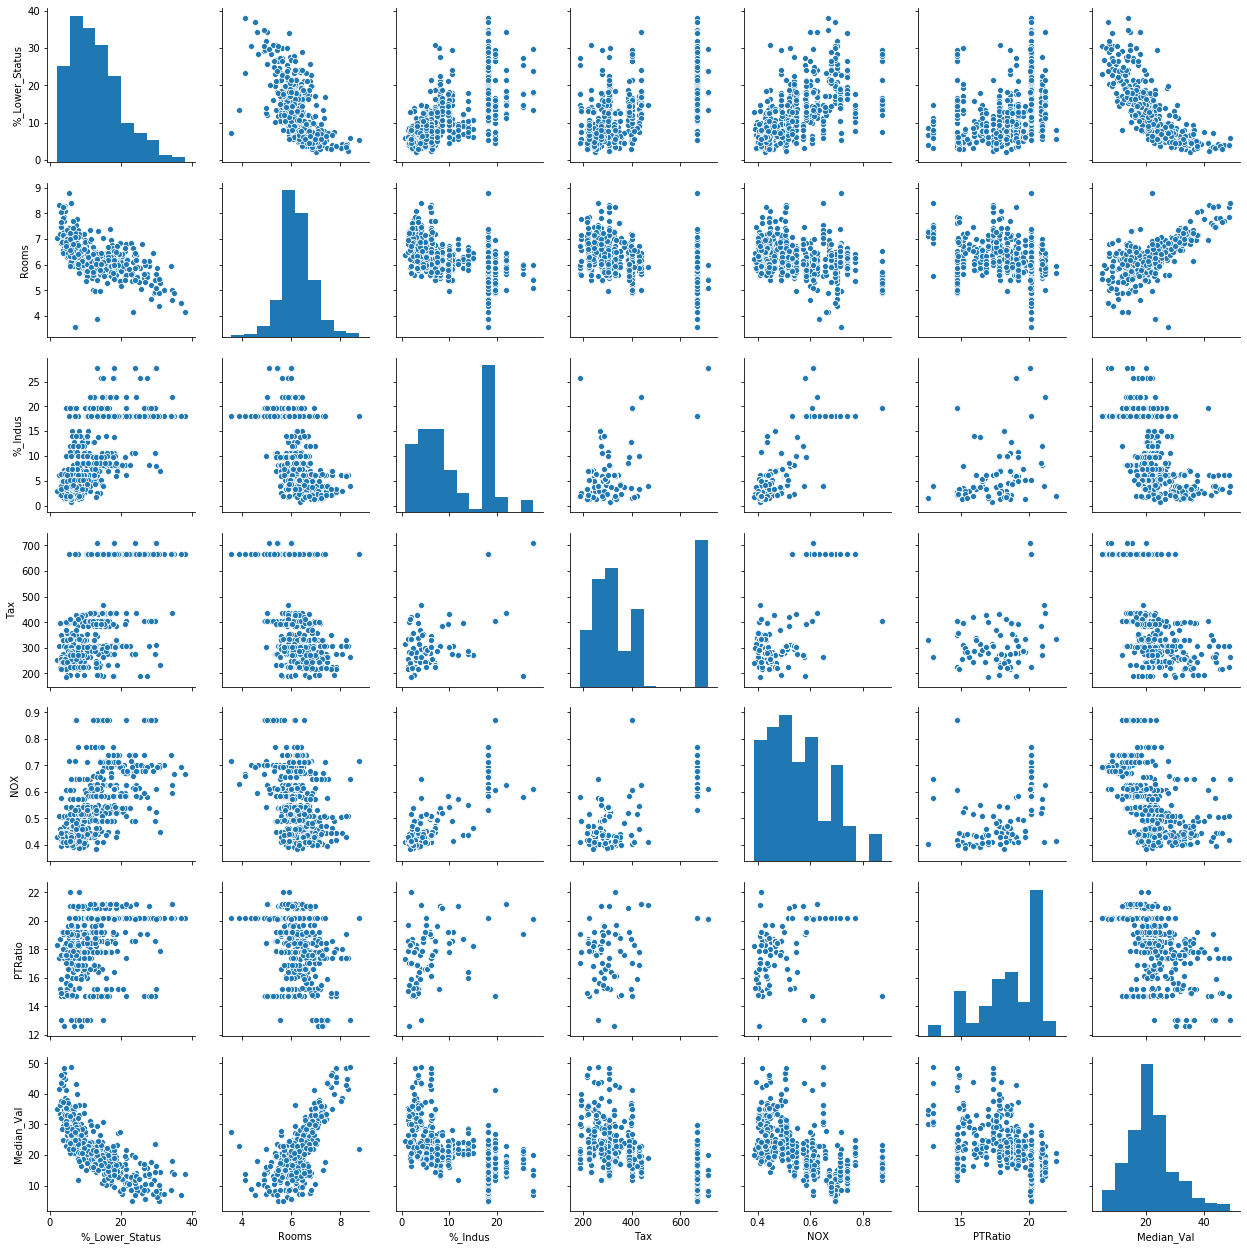

In [123]:
sns.pairplot(high_corr_features)

From looking at the right hand column of the pairplot above I observed that only % Lower Status and number of Rooms had an obvious relationship with the Median Value. Furthermore, Tax, the % Industrial, and NOX were all corrolated with eachother making them bad features to include in the model.

#### 4.5.2.3 Filtering using F_regression

I also used this test to see if it identified any alternative features vs the corrolation test.

In [124]:
# modification of chi squared test code found here:
#https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e
fregX = fifty_plus_removed.iloc[:, 0:13]  
fregy = fifty_plus_removed["Median_Val"]
fregX.head()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [125]:
bestfeatures = SelectKBest(score_func=f_regression, k=10) # show the top 10 best features
fregfit = bestfeatures.fit(fregX,fregy)
dfscores = pd.DataFrame(fregfit.scores_)
dfcolumns = pd.DataFrame(fregX.columns) 
fregfeatureScores = pd.concat([dfcolumns,dfscores],axis=1)
fregfeatureScores.columns = ['Features','Score']  #naming the dataframe columns
print(fregfeatureScores.nlargest(10,'Score'))  #print 10 best features

          Features       Score
12  %_Lower_Status  666.627892
5            Rooms  435.309814
2          %_Indus  274.507475
9              Tax  237.855059
4              NOX  185.148836
10         PTRatio  179.568192
6       %_Pre_1940  156.620474
8   Highway_Access  143.190234
0       Crime_Rate  123.991786
1    %_Large_Plots   95.527784


As with the corrolation test, % Lower Status and Rooms were identified as by far the best predictors.

### 4.5.3 Testing with Filtered Features

In this section I tested to if the performance of the model was improved by using only the two best predictors of the Median Value: % of Lower Status people and the number of Rooms.

In [129]:
# creating a new dataset containing the two inputs and target variable
filtered_features = fifty_plus_removed[["%_Lower_Status","Rooms","Median_Val"]]
filtered_features.head()

,%_Lower_Status,Rooms,Median_Val
0,4.98,6.575,24.0
1,9.14,6.421,21.6
2,4.03,7.185,34.7
3,2.94,6.998,33.4
4,5.33,7.147,36.2


In [130]:
# shuffle again and split into train and test
filtered_features = shuffle(filtered_features)

FFX = filtered_features.drop(labels=['Median_Val'], axis = 1)
FFy = filtered_features['Median_Val']

FFX_train, FFX_test, FFy_train, FFy_test = mod.train_test_split(FFX, FFy, test_size = 0.2)

In [131]:
#check how many datapoints are in the train and test batches
FFX_train.shape, FFX_test.shape

((392, 2), (98, 2))

In [132]:
# new filtered features model
FFm = ks.models.Sequential()
FFm.add(ks.layers.Dense(12, input_dim=2, activation="relu"))
FFm.add(ks.layers.Dense(1, activation="linear"))
FFm.compile(loss="mean_squared_error", optimizer="adam")
#FFes = EarlyStopping(monitor='loss', patience=20, verbose=1)

FFm.fit(FFX_train, FFy_train, epochs=300, batch_size=4)

Epoch 1/300
392/392 [==============================] - 0s 405us/step - loss: 555.9757
Epoch 2/300
392/392 [==============================] - 0s 250us/step - loss: 344.3688
Epoch 3/300
392/392 [==============================] - 0s 227us/step - loss: 224.6747
Epoch 4/300
392/392 [==============================] - 0s 209us/step - loss: 166.7542
Epoch 5/300
392/392 [==============================] - 0s 234us/step - loss: 133.1719
Epoch 6/300
392/392 [==============================] - 0s 229us/step - loss: 110.4664
Epoch 7/300
392/392 [==============================] - 0s 239us/step - loss: 90.5644
Epoch 8/300
392/392 [==============================] - 0s 237us/step - loss: 72.8800
Epoch 9/300
392/392 [==============================] - 0s 216us/step - loss: 57.7881
Epoch 10/300
392/392 [==============================] - 0s 232us/step - loss: 45.8612
Epoch 11/300
392/392 [==============================] - 0s 235us/step - loss: 36.8270
Epoch 12/300
392/392 [==============================] - 0

392/392 [==============================] - 0s 199us/step - loss: 17.8623
Epoch 97/300
392/392 [==============================] - 0s 220us/step - loss: 17.9418
Epoch 98/300
392/392 [==============================] - 0s 211us/step - loss: 17.9111
Epoch 99/300
392/392 [==============================] - 0s 204us/step - loss: 17.8664
Epoch 100/300
392/392 [==============================] - 0s 206us/step - loss: 17.8734
Epoch 101/300
392/392 [==============================] - 0s 198us/step - loss: 17.8436
Epoch 102/300
392/392 [==============================] - 0s 214us/step - loss: 18.0040
Epoch 103/300
392/392 [==============================] - 0s 207us/step - loss: 17.9215
Epoch 104/300
392/392 [==============================] - 0s 206us/step - loss: 17.7885
Epoch 105/300
392/392 [==============================] - 0s 203us/step - loss: 17.9057
Epoch 106/300
392/392 [==============================] - 0s 210us/step - loss: 17.9394
Epoch 107/300
392/392 [==============================] - 0s 

392/392 [==============================] - 0s 196us/step - loss: 17.7833
Epoch 190/300
392/392 [==============================] - 0s 209us/step - loss: 17.7347
Epoch 191/300
392/392 [==============================] - 0s 201us/step - loss: 17.7155
Epoch 192/300
392/392 [==============================] - 0s 213us/step - loss: 17.7554
Epoch 193/300
392/392 [==============================] - 0s 218us/step - loss: 17.8771
Epoch 194/300
392/392 [==============================] - 0s 237us/step - loss: 17.9070
Epoch 195/300
392/392 [==============================] - 0s 252us/step - loss: 17.7257
Epoch 196/300
392/392 [==============================] - 0s 229us/step - loss: 17.8983
Epoch 197/300
392/392 [==============================] - 0s 211us/step - loss: 18.0004
Epoch 198/300
392/392 [==============================] - 0s 204us/step - loss: 17.7620
Epoch 199/300
392/392 [==============================] - 0s 209us/step - loss: 17.9090
Epoch 200/300
392/392 [==============================] - 

392/392 [==============================] - 0s 239us/step - loss: 17.8325
Epoch 284/300
392/392 [==============================] - 0s 239us/step - loss: 17.8117
Epoch 285/300
392/392 [==============================] - 0s 259us/step - loss: 18.1249
Epoch 286/300
392/392 [==============================] - 0s 206us/step - loss: 17.8918
Epoch 287/300
392/392 [==============================] - 0s 211us/step - loss: 17.7600
Epoch 288/300
392/392 [==============================] - 0s 211us/step - loss: 17.7067
Epoch 289/300
392/392 [==============================] - 0s 217us/step - loss: 17.7697
Epoch 290/300
392/392 [==============================] - 0s 209us/step - loss: 17.7881
Epoch 291/300
392/392 [==============================] - 0s 205us/step - loss: 17.8146
Epoch 292/300
392/392 [==============================] - 0s 214us/step - loss: 17.9240
Epoch 293/300
392/392 [==============================] - 0s 275us/step - loss: 17.8828
Epoch 294/300
392/392 [==============================] - 

In [133]:
FFm.evaluate(FFX_test, FFy_test)

98/98 [==============================] - 0s 102us/step


16.940278746415768

**Result:** The result was a MSE of 16.9, drastically worse than the Baseline Test and some of the better performing subsequent models.

#### 4.5.3.1 Filtered Features Standardisation

While initial results for the model using the filtered features were worse than the Baseline, the data had not been standardised yet. The logical next step was to standardise the filtered features and evaluate performance with that data.

In [134]:
#scaling the filtered features
scaler = pre.StandardScaler()
FFX_train = pd.DataFrame(scaler.fit_transform(FFX_train), columns=FFX.columns)
FFX_test = pd.DataFrame(scaler.transform(FFX_test), columns=FFX.columns)

In [135]:
FFX_train.head()

,%_Lower_Status,Rooms
0,-0.744346,0.821034
1,2.075145,-0.456484
2,-0.565665,0.060058
3,0.756850,-0.937667
4,1.176116,-0.599455


In [136]:
# model test with normalised input features 

FFm = ks.models.Sequential()
FFm.add(ks.layers.Dense(12, input_dim=2, activation="relu"))
FFm.add(ks.layers.Dense(1, activation="linear"))
FFm.compile(loss="mean_squared_error", optimizer="adam")
#FFes = EarlyStopping(monitor='loss', patience=20, verbose=1)

FFm.fit(FFX_train, FFy_train, epochs=300, batch_size=4)

Epoch 1/300
392/392 [==============================] - 0s 374us/step - loss: 530.6098
Epoch 2/300
392/392 [==============================] - 0s 252us/step - loss: 503.9441
Epoch 3/300
392/392 [==============================] - 0s 252us/step - loss: 469.7156
Epoch 4/300
392/392 [==============================] - 0s 221us/step - loss: 427.5396
Epoch 5/300
392/392 [==============================] - 0s 275us/step - loss: 379.0773
Epoch 6/300
392/392 [==============================] - 0s 244us/step - loss: 325.8197
Epoch 7/300
392/392 [==============================] - 0s 242us/step - loss: 269.7210
Epoch 8/300
392/392 [==============================] - 0s 231us/step - loss: 213.4595
Epoch 9/300
392/392 [==============================] - 0s 242us/step - loss: 159.5454
Epoch 10/300
392/392 [==============================] - 0s 228us/step - loss: 111.7232
Epoch 11/300
392/392 [==============================] - 0s 239us/step - loss: 74.5232
Epoch 12/300
392/392 [==============================]

392/392 [==============================] - 0s 247us/step - loss: 12.2922
Epoch 97/300
392/392 [==============================] - 0s 213us/step - loss: 12.3258
Epoch 98/300
392/392 [==============================] - 0s 247us/step - loss: 12.2676
Epoch 99/300
392/392 [==============================] - 0s 222us/step - loss: 12.2743
Epoch 100/300
392/392 [==============================] - 0s 213us/step - loss: 12.2599
Epoch 101/300
392/392 [==============================] - 0s 212us/step - loss: 12.3172
Epoch 102/300
392/392 [==============================] - 0s 211us/step - loss: 12.2646
Epoch 103/300
392/392 [==============================] - 0s 221us/step - loss: 12.2504
Epoch 104/300
392/392 [==============================] - 0s 221us/step - loss: 12.2165
Epoch 105/300
392/392 [==============================] - 0s 213us/step - loss: 12.1958
Epoch 106/300
392/392 [==============================] - 0s 204us/step - loss: 12.1983
Epoch 107/300
392/392 [==============================] - 0s 

392/392 [==============================] - 0s 220us/step - loss: 11.9460
Epoch 191/300
392/392 [==============================] - 0s 223us/step - loss: 11.9421
Epoch 192/300
392/392 [==============================] - 0s 219us/step - loss: 11.9627
Epoch 193/300
392/392 [==============================] - 0s 216us/step - loss: 11.9336
Epoch 194/300
392/392 [==============================] - 0s 211us/step - loss: 11.9619
Epoch 195/300
392/392 [==============================] - 0s 221us/step - loss: 11.9286
Epoch 196/300
392/392 [==============================] - 0s 202us/step - loss: 11.9639
Epoch 197/300
392/392 [==============================] - 0s 213us/step - loss: 11.9820
Epoch 198/300
392/392 [==============================] - 0s 209us/step - loss: 11.9387
Epoch 199/300
392/392 [==============================] - 0s 222us/step - loss: 11.9188
Epoch 200/300
392/392 [==============================] - 0s 217us/step - loss: 11.9070
Epoch 201/300
392/392 [==============================] - 

392/392 [==============================] - 0s 211us/step - loss: 11.8645
Epoch 285/300
392/392 [==============================] - 0s 198us/step - loss: 11.8631
Epoch 286/300
392/392 [==============================] - 0s 195us/step - loss: 11.8623
Epoch 287/300
392/392 [==============================] - 0s 201us/step - loss: 11.8578
Epoch 288/300
392/392 [==============================] - 0s 224us/step - loss: 11.8476
Epoch 289/300
392/392 [==============================] - 0s 214us/step - loss: 11.8687
Epoch 290/300
392/392 [==============================] - 0s 219us/step - loss: 11.8872
Epoch 291/300
392/392 [==============================] - 0s 214us/step - loss: 11.8720
Epoch 292/300
392/392 [==============================] - 0s 205us/step - loss: 11.8429
Epoch 293/300
392/392 [==============================] - 0s 216us/step - loss: 11.8624
Epoch 294/300
392/392 [==============================] - 0s 218us/step - loss: 11.8576
Epoch 295/300
392/392 [==============================] - 

In [137]:
FFm.evaluate(FFX_test, FFy_test)

98/98 [==============================] - 0s 102us/step


18.124651225245728

**Result:** MSE was 18.124

Even after the standardisation the performance of the model still failed by a wide marginto beat the Baseline test where all 13 features where included.

#### 4.5.3.2 Filtered Features - Comparing Various Model Configurations

To be sure that not improvements using the filtered set were possible I tested serveral different model configurations. 

In [138]:
# function to test various model configurations on the filter features dataset
def FF_tester(layer_size1, layer_size2, batch_S, OPT):
    counter = 0
    results = []
    while counter < 5:
        FFm = ks.models.Sequential()
        FFm.add(ks.layers.Dense(layer_size1, input_dim=2, activation="relu"))
        FFm.add(ks.layers.Dense(layer_size2, activation="relu"))
        FFm.add(ks.layers.Dense(1,activation="linear"))

        FFm.compile(loss="mean_squared_error", optimizer=OPT)

        FFes = EarlyStopping(monitor='loss', patience=20, verbose=1)

        FFm.fit(FFX_train, FFy_train, epochs=300, batch_size=batch_S, callbacks=[FFes])

        result_units = FFm.evaluate(FFX_test, FFy_test)

        counter += 1

        results.append(result_units)
   
        
    avg_result = sum(results) / 5
    return avg_result

In [139]:
# big_all_adam = FF_tester(64,64,32,"adam") # large layers, large batches, adam optimizer
# big_all_adam

In [140]:
# bigLayer_mediumbatch_adam = FF_tester(64,64,16,"adam") # large layers, large batches, adam optimizer
# bigLayer_smallbatch_adam = FF_tester(64,64,4,"adam")

In [141]:
# print(bigLayer_mediumbatch_adam)

NameError: name 'bigLayer_mediumbatch_adam' is not defined

In [ ]:
# print(bigLayer_smallbatch_adam)

In [142]:
# mediumLayer_bigbatch_adam = FF_tester(32,12,32,"adam")
# mediumLayer_mediumbatch_adam  = FF_tester(32,12,16,"adam")
# mediumLayer_smallbatch_adam  = FF_tester(32,12,4,"adam")

In [143]:
# print(mediumLayer_bigbatch_adam)
# print(mediumLayer_mediumbatch_adam)
# print(mediumLayer_smallbatch_adam)

NameError: name 'mediumLayer_bigbatch_adam' is not defined

In [144]:
#smallLayer_bigbatch_adam  = FF_tester(12,6,32,"adam")
#smallLayer_mediumbatch_adam  = FF_tester(12,6,16,"adam")
#smallLayer_smallbatch_adam  = FF_tester(12,6,4,"adam")
# tinyLayer_smallbatch_adam = FF_tester(2,2,4,"adam")

In [145]:
# print(smallLayer_bigbatch_adam)
# print(smallLayer_mediumbatch_adam)
# print(smallLayer_smallbatch_adam)
# print(tinyLayer_smallbatch_adam)

NameError: name 'smallLayer_bigbatch_adam' is not defined

**Result:** Medium layer sizes seemed to peform the best, but still did not better the original baseline test. Next I will tried removing a layer.

In [146]:
def FF_tester_1layer(layer_size1, batch_S, OPT):
    counter = 0
    results = []
    while counter < 5:
        FFm = ks.models.Sequential()
        FFm.add(ks.layers.Dense(layer_size1, input_dim=2, activation="relu"))
        FFm.add(ks.layers.Dense(1,activation="linear"))

        FFm.compile(loss="mean_squared_error", optimizer=OPT)

        FFes = EarlyStopping(monitor='loss', patience=20, verbose=1)

        FFm.fit(FFX_train, FFy_train, epochs=300, batch_size=batch_S, callbacks=[FFes])

        result_units = FFm.evaluate(FFX_test, FFy_test)

        counter += 1

        results.append(result_units)
   
        
    avg_result = sum(results) / 5
    return avg_result

In [147]:
# hugelayer = FF_tester_1layer(64, 4, "adam")
# biglayer = FF_tester_1layer(32, 4, "adam")
# mediumlayer = FF_tester_1layer(12, 4, "adam")
# smalllayer = FF_tester_1layer(6, 4, "adam")


In [ ]:
# print(hugelayer)
# print(biglayer)
# print(mediumlayer)
# print(smalllayer)

**Result:** Again, there didn't seem to be any drastic improvements and the results were still not beating the initial Baseline Test on all features. 

## 4.6 Conclusion and Final Model

In this final section, retested the best performing models from above to determine the final model. For the retest I used the dataset with all variables included, but with the samples that had a Median Value of 50,000 removed. 

In [148]:
final_model_df = fifty_plus_removed
final_model_df.head()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [149]:
# suffling the data 
final_model_df = shuffle(final_model_df)
final_model_df

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
55,0.01311,90.0,1.22,0.0,0.403,7.249,21.9,8.6966,5.0,226.0,17.9,395.93,4.81,35.4
477,15.02340,0.0,18.10,0.0,0.614,5.304,97.3,2.1007,24.0,666.0,20.2,349.48,24.91,12.0
155,3.53501,0.0,19.58,1.0,0.871,6.152,82.6,1.7455,5.0,403.0,14.7,88.01,15.02,15.6
387,22.59710,0.0,18.10,0.0,0.700,5.000,89.5,1.5184,24.0,666.0,20.2,396.90,31.99,7.4
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,0.16211,20.0,6.96,0.0,0.464,6.240,16.3,4.4290,3.0,223.0,18.6,396.90,6.59,25.2
221,0.40771,0.0,6.20,1.0,0.507,6.164,91.3,3.0480,8.0,307.0,17.4,395.24,21.46,21.7
378,23.64820,0.0,18.10,0.0,0.671,6.380,96.2,1.3861,24.0,666.0,20.2,396.90,23.69,13.1
253,0.36894,22.0,5.86,0.0,0.431,8.259,8.4,8.9067,7.0,330.0,19.1,396.90,3.54,42.8


In [151]:
# creating the input and out datasets for the final tests
FinalX = final_model_df.drop(labels=['Median_Val'], axis = 1)
Finaly = final_model_df['Median_Val']

FinalX_train, FinalX_test, Finaly_train, Finaly_test = mod.train_test_split(FinalX, Finaly, test_size = 0.2, random_state = 0)

In [152]:
FinalX.head()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status
55,0.01311,90.0,1.22,0.0,0.403,7.249,21.9,8.6966,5.0,226.0,17.9,395.93,4.81
477,15.02340,0.0,18.10,0.0,0.614,5.304,97.3,2.1007,24.0,666.0,20.2,349.48,24.91
155,3.53501,0.0,19.58,1.0,0.871,6.152,82.6,1.7455,5.0,403.0,14.7,88.01,15.02
387,22.59710,0.0,18.10,0.0,0.700,5.000,89.5,1.5184,24.0,666.0,20.2,396.90,31.99
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94


In [154]:
# scaling the data
scaler = pre.StandardScaler()
FinalX_train = pd.DataFrame(scaler.fit_transform(FinalX_train), columns=FinalX.columns)
FinalX_test = pd.DataFrame(scaler.transform(FinalX_test), columns=FinalX.columns)

In [155]:
FinalX_train.head()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status
0,0.537067,-0.490179,1.017307,-0.243843,1.361286,0.075854,0.548710,-0.499380,1.652201,1.526467,0.786925,-0.940389,0.494270
1,-0.420864,2.750855,-1.184259,-0.243843,-1.078039,0.516614,-1.654373,0.732027,-0.752063,-0.915399,-0.107614,0.426222,-1.206138
2,-0.413045,1.454441,-1.113053,-0.243843,-1.001007,1.050323,-1.665050,1.239407,-0.523085,-0.054258,-1.567124,0.227465,-1.094776
3,-0.420384,3.615130,-1.399329,-0.243843,-1.292014,1.086304,-1.885714,1.791423,-0.752063,-0.030665,-0.719666,0.440285,-1.171873
4,-0.326855,0.374097,-1.036035,-0.243843,0.796390,1.144772,0.580741,-0.805209,-0.523085,-0.844620,-2.602905,0.298220,0.288679


In [156]:
#test final model option 1
def Final_tester(layer_size1, layer_size2):
    counter = 0
    results = []
    while counter < 5:
        m = ks.models.Sequential()
        m.add(ks.layers.Dense(layer_size1, input_dim=13, activation="relu"))
        m.add(ks.layers.Dense(layer_size2, activation="relu"))
        m.add(ks.layers.Dense(1,activation="linear"))

        m.compile(loss="mean_squared_error", optimizer="adam")

        es = EarlyStopping(monitor='loss', patience=20, verbose=1)

        m.fit(FinalX_train, Finaly_train, epochs=300, batch_size=4, callbacks=[es])

        result_units = m.evaluate(FinalX_test, Finaly_test)

        counter += 1

        results.append(result_units)
   
        
    avg_result = sum(results) / 5
    return avg_result

In [ ]:
final_results = [
    Final_tester(13, 13),
    Final_tester(26, 26),
    Final_tester(26, 13),
    Final_tester(52, 26),
    Final_tester(64, 13)
]

In [ ]:
final_labels = ["13 -> 13", "26 -> 26", "26 -> 13", "52 -> 26", "64 -> 13"]

In [ ]:
final_results_df = pd.DataFrame({'Tests': final_labels, 'Results': final_results})
final_results_df

TODO - chart the various models and show the predictions against the real test data.

# 5. References

[1] Brownlee, J. (2019). How to Configure the Number of Layers and Nodes in a Neural Network. [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/how-to-configure-the-number-of-layers-and-nodes-in-a-neural-network/ [Accessed 27 Nov. 2019].

[2] Faqs.org. (2019). comp.ai.neural-nets FAQ, Part 3 of 7: GeneralizationSection - How many hidden layers should I use?. [online] Available at: http://www.faqs.org/faqs/ai-faq/neural-nets/part3/section-9.html [Accessed 27 Nov. 2019].

[3] Faqs.org. (2019). comp.ai.neural-nets FAQ, Part 3 of 7: GeneralizationSection - How many hidden units should I use?. [online] Available at: http://www.faqs.org/faqs/ai-faq/neural-nets/part3/section-10.html [Accessed 27 Nov. 2019].

[4] Learning, D. and Them?, F. (2019). Fundamentals of Deep Learning - Activation Functions and their use. [online] Analytics Vidhya. Available at: https://www.analyticsvidhya.com/blog/2017/10/fundamentals-deep-learning-activation-functions-when-to-use-them/ [Accessed 27 Nov. 2019].

[5] Medium. (2019). Activation functions and it’s types-Which is better?. [online] Available at: https://towardsdatascience.com/activation-functions-and-its-types-which-is-better-a9a5310cc8f [Accessed 27 Nov. 2019].

[6] Gupta, V. (2019). Deep learning using Keras - The Basics | Learn OpenCV. [online] Learnopencv.com. Available at: https://www.learnopencv.com/deep-learning-using-keras-the-basics/ [Accessed 27 Nov. 2019].

[7] Brownlee, J. (2019). A Gentle Introduction to the Rectified Linear Unit (ReLU). [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/ [Accessed 27 Nov. 2019].

[8] Sebastian Ruder. (2019). An overview of gradient descent optimization algorithms. [online] Available at: https://ruder.io/optimizing-gradient-descent/index.html#conclusion [Accessed 27 Nov. 2019].

[9] Brownlee, J. (2019). Gentle Introduction to the Adam Optimization Algorithm for Deep Learning. [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/ [Accessed 27 Nov. 2019].

[10] Algorithmia Blog. (2019). Introduction to Optimizers | Algorithmia Blog. [online] Available at: https://algorithmia.com/blog/introduction-to-optimizers [Accessed 27 Nov. 2019].

[11] Medium. (2019). Epoch vs Batch Size vs Iterations. [online] Available at: https://towardsdatascience.com/epoch-vs-iterations-vs-batch-size-4dfb9c7ce9c9 [Accessed 27 Nov. 2019].

[12] Brownlee, J. (2019). A Gentle Introduction to Mini-Batch Gradient Descent and How to Configure Batch Size. [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/gentle-introduction-mini-batch-gradient-descent-configure-batch-size/ [Accessed 27 Nov. 2019].

[13] Brownlee, J. (2019). An Introduction to Feature Selection. [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/an-introduction-to-feature-selection/ [Accessed 4 Dec. 2019].

[14] Chandrayan, P. (2019). Hypothesis Testing Using T Test : Inferential Statistics Part3. [online] Medium. Available at: https://towardsdatascience.com/hypothesis-testing-using-t-test-inferential-statistics-part3-6fb43683bc32 [Accessed 12 Dec. 2019].

[15] Brownlee, J. (2019). A Gentle Introduction to Normality Tests in Python. [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/ [Accessed 30 Oct. 2019].